In [1]:
# Data Manipulation and Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Evaluation metrics and visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import itertools
import time
import csv

Using device: cuda


In [2]:
# Load cleaned dataset
df = pd.read_csv('BTC_1h_Complete_NoTA.csv', parse_dates=['open_time'])

In [3]:
df.head()

open_time     open     high      low    close      volume  \
0 2020-01-01 00:00:00  7195.24  7196.25  7175.46  7177.02  511.814901   
1 2020-01-01 01:00:00  7176.47  7230.00  7175.71  7216.27  883.052603   
2 2020-01-01 02:00:00  7215.52  7244.87  7211.41  7242.85  655.156809   
3 2020-01-01 03:00:00  7242.66  7245.00  7220.00  7225.01  783.724867   
4 2020-01-01 04:00:00  7225.00  7230.00  7215.03  7217.27  467.812578   

            close_time     quote_vol   count    buy_base  ...    open_p  \
0  2020-01-01 01:00:00  3.675857e+06  7640.0  226.153126  ... -0.000777   
1  2020-01-01 02:00:00  6.365953e+06  9033.0  570.721419  ... -0.000818   
2  2020-01-01 03:00:00  4.736719e+06  7466.0  357.180263  ... -0.000445   
3  2020-01-01 04:00:00  5.667367e+06  8337.0  394.810811  ... -0.000412   
4  2020-01-01 05:00:00  3.379094e+06  5896.0  243.514706  ... -0.000523   

     high_p     low_p   close_p  log_open  log_high   log_low  log_close  \
0 -0.000443 -0.001206 -0.000809  8.881175  8.881315  8.878422   8.878640   
1 -0.000100 -0.001015 -0.000801  8.878563  8.885994  8.878457   8.884093   
2 -0.000445 -0.001063 -0.000554  8.883990  8.888049  8.883420   8.887770   
3 -0.000295 -0.001005 -0.000627  8.887744  8.888067  8.884610   8.885304   
4 -0.000296 -0.000887 -0.000517  8.885303  8.885994  8.883922   8.884232   

    diff  log_diff  
0 -18.22 -0.002535  
1  39.80  0.005531  
2  27.33  0.003781  
3 -17.65 -0.002440  
4  -7.73 -0.001070  

[5 rows x 21 columns]

In [5]:
# Convert to datetime 
df['open_time'] = pd.to_datetime(df['open_time'])
df['close_time'] = pd.to_datetime(df['close_time'])

In [6]:
# Function to create sequences
def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = target[i + window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Function to prepare data
def prepare_data(df, target_column, window_size, feature_columns):
    X = df[feature_columns].values
    y = df[target_column].values.reshape(-1, 1)  # Reshape y to match scaler's expected input

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))

# def plot_loss_over_epochs(training_loss, validation_loss, file_prefix):
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(10, 6))
#     plt.plot(training_loss, label='Training Loss')
#     plt.plot(validation_loss, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss Over Epochs')
#     plt.legend()
#     plt.savefig(f'{file_prefix}_loss_plot.png')
#     plt.show()

# New one which plots from 
def plot_loss_over_epochs(training_loss, validation_loss, file_prefix, start_epoch=3):
    plt.figure(figsize=(10, 6))
    plt.plot(range(start_epoch, len(training_loss)), training_loss[start_epoch:], label='Training Loss')
    plt.plot(range(start_epoch, len(validation_loss)), validation_loss[start_epoch:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.savefig(f'{file_prefix}_loss_plot.png')
    plt.show()


In [7]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, lstm_dim, dense_dim, output_dim, num_layers=1, dropout=0.0, activation_function=nn.ReLU):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_dim, num_layers=num_layers, batch_first=True, dropout=(dropout if num_layers > 1 else 0))
        self.fc1 = nn.Linear(lstm_dim, dense_dim)
        self.activation = activation_function()
        self.fc2 = nn.Linear(dense_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Training and evaluation function
def train_and_evaluate(df, target_column, feature_columns, params, file_prefix='results', use_early_stopping=True, plot_loss=False):
    # Extract parameters
    window_size = params['window_size']
    lstm_dim = params['lstm_dim']
    dense_dim = params['dense_dim']
    num_layers = params['num_layers']
    dropout = params['dropout']
    lr = params['lr']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    optimizer_type = params['optimizer_type']
    patience = params['patience']
    activation_function = params['activation_function']

    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Prepare data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y = prepare_data(df, target_column, window_size, feature_columns)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)
    y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Model parameters
    input_dim = X_train_tensor.shape[2]
    output_dim = 1

    model = LSTMModel(input_dim, lstm_dim, dense_dim, output_dim, num_layers, dropout, activation_function).to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=lr)

    # Training loop
    best_loss = float('inf')
    patience_counter = 0
    start_time = time.time()

    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        training_losses.append(epoch_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(test_loader)
        validation_losses.append(val_loss)

        if use_early_stopping:
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'{file_prefix}_{target_column}_best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

    training_time = time.time() - start_time

    if use_early_stopping:
        model.load_state_dict(torch.load(f'{file_prefix}_{target_column}_best_model.pth'))

    # Evaluate the model
    model.eval()
    evaluation_start_time = time.time()
    with torch.no_grad():
        train_predictions = model(X_train_tensor).cpu().numpy()
        test_predictions = model(X_test_tensor).cpu().numpy()

        # Inverse transform predictions and actual values
        y_train_seq = y_train_seq.reshape(-1, 1)
        y_test_seq = y_test_seq.reshape(-1, 1)
        train_predictions_inverse = scaler_y.inverse_transform(train_predictions)
        test_predictions_inverse = scaler_y.inverse_transform(test_predictions)
        y_train_inverse = scaler_y.inverse_transform(y_train_seq)
        y_test_inverse = scaler_y.inverse_transform(y_test_seq)

        train_mse = mean_squared_error(y_train_inverse, train_predictions_inverse)
        test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
        train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
        test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_r2 = r2_score(y_train_inverse, train_predictions_inverse)
        test_r2 = r2_score(y_test_inverse, test_predictions_inverse)

        train_mape = np.mean(np.abs((y_train_inverse - train_predictions_inverse) / y_train_inverse)) * 100
        test_mape = np.mean(np.abs((y_test_inverse - test_predictions_inverse) / y_test_inverse)) * 100

        train_directional_acc = np.mean(np.sign(y_train_inverse[1:] - y_train_inverse[:-1]) == np.sign(train_predictions_inverse[1:] - train_predictions_inverse[:-1]))
        test_directional_acc = np.mean(np.sign(y_test_inverse[1:] - y_test_inverse[:-1]) == np.sign(test_predictions_inverse[1:] - test_predictions_inverse[:-1]))

    evaluation_time = time.time() - evaluation_start_time

    result = {
        "window_size": window_size,
        "lstm_dim": lstm_dim,
        "num_layers": num_layers,
        "dense_dim": dense_dim,
        "dropout": dropout,
        "lr": lr,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "optimizer_type": optimizer_type,
        "activation_function": activation_function.__name__,
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_mape": train_mape,
        "test_mape": test_mape,
        "train_directional_acc": train_directional_acc,
        "test_directional_acc": test_directional_acc,
        "training_time": training_time,
        "evaluation_time": evaluation_time,
        "patience": patience
    }

    # Save result to a CSV file
    with open(f'{file_prefix}_{target_column}.csv', 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=result.keys())
        if f.tell() == 0:
            writer.writeheader()  # Write header only if file is empty
        writer.writerow(result)

    # Print summary of the results
    print(f"Finished model with parameters: {params}")
    print(f"Results: Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
    print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
    print(f"Train Directional Accuracy: {train_directional_acc:.4f}, Test Directional Accuracy: {test_directional_acc:.4f}")
    print(f"Training Time: {training_time:.4f} seconds, Evaluation Time: {evaluation_time:.4f} seconds\n")

    # Plot loss over epochs if specified
    if plot_loss:
        plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=3)

    return result

In [8]:
# Define parameter space
parameter_space = {
    'window_size': [24],
    'lstm_dim': [96, 128, 150],
    'dense_dim': [96, 128, 150],
    'num_layers': [1],
    'dropout': [0.001, 0.0001],
    'lr': [0.0001, 0.001],
    'num_epochs': [50, 100, 150],
    'batch_size': [64],
    'optimizer_type': ['Adam'],
    'patience': [24],
    'activation_function': [nn.Tanh]
}

# Define target columns
target_columns = ['close']

# Define feature combinations
feature_combinations = [
    ['open', 'high', 'low', 'close', 'volume',
       'quote_vol', 'count', 'buy_base', 'buy_quote']
]


Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 77350.2803, Test MSE: 66418.1401, Train MAE: 171.4550, Test MAE: 145.5018
Train RMSE: 278.1192, Test RMSE: 257.7172, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6969, Test MAPE: 0.3227
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4709
Training Time: 48.0994 seconds, Evaluatio

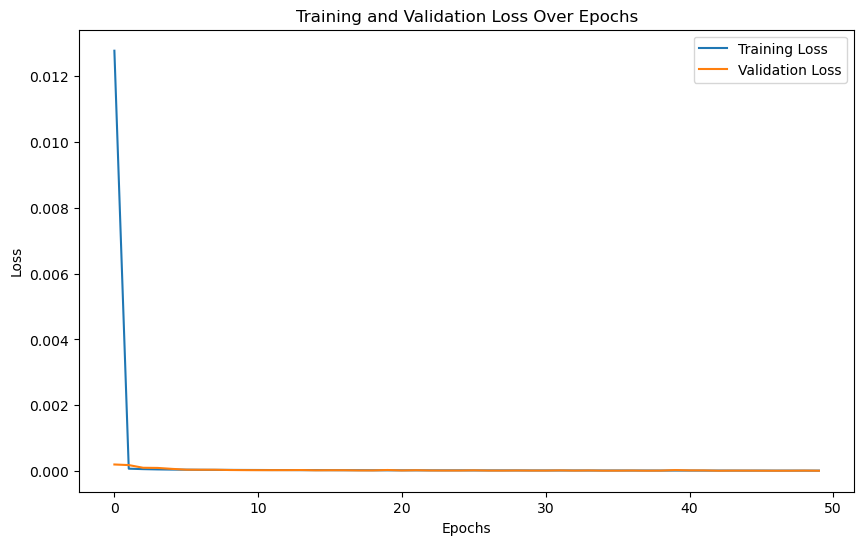

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 81000.5856, Test MSE: 72130.5816, Train MAE: 165.6995, Test MAE: 153.2878
Train RMSE: 284.6060, Test RMSE: 268.5714, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5857, Test MAPE: 0.3405
Train Directional Accuracy: 0.4668, Test Directional Accuracy: 0.4745
Training Time: 47.6614 seconds, Evaluation Time: 0.1531 seconds



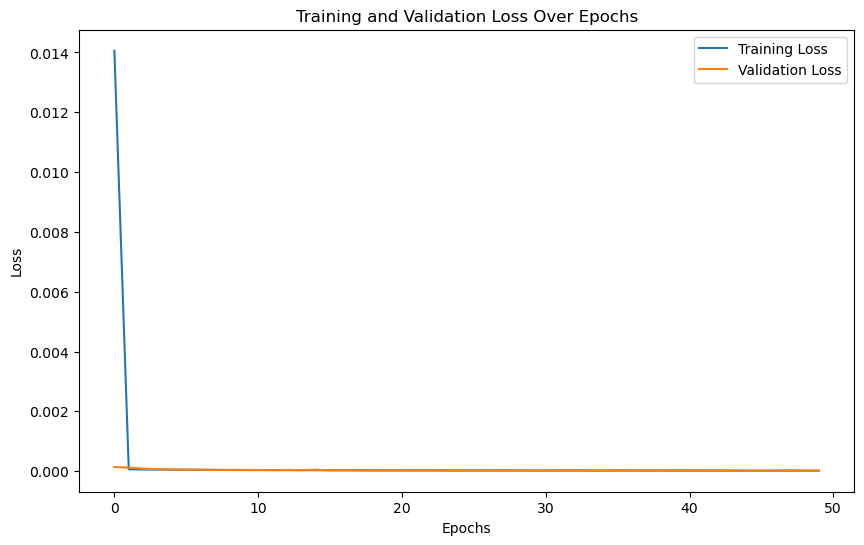

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68649.2558, Test MSE: 63974.3429, Train MAE: 145.9537, Test MAE: 142.7545
Train RMSE: 262.0100, Test RMSE: 252.9315, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4901, Test MAPE: 0.3148
Train Directional Accuracy: 0.4731, Test Directional Accuracy: 0.4745
Training Time: 97.9287 seconds, Evaluat

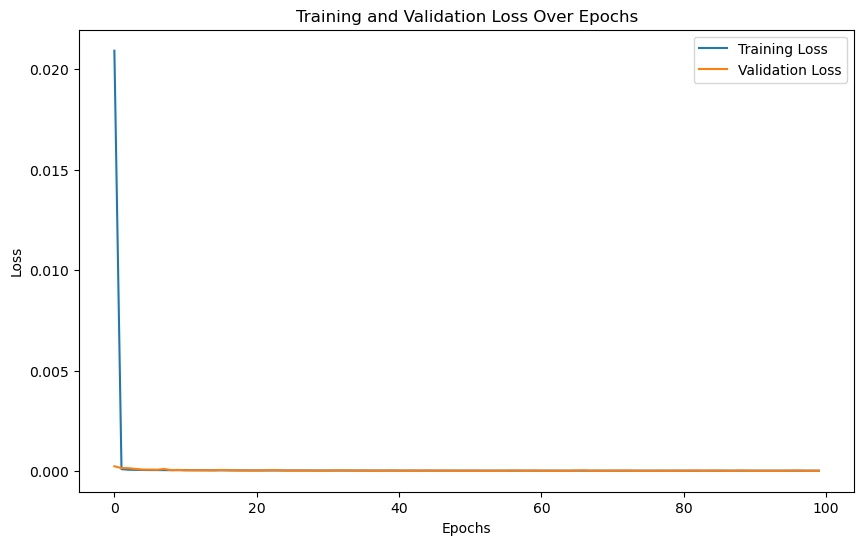

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74857.2994, Test MSE: 80295.8059, Train MAE: 167.6226, Test MAE: 192.8558
Train RMSE: 273.6006, Test RMSE: 283.3651, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5902, Test MAPE: 0.4549
Train Directional Accuracy: 0.4729, Test Directional Accuracy: 0.4724
Training Time: 98.5821 seconds, Evaluation Time: 0.1482 seconds



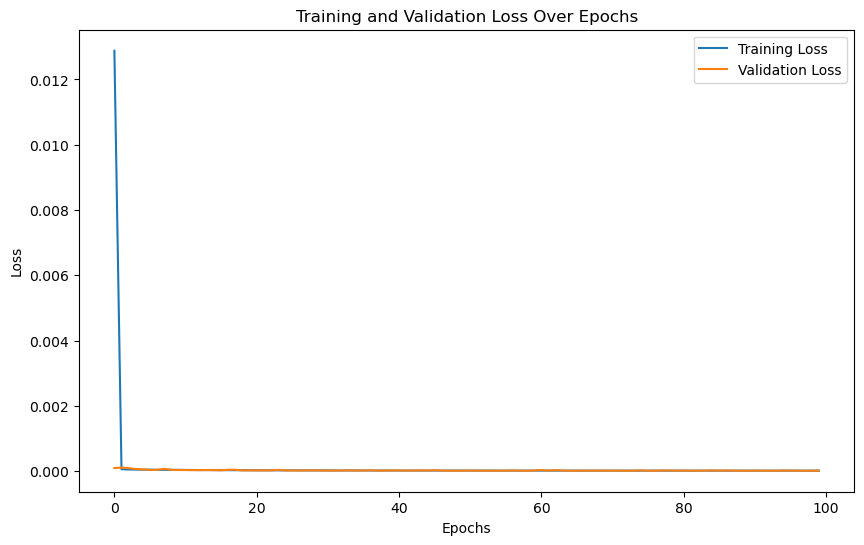

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66389.7018, Test MSE: 60845.2250, Train MAE: 149.6106, Test MAE: 140.4785
Train RMSE: 257.6620, Test RMSE: 246.6682, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5530, Test MAPE: 0.3115
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4700
Training Time: 145.2512 seconds, Evalua

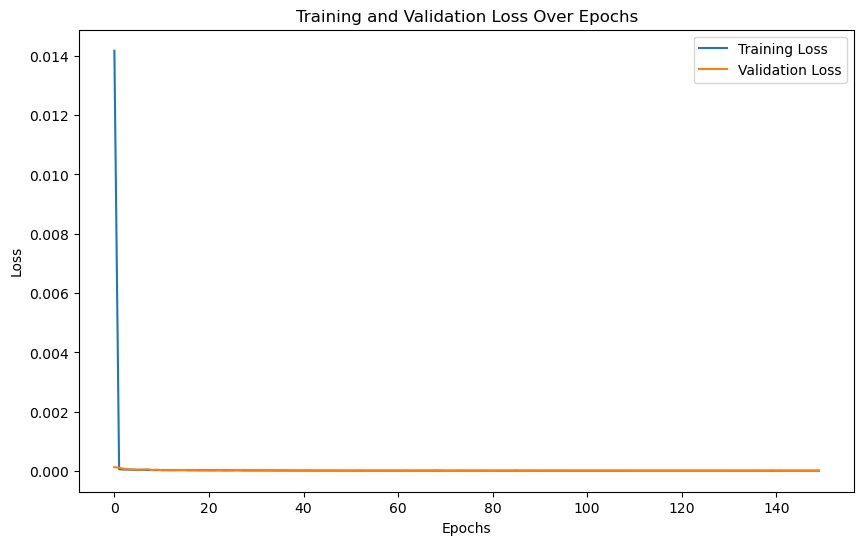

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 82055.6215, Test MSE: 85993.1293, Train MAE: 202.5000, Test MAE: 211.4958
Train RMSE: 286.4535, Test RMSE: 293.2459, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.8886, Test MAPE: 0.5145
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4705
Training Time: 145.6683 seconds, Evaluation Time: 0.1551 seconds



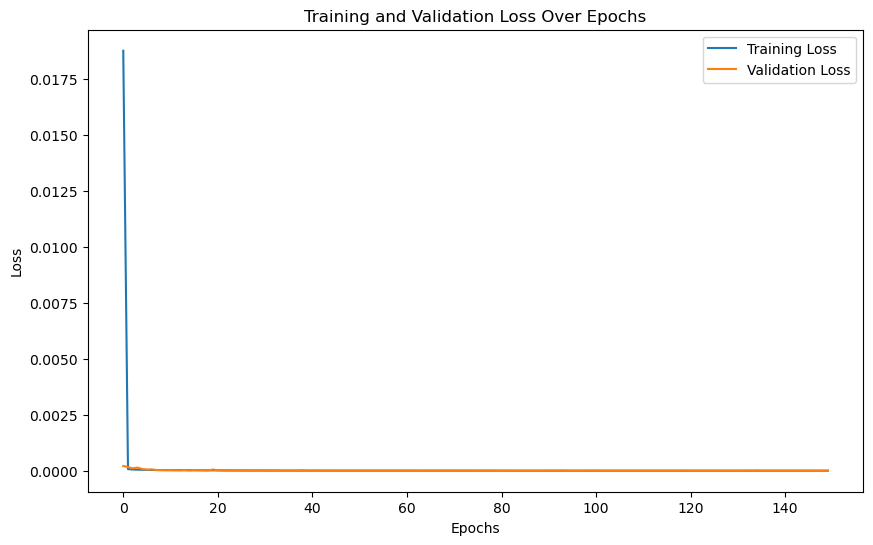

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66134.8936, Test MSE: 61592.3306, Train MAE: 146.3258, Test MAE: 141.2244
Train RMSE: 257.1671, Test RMSE: 248.1780, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5212, Test MAPE: 0.3104
Train Directional Accuracy: 0.4706, Test Directional Accuracy: 0.4718
Training Time: 48.8023 seconds, Evaluation 

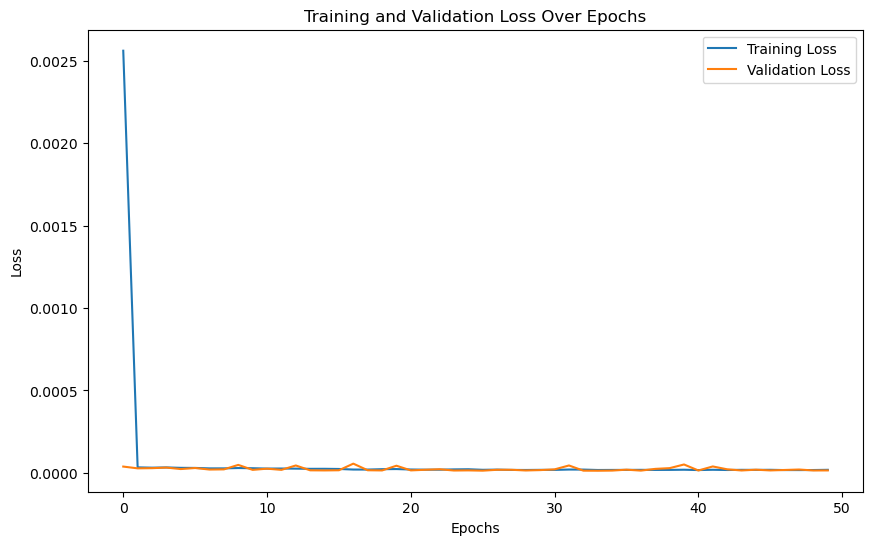

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 81986.0653, Test MSE: 71852.7425, Train MAE: 197.4657, Test MAE: 182.7159
Train RMSE: 286.3321, Test RMSE: 268.0536, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.8195, Test MAPE: 0.4406
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4673
Training Time: 49.0670 seconds, Evaluation Time: 0.2392 seconds



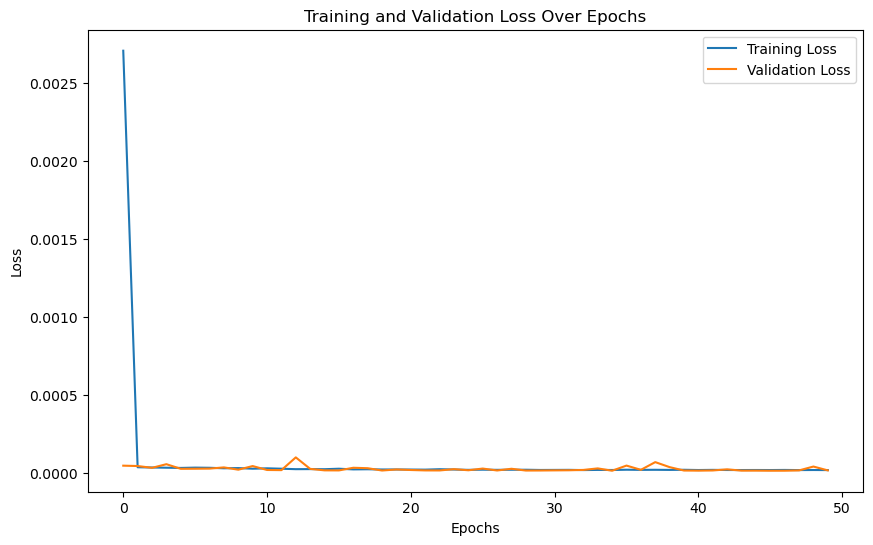

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64698.0980, Test MSE: 60547.5269, Train MAE: 145.0232, Test MAE: 139.7721
Train RMSE: 254.3582, Test RMSE: 246.0641, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5165, Test MAPE: 0.3096
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4689
Training Time: 99.0552 seconds, Evaluatio

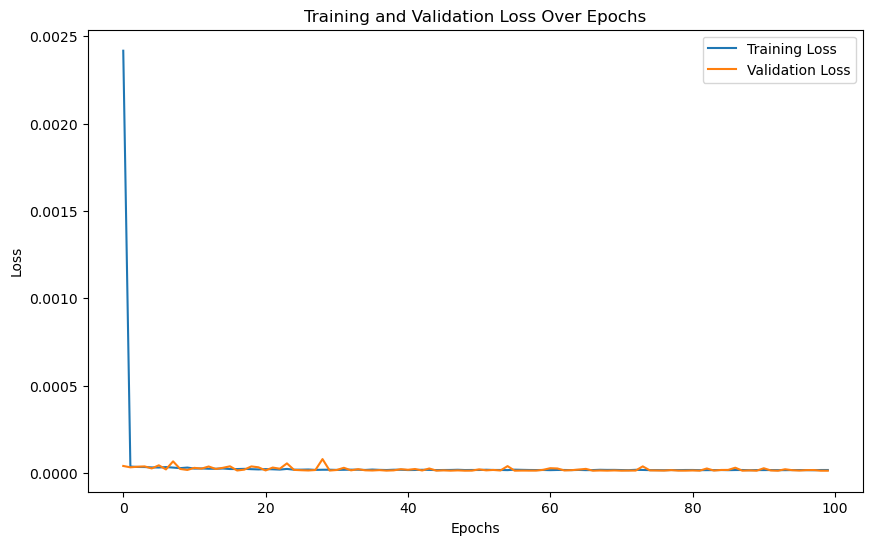

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67278.8794, Test MSE: 61910.2852, Train MAE: 149.4260, Test MAE: 143.7908
Train RMSE: 259.3817, Test RMSE: 248.8178, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5219, Test MAPE: 0.3194
Train Directional Accuracy: 0.4692, Test Directional Accuracy: 0.4687
Training Time: 100.1400 seconds, Evaluation Time: 0.2407 seconds



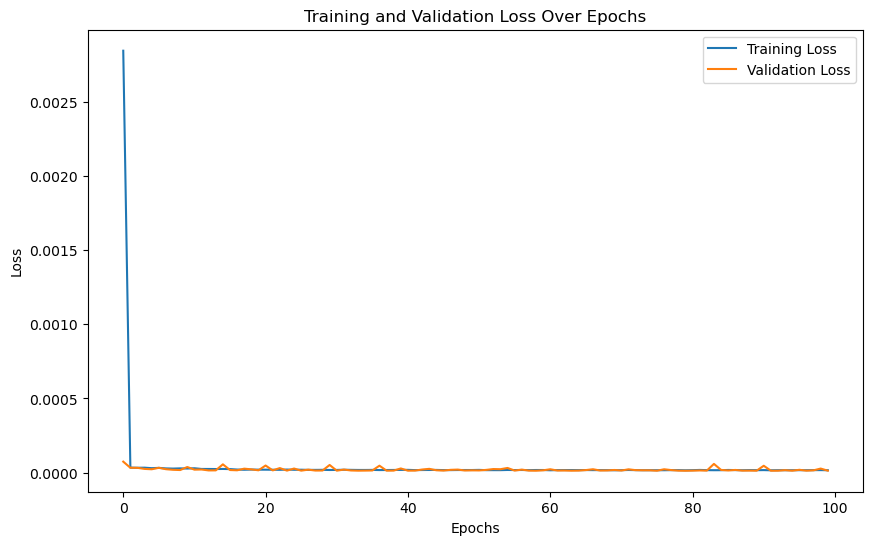

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68451.3680, Test MSE: 61397.1125, Train MAE: 152.2129, Test MAE: 141.2270
Train RMSE: 261.6321, Test RMSE: 247.7844, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5502, Test MAPE: 0.3114
Train Directional Accuracy: 0.4731, Test Directional Accuracy: 0.4693
Training Time: 60.0175 seconds, Evaluatio

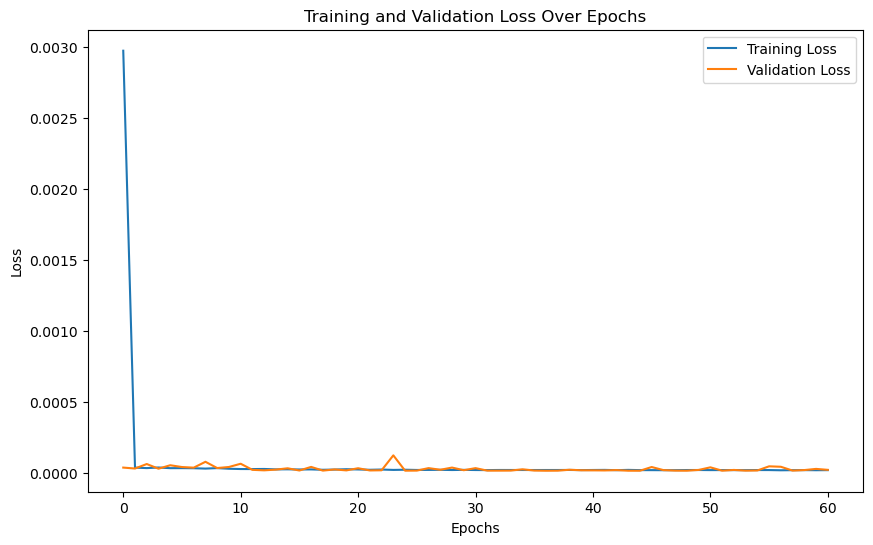

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 76908.4199, Test MSE: 96162.0981, Train MAE: 168.8037, Test MAE: 217.5936
Train RMSE: 277.3237, Test RMSE: 310.1001, Train R2: 0.9997, Test R2: 0.9995
Train MAPE: 0.5600, Test MAPE: 0.5046
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4689
Training Time: 147.1801 seconds, Evaluation Time: 0.1786 seconds



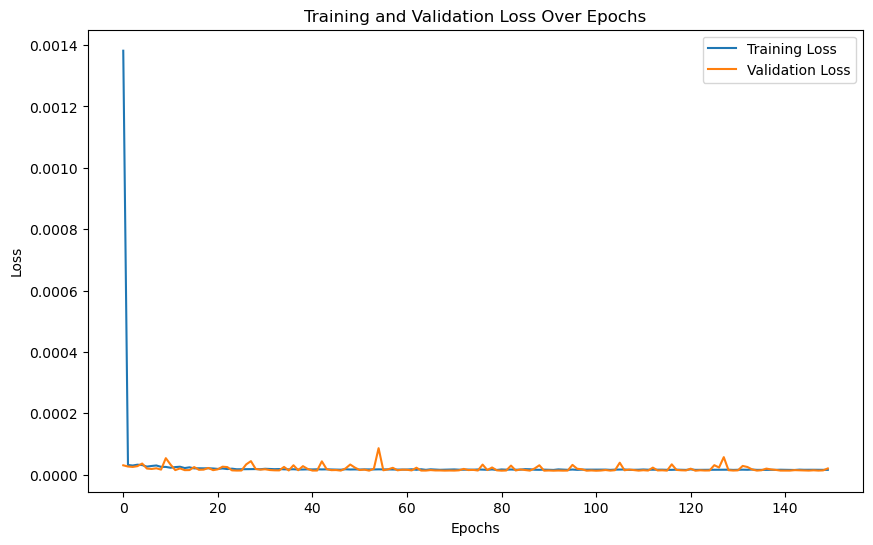

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 80973.1367, Test MSE: 70448.7712, Train MAE: 158.8780, Test MAE: 148.3489
Train RMSE: 284.5578, Test RMSE: 265.4219, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5286, Test MAPE: 0.3276
Train Directional Accuracy: 0.4671, Test Directional Accuracy: 0.4740
Training Time: 48.9278 seconds, Evaluat

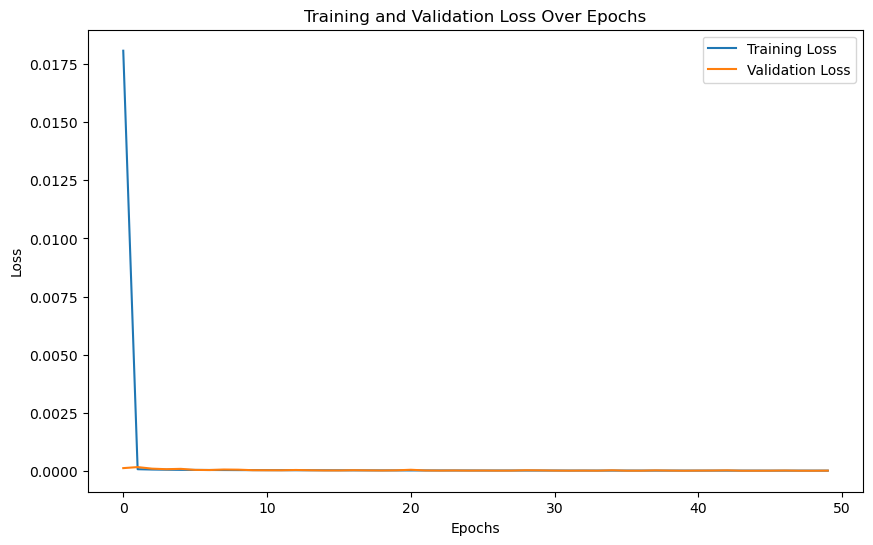

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 76787.1136, Test MSE: 67100.6211, Train MAE: 164.3982, Test MAE: 147.7396
Train RMSE: 277.1049, Test RMSE: 259.0379, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6226, Test MAPE: 0.3306
Train Directional Accuracy: 0.4678, Test Directional Accuracy: 0.4729
Training Time: 48.8679 seconds, Evaluation Time: 0.2232 seconds



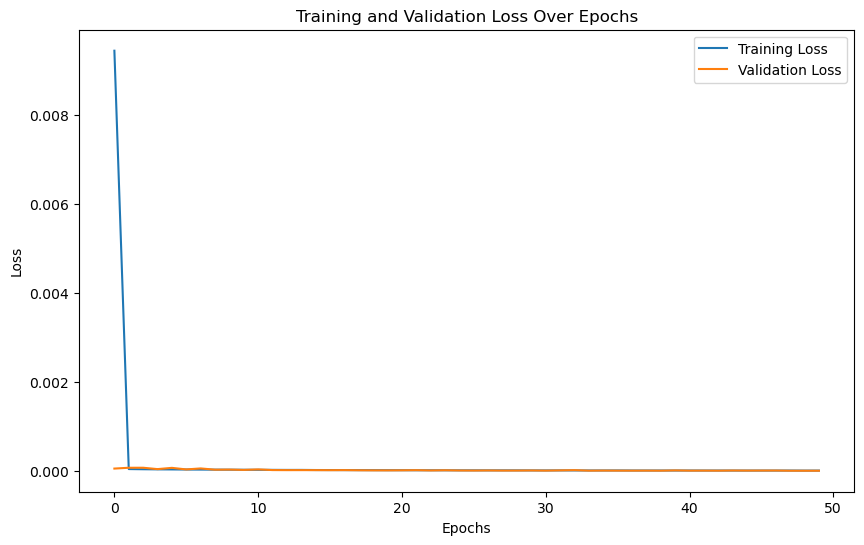

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68931.4611, Test MSE: 63483.1490, Train MAE: 147.2905, Test MAE: 143.5909
Train RMSE: 262.5480, Test RMSE: 251.9586, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4979, Test MAPE: 0.3188
Train Directional Accuracy: 0.4733, Test Directional Accuracy: 0.4722
Training Time: 98.5652 seconds, Evalu

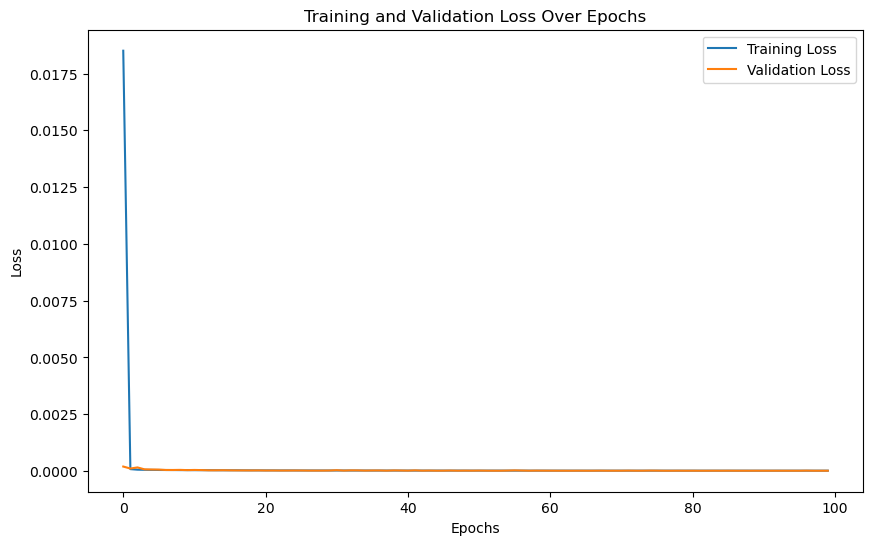

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68028.4547, Test MSE: 62986.3074, Train MAE: 148.0775, Test MAE: 143.5763
Train RMSE: 260.8226, Test RMSE: 250.9707, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5136, Test MAPE: 0.3191
Train Directional Accuracy: 0.4729, Test Directional Accuracy: 0.4713
Training Time: 98.4904 seconds, Evaluation Time: 0.2687 seconds



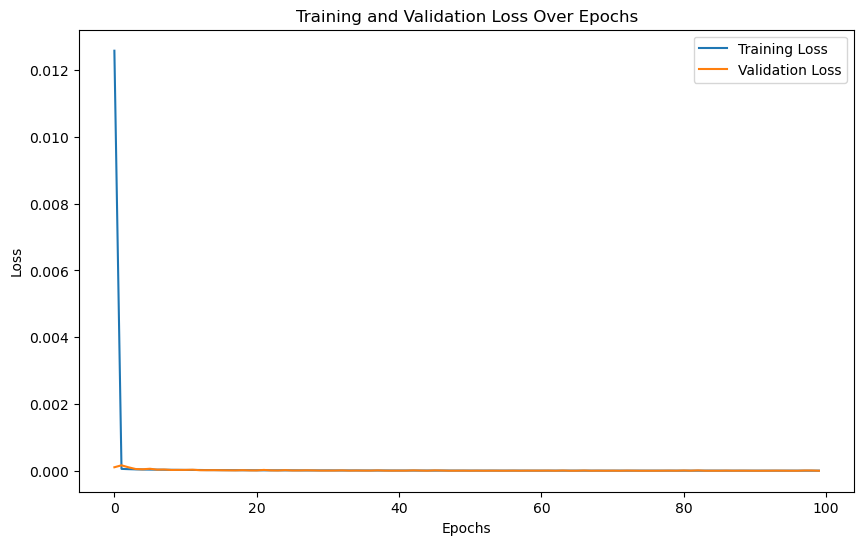

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66960.3952, Test MSE: 61563.6494, Train MAE: 146.6378, Test MAE: 140.2248
Train RMSE: 258.7671, Test RMSE: 248.1202, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5134, Test MAPE: 0.3092
Train Directional Accuracy: 0.4731, Test Directional Accuracy: 0.4720
Training Time: 131.8654 seconds, Eval

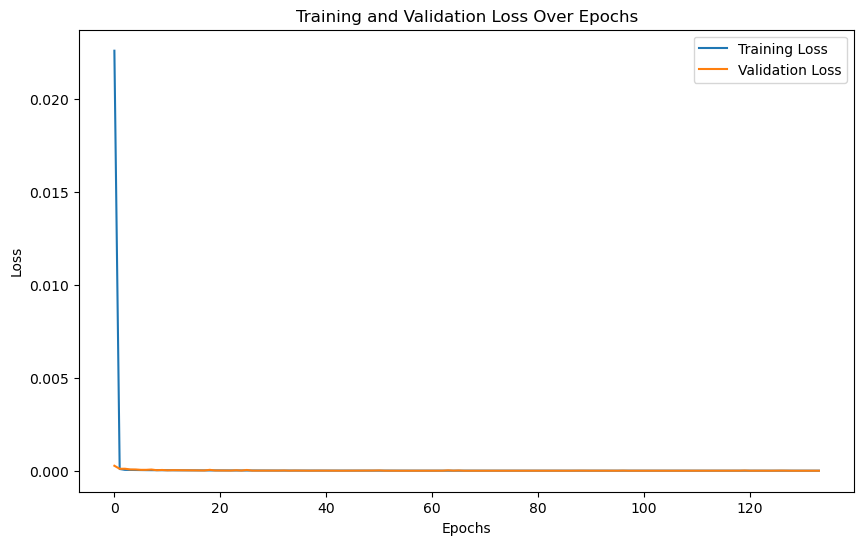

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67172.7004, Test MSE: 68975.9931, Train MAE: 147.2937, Test MAE: 160.1805
Train RMSE: 259.1770, Test RMSE: 262.6328, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4969, Test MAPE: 0.3583
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4696
Training Time: 147.5200 seconds, Evaluation Time: 0.1821 seconds



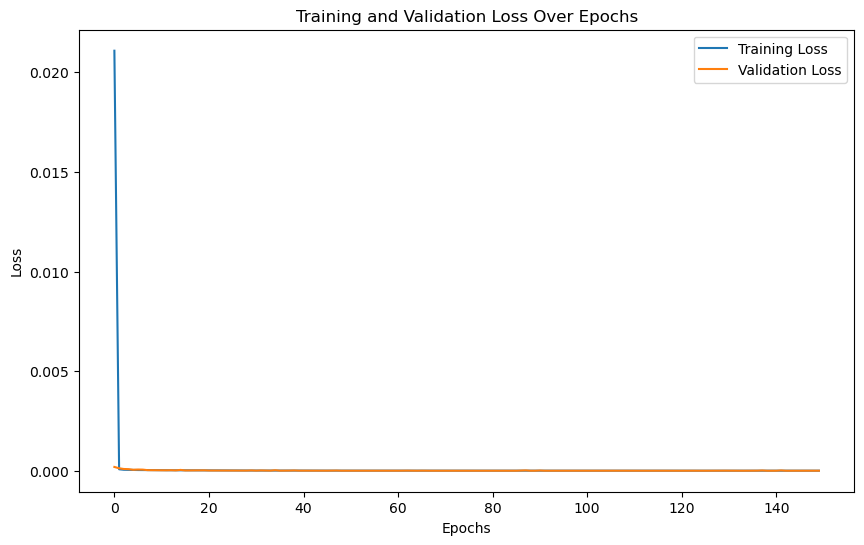

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65140.2956, Test MSE: 61898.9536, Train MAE: 143.7702, Test MAE: 144.8880
Train RMSE: 255.2260, Test RMSE: 248.7950, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4902, Test MAPE: 0.3233
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4679
Training Time: 49.3454 seconds, Evaluatio

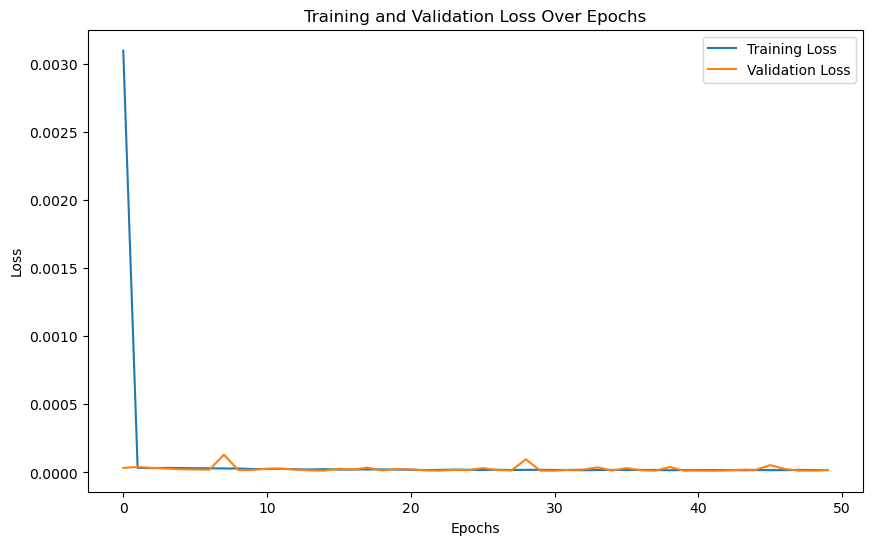

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66273.8613, Test MSE: 62113.7025, Train MAE: 143.7129, Test MAE: 143.1434
Train RMSE: 257.4371, Test RMSE: 249.2262, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4787, Test MAPE: 0.3196
Train Directional Accuracy: 0.4713, Test Directional Accuracy: 0.4683
Training Time: 48.5704 seconds, Evaluation Time: 0.2152 seconds



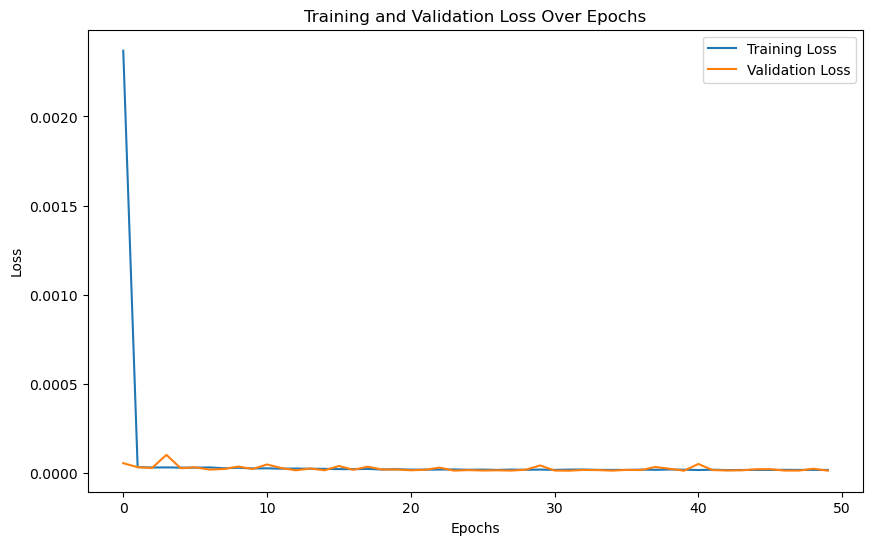

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66752.5363, Test MSE: 60593.8998, Train MAE: 154.3195, Test MAE: 141.8199
Train RMSE: 258.3651, Test RMSE: 246.1583, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5863, Test MAPE: 0.3172
Train Directional Accuracy: 0.4702, Test Directional Accuracy: 0.4704
Training Time: 86.9280 seconds, Evaluat

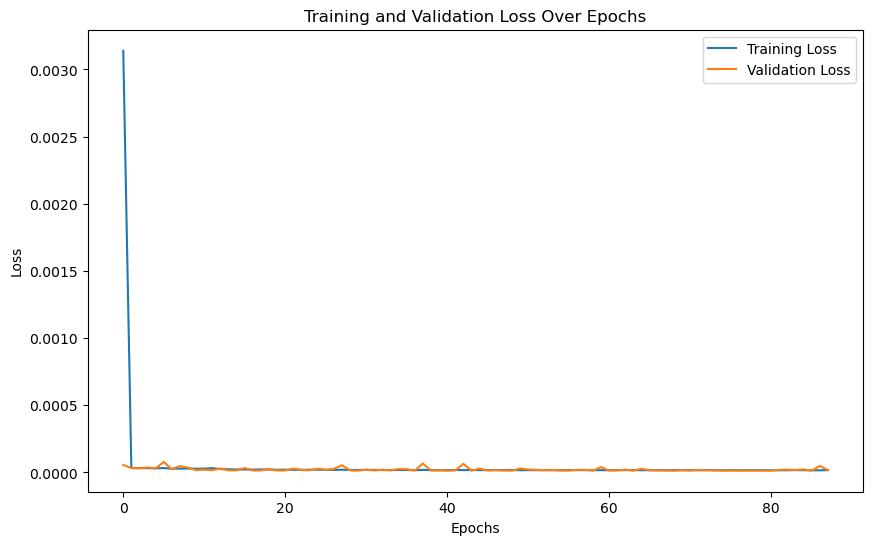

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 69928.3064, Test MSE: 65222.4769, Train MAE: 161.7849, Test MAE: 159.2196
Train RMSE: 264.4396, Test RMSE: 255.3869, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5943, Test MAPE: 0.3700
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4668
Training Time: 98.6749 seconds, Evaluation Time: 0.1551 seconds



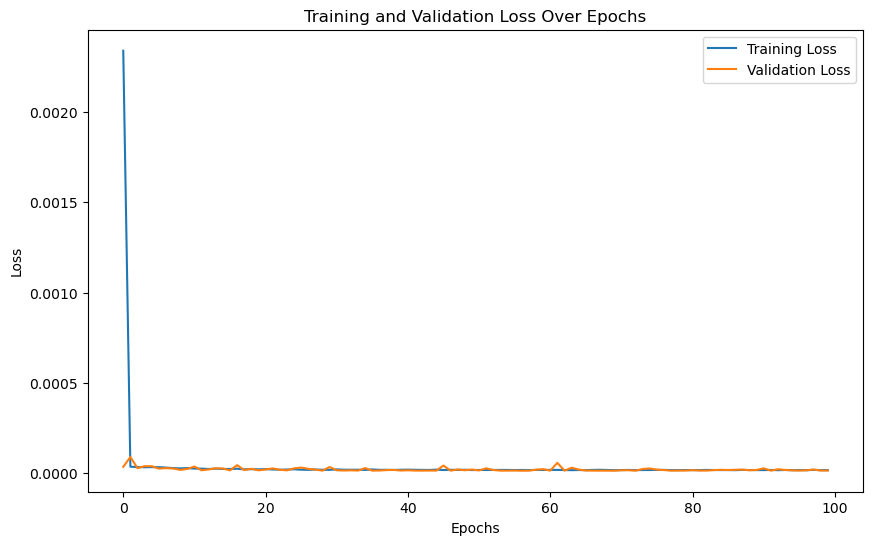

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64942.8177, Test MSE: 60525.0942, Train MAE: 143.1679, Test MAE: 139.5080
Train RMSE: 254.8388, Test RMSE: 246.0185, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4909, Test MAPE: 0.3088
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4684
Training Time: 111.5067 seconds, Evalua

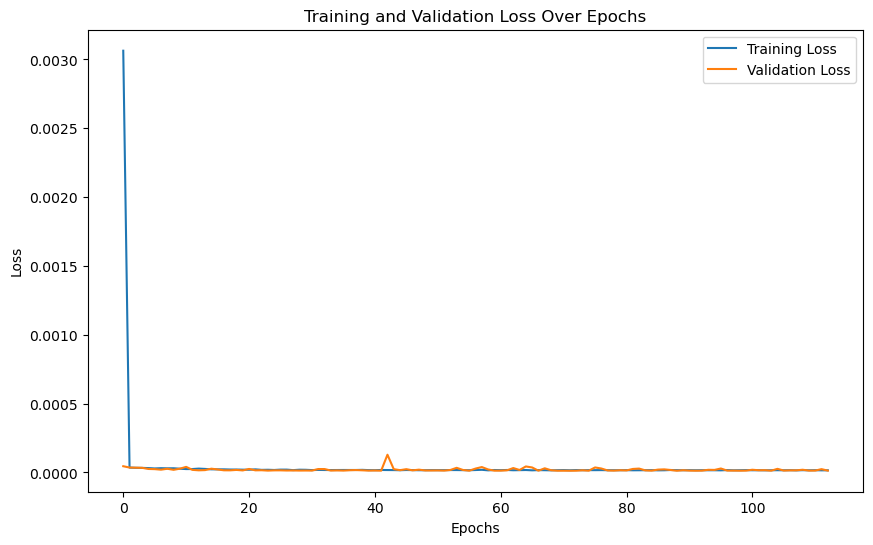

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65682.9441, Test MSE: 68500.2792, Train MAE: 147.1532, Test MAE: 148.8606
Train RMSE: 256.2868, Test RMSE: 261.7256, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5220, Test MAPE: 0.3208
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4693
Training Time: 171.7441 seconds, Evaluation Time: 0.1381 seconds



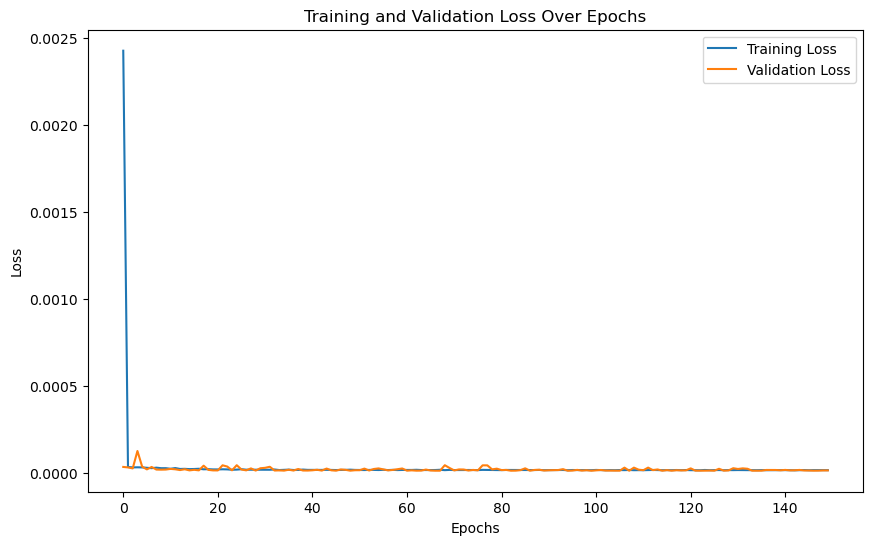

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 81140.9404, Test MSE: 71397.5044, Train MAE: 160.8741, Test MAE: 150.4386
Train RMSE: 284.8525, Test RMSE: 267.2031, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5452, Test MAPE: 0.3314
Train Directional Accuracy: 0.4668, Test Directional Accuracy: 0.4733
Training Time: 57.2306 seconds, Evaluat

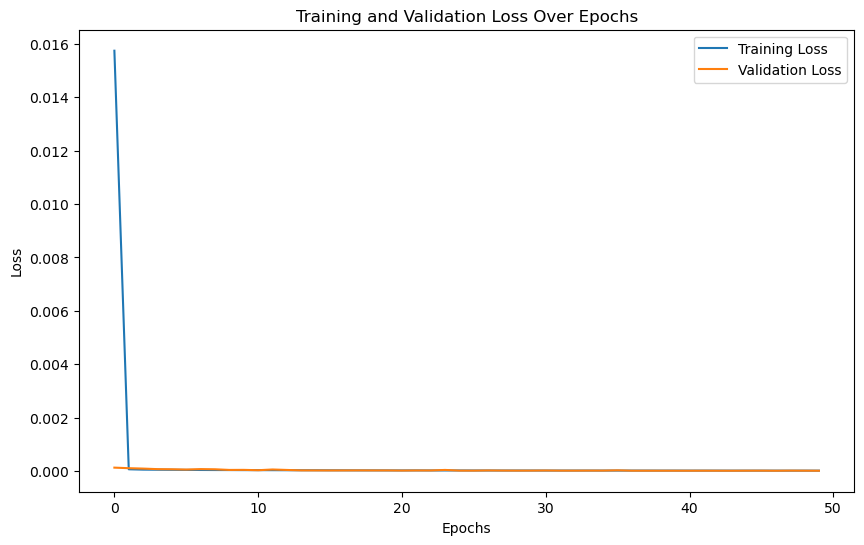

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 76178.1800, Test MSE: 68794.9834, Train MAE: 158.2502, Test MAE: 148.5465
Train RMSE: 276.0039, Test RMSE: 262.2880, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5668, Test MAPE: 0.3285
Train Directional Accuracy: 0.4673, Test Directional Accuracy: 0.4713
Training Time: 56.6453 seconds, Evaluation Time: 0.1397 seconds



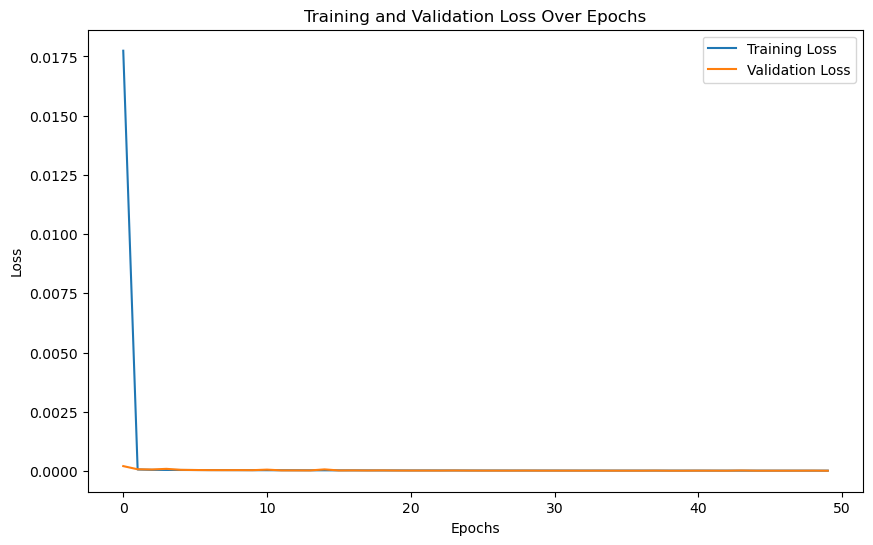

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65920.3971, Test MSE: 61734.9100, Train MAE: 142.1570, Test MAE: 140.8649
Train RMSE: 256.7497, Test RMSE: 248.4651, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4750, Test MAPE: 0.3113
Train Directional Accuracy: 0.4718, Test Directional Accuracy: 0.4716
Training Time: 110.0847 seconds, Eval

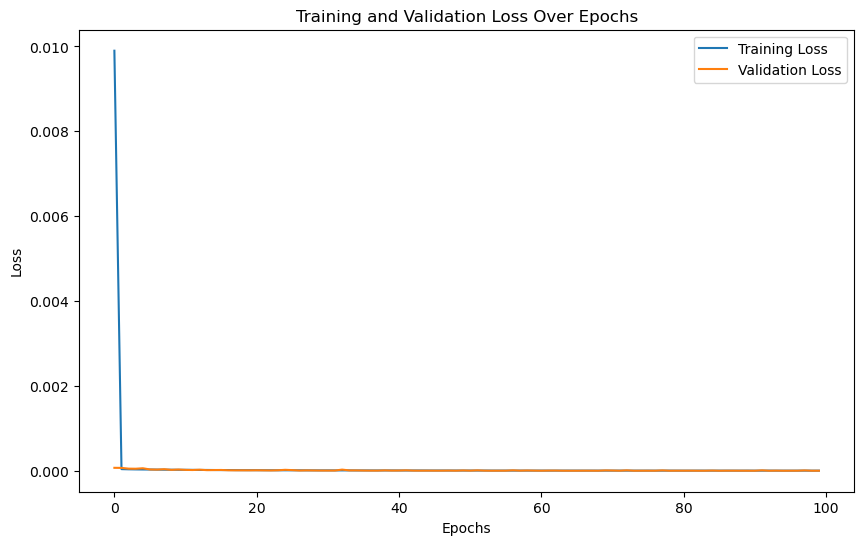

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66459.8654, Test MSE: 63735.2046, Train MAE: 145.3432, Test MAE: 145.6192
Train RMSE: 257.7981, Test RMSE: 252.4583, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5012, Test MAPE: 0.3228
Train Directional Accuracy: 0.4719, Test Directional Accuracy: 0.4692
Training Time: 108.0606 seconds, Evaluation Time: 0.1477 seconds



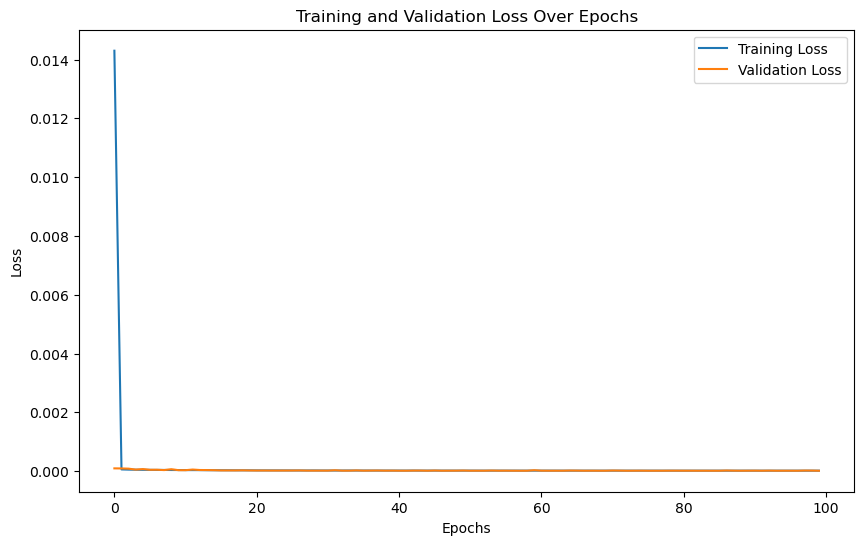

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65704.0126, Test MSE: 61033.5338, Train MAE: 143.1880, Test MAE: 140.0210
Train RMSE: 256.3279, Test RMSE: 247.0497, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4843, Test MAPE: 0.3081
Train Directional Accuracy: 0.4696, Test Directional Accuracy: 0.4699
Training Time: 156.9822 seconds, Eval

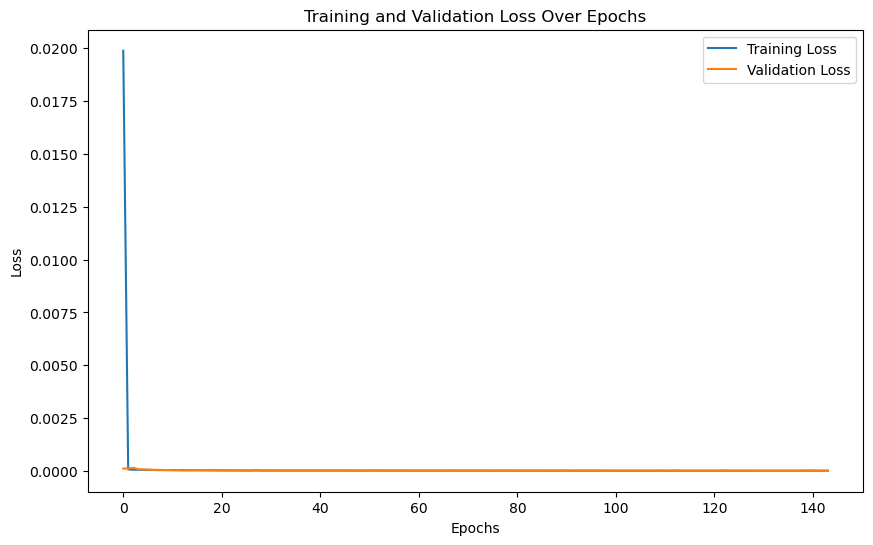

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67892.9549, Test MSE: 71881.7437, Train MAE: 152.4595, Test MAE: 158.4631
Train RMSE: 260.5628, Test RMSE: 268.1077, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5595, Test MAPE: 0.3416
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4677
Training Time: 164.8846 seconds, Evaluation Time: 0.1371 seconds



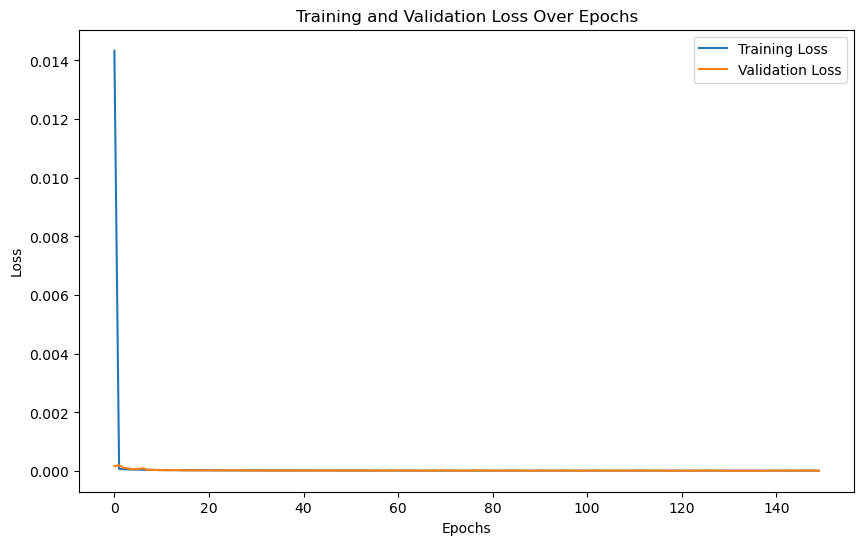

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66480.4542, Test MSE: 61075.9319, Train MAE: 143.7198, Test MAE: 140.8799
Train RMSE: 257.8380, Test RMSE: 247.1355, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4807, Test MAPE: 0.3099
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4695
Training Time: 55.0298 seconds, Evaluatio

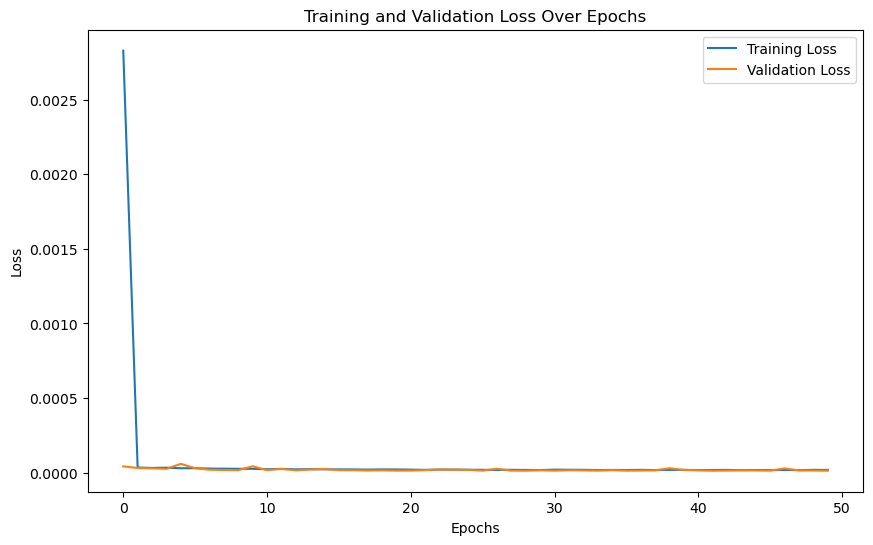

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68720.2012, Test MSE: 69165.3935, Train MAE: 163.8562, Test MAE: 152.9179
Train RMSE: 262.1454, Test RMSE: 262.9931, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6811, Test MAPE: 0.3344
Train Directional Accuracy: 0.4727, Test Directional Accuracy: 0.4699
Training Time: 56.0304 seconds, Evaluation Time: 0.1391 seconds



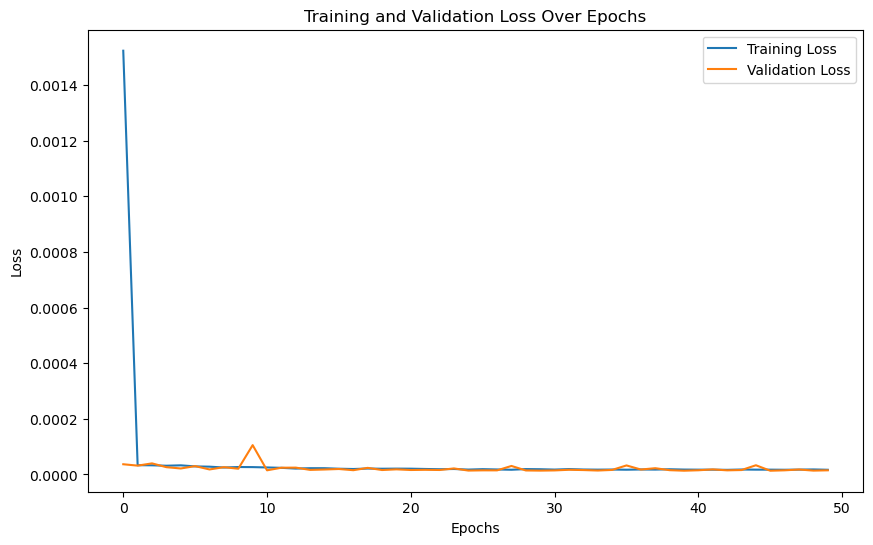

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64582.7552, Test MSE: 60226.8950, Train MAE: 141.1447, Test MAE: 137.9816
Train RMSE: 254.1314, Test RMSE: 245.4117, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4714, Test MAPE: 0.3032
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4687
Training Time: 111.0301 seconds, Evalua

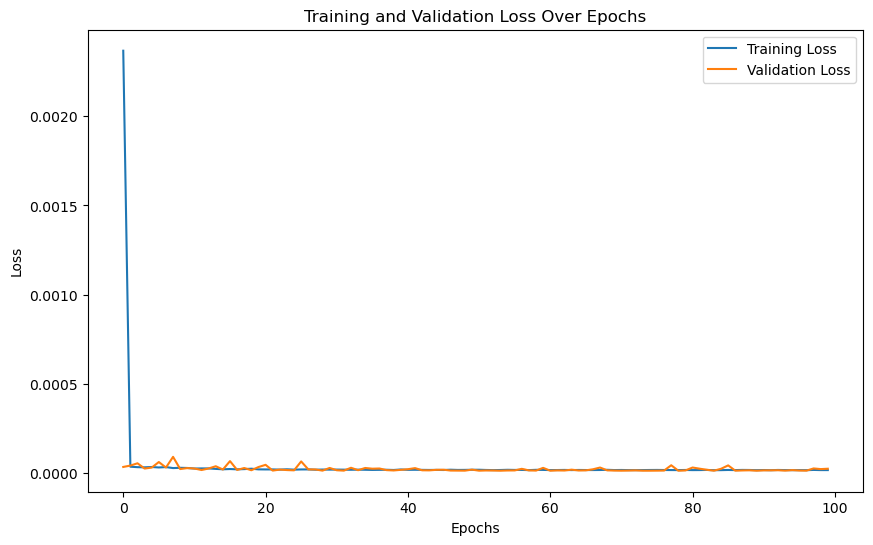

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67589.9887, Test MSE: 72053.6333, Train MAE: 148.6731, Test MAE: 160.6049
Train RMSE: 259.9807, Test RMSE: 268.4281, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5038, Test MAPE: 0.3521
Train Directional Accuracy: 0.4706, Test Directional Accuracy: 0.4652
Training Time: 118.0451 seconds, Evaluation Time: 0.1677 seconds



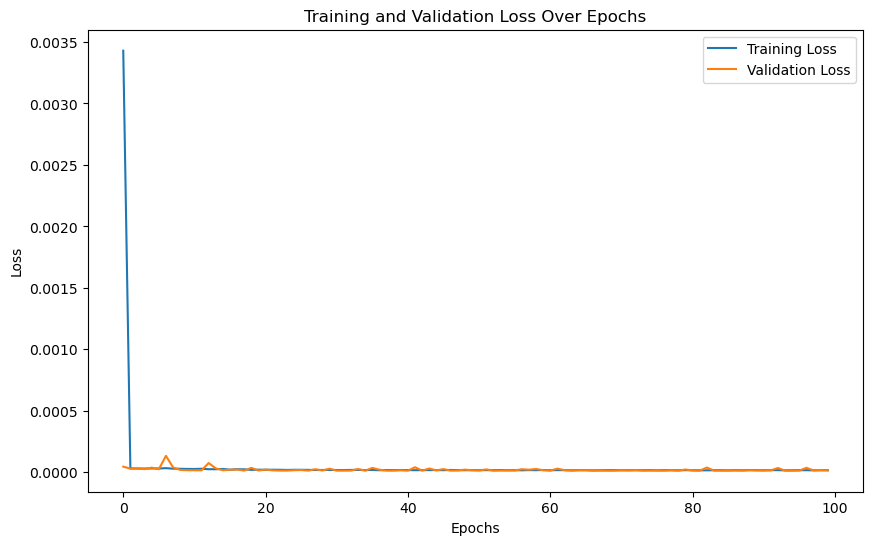

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64617.1541, Test MSE: 60554.4195, Train MAE: 140.5107, Test MAE: 138.5624
Train RMSE: 254.1990, Test RMSE: 246.0781, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4680, Test MAPE: 0.3050
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4691
Training Time: 96.7790 seconds, Evaluat

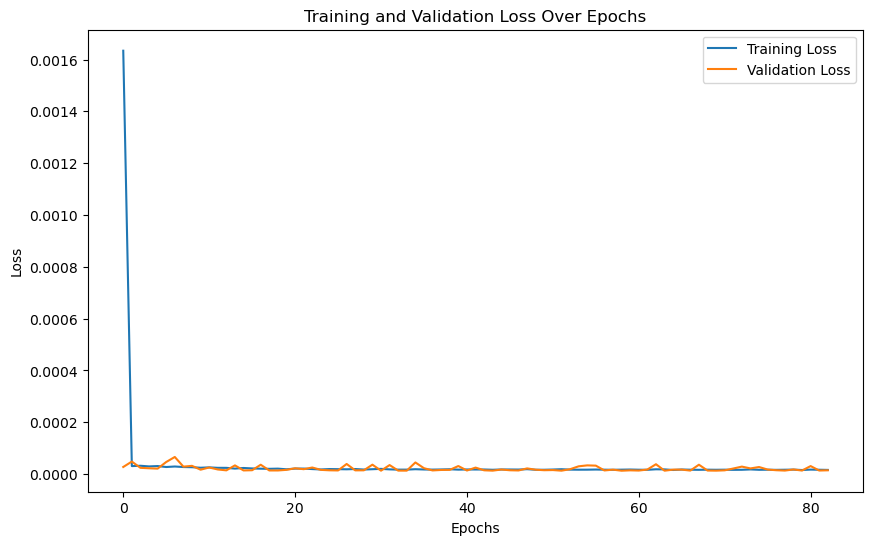

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 63649.4277, Test MSE: 64067.1168, Train MAE: 140.1286, Test MAE: 143.1030
Train RMSE: 252.2884, Test RMSE: 253.1148, Train R2: 0.9998, Test R2: 0.9997
Train MAPE: 0.4669, Test MAPE: 0.3116
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4685
Training Time: 170.9204 seconds, Evaluation Time: 0.1411 seconds



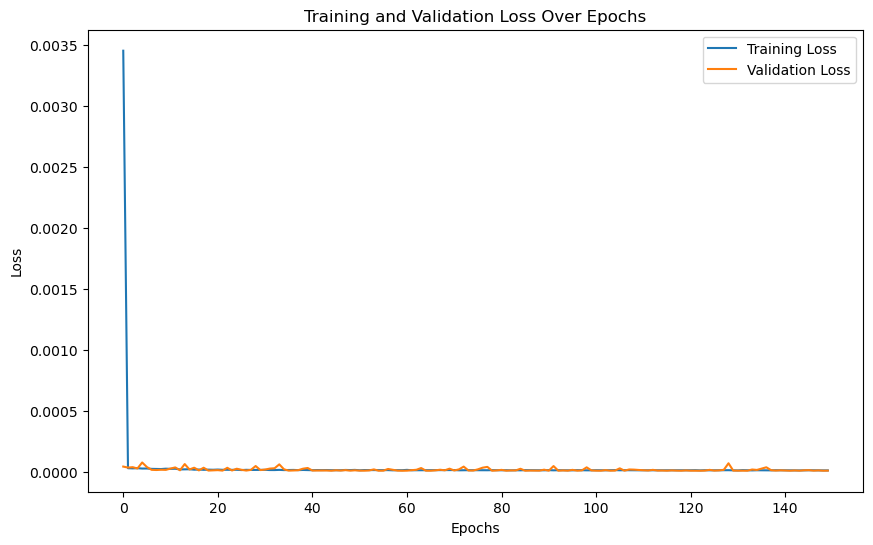

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 80362.6386, Test MSE: 69142.4394, Train MAE: 179.8921, Test MAE: 156.0700
Train RMSE: 283.4830, Test RMSE: 262.9495, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.7527, Test MAPE: 0.3562
Train Directional Accuracy: 0.4674, Test Directional Accuracy: 0.4728
Training Time: 57.0422 seconds, Evalu

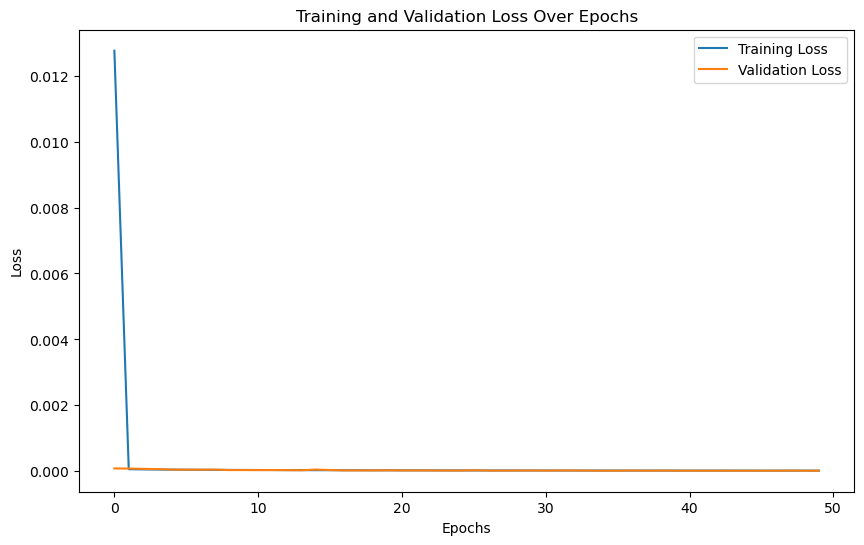

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 77673.9543, Test MSE: 68426.0341, Train MAE: 158.5428, Test MAE: 148.2990
Train RMSE: 278.7005, Test RMSE: 261.5837, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5455, Test MAPE: 0.3321
Train Directional Accuracy: 0.4676, Test Directional Accuracy: 0.4733
Training Time: 58.5621 seconds, Evaluation Time: 0.1637 seconds



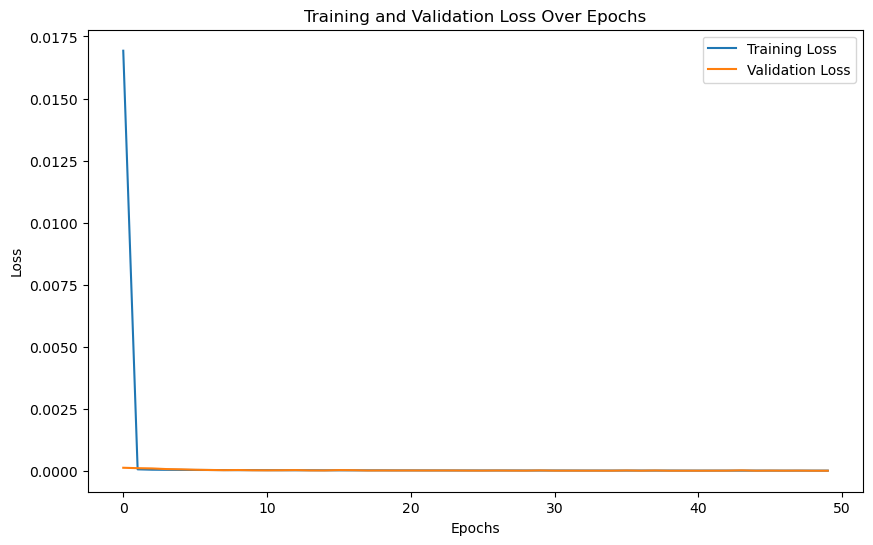

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67807.0878, Test MSE: 63144.9316, Train MAE: 150.0678, Test MAE: 143.9203
Train RMSE: 260.3979, Test RMSE: 251.2866, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5353, Test MAPE: 0.3202
Train Directional Accuracy: 0.4740, Test Directional Accuracy: 0.4718
Training Time: 112.5672 seconds, Ev

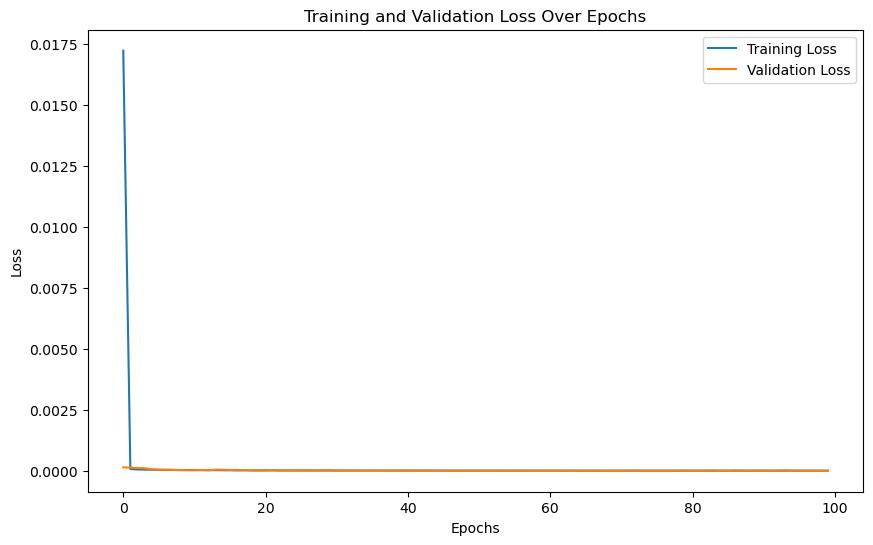

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68162.7066, Test MSE: 67073.9101, Train MAE: 150.1154, Test MAE: 148.6172
Train RMSE: 261.0799, Test RMSE: 258.9863, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5388, Test MAPE: 0.3232
Train Directional Accuracy: 0.4718, Test Directional Accuracy: 0.4714
Training Time: 123.9739 seconds, Evaluation Time: 0.1592 seconds



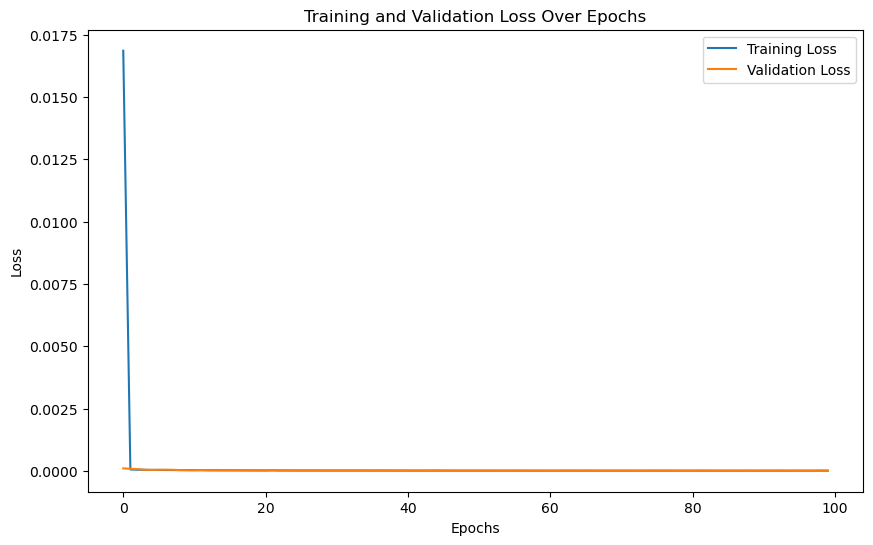

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65838.1839, Test MSE: 61025.3152, Train MAE: 142.8625, Test MAE: 140.0107
Train RMSE: 256.5895, Test RMSE: 247.0330, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4805, Test MAPE: 0.3083
Train Directional Accuracy: 0.4707, Test Directional Accuracy: 0.4695
Training Time: 196.3775 seconds, Ev

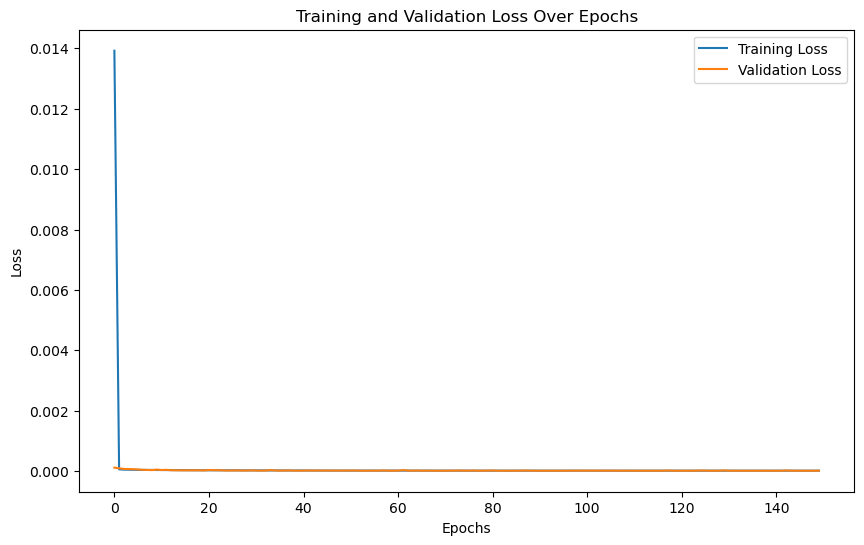

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 71760.4027, Test MSE: 74615.5065, Train MAE: 167.6201, Test MAE: 181.4410
Train RMSE: 267.8813, Test RMSE: 273.1584, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.6347, Test MAPE: 0.4257
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4688
Training Time: 190.1368 seconds, Evaluation Time: 0.1562 seconds



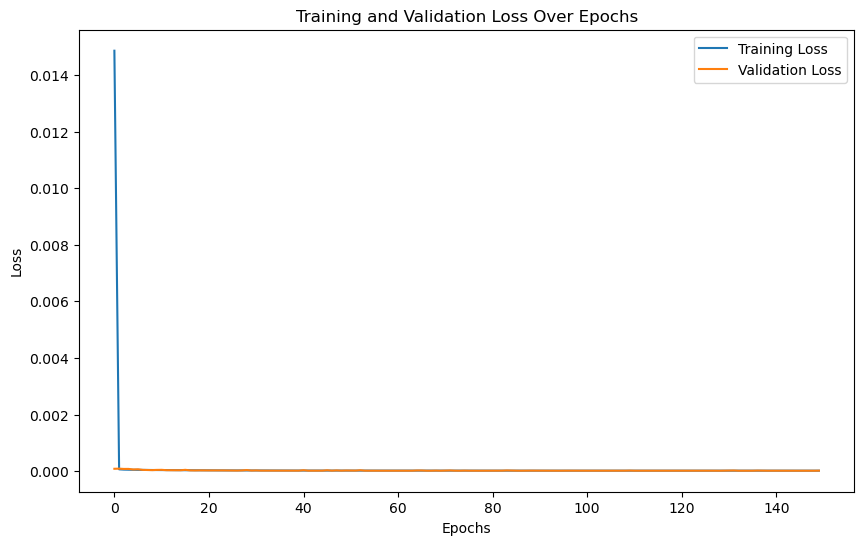

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66607.6386, Test MSE: 61096.9409, Train MAE: 155.6964, Test MAE: 142.8281
Train RMSE: 258.0846, Test RMSE: 247.1780, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6241, Test MAPE: 0.3201
Train Directional Accuracy: 0.4692, Test Directional Accuracy: 0.4695
Training Time: 62.9491 seconds, Evaluat

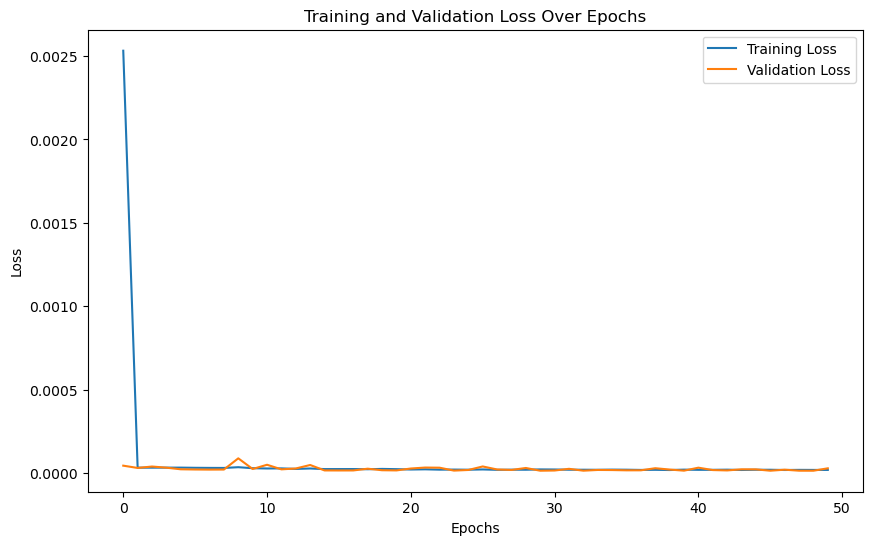

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 101468.4848, Test MSE: 113620.1819, Train MAE: 204.8763, Test MAE: 255.8950
Train RMSE: 318.5412, Test RMSE: 337.0759, Train R2: 0.9996, Test R2: 0.9995
Train MAPE: 0.6710, Test MAPE: 0.6161
Train Directional Accuracy: 0.4696, Test Directional Accuracy: 0.4666
Training Time: 60.8575 seconds, Evaluation Time: 0.1487 seconds



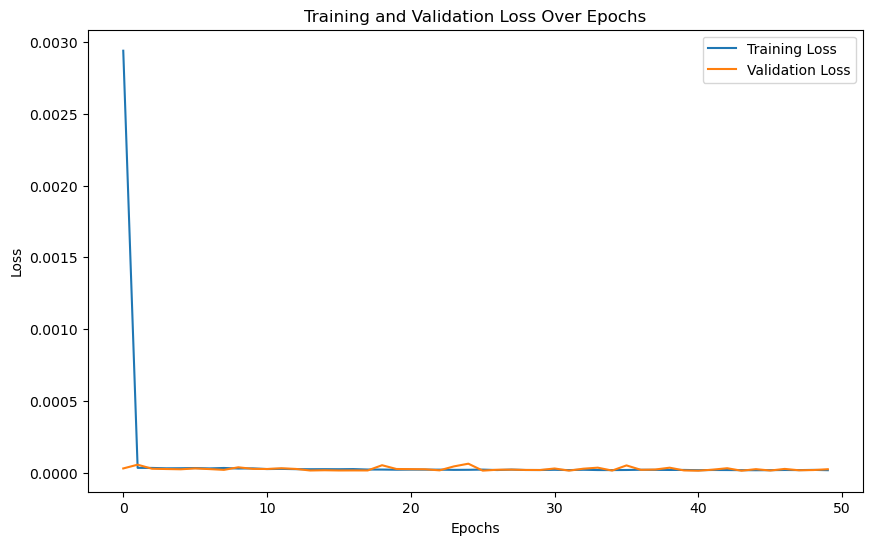

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67376.6338, Test MSE: 60997.5927, Train MAE: 153.1514, Test MAE: 140.5788
Train RMSE: 259.5701, Test RMSE: 246.9769, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5894, Test MAPE: 0.3099
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4707
Training Time: 101.8155 seconds, Eval

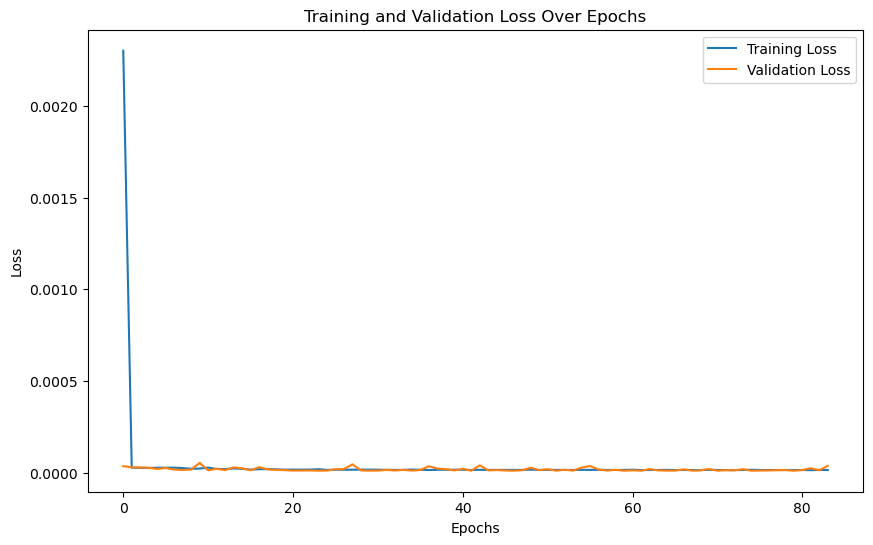

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74814.7743, Test MSE: 89959.6956, Train MAE: 165.2428, Test MAE: 212.4157
Train RMSE: 273.5229, Test RMSE: 299.9328, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5469, Test MAPE: 0.5001
Train Directional Accuracy: 0.4696, Test Directional Accuracy: 0.4683
Training Time: 120.1343 seconds, Evaluation Time: 0.1506 seconds



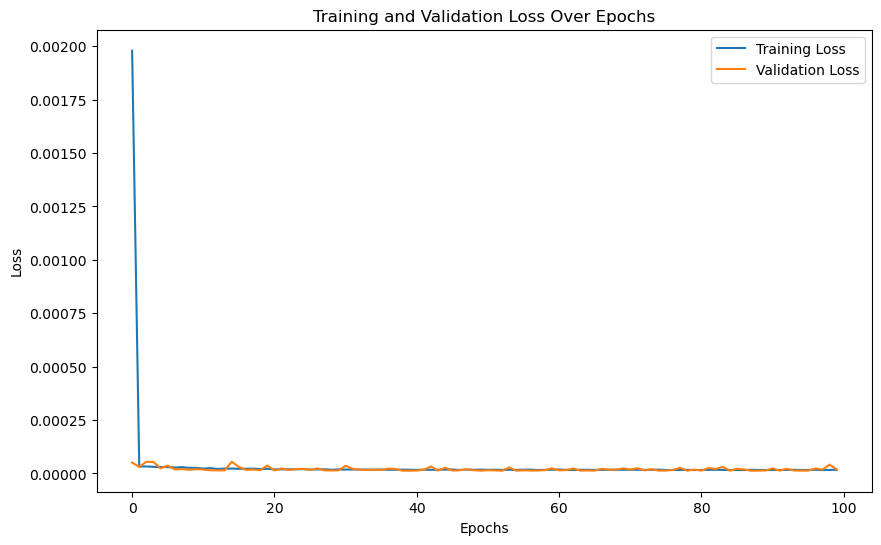

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66381.8052, Test MSE: 60482.6010, Train MAE: 148.3670, Test MAE: 139.4054
Train RMSE: 257.6467, Test RMSE: 245.9321, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5323, Test MAPE: 0.3072
Train Directional Accuracy: 0.4704, Test Directional Accuracy: 0.4695
Training Time: 83.8466 seconds, Evalu

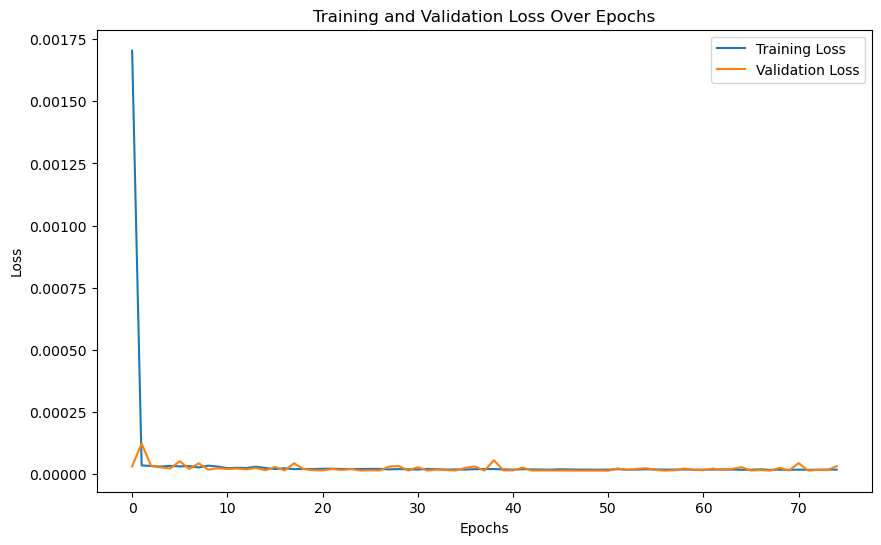

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 63982.4745, Test MSE: 63953.4915, Train MAE: 140.1657, Test MAE: 142.8030
Train RMSE: 252.9476, Test RMSE: 252.8903, Train R2: 0.9998, Test R2: 0.9997
Train MAPE: 0.4684, Test MAPE: 0.3110
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4693
Training Time: 163.2359 seconds, Evaluation Time: 0.1402 seconds



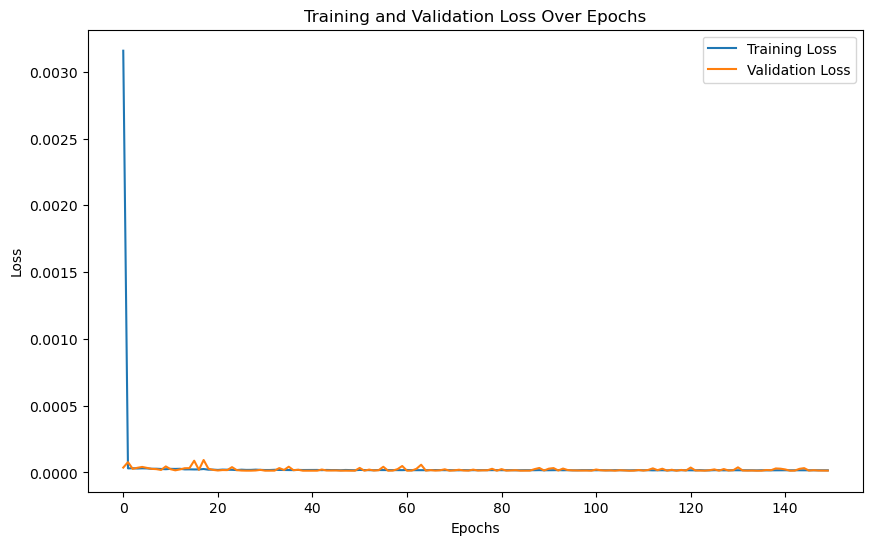

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 78680.7277, Test MSE: 68824.6854, Train MAE: 157.1447, Test MAE: 146.5326
Train RMSE: 280.5009, Test RMSE: 262.3446, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5275, Test MAPE: 0.3235
Train Directional Accuracy: 0.4669, Test Directional Accuracy: 0.4741
Training Time: 57.0772 seconds, Evaluat

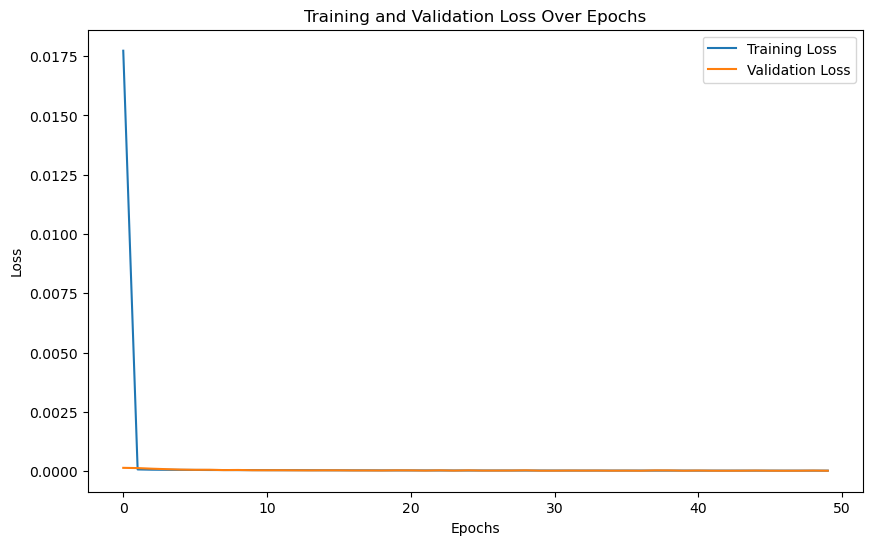

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74296.0265, Test MSE: 68773.4714, Train MAE: 155.3090, Test MAE: 152.7162
Train RMSE: 272.5730, Test RMSE: 262.2470, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5354, Test MAPE: 0.3421
Train Directional Accuracy: 0.4665, Test Directional Accuracy: 0.4692
Training Time: 56.0301 seconds, Evaluation Time: 0.1644 seconds



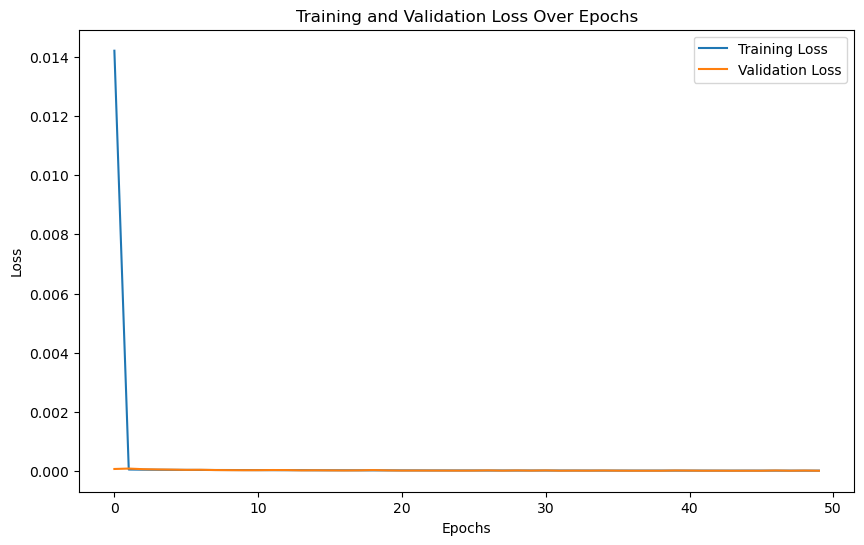

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67716.4409, Test MSE: 62147.6352, Train MAE: 155.0865, Test MAE: 144.1960
Train RMSE: 260.2238, Test RMSE: 249.2943, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5862, Test MAPE: 0.3228
Train Directional Accuracy: 0.4732, Test Directional Accuracy: 0.4714
Training Time: 116.2007 seconds, Eval

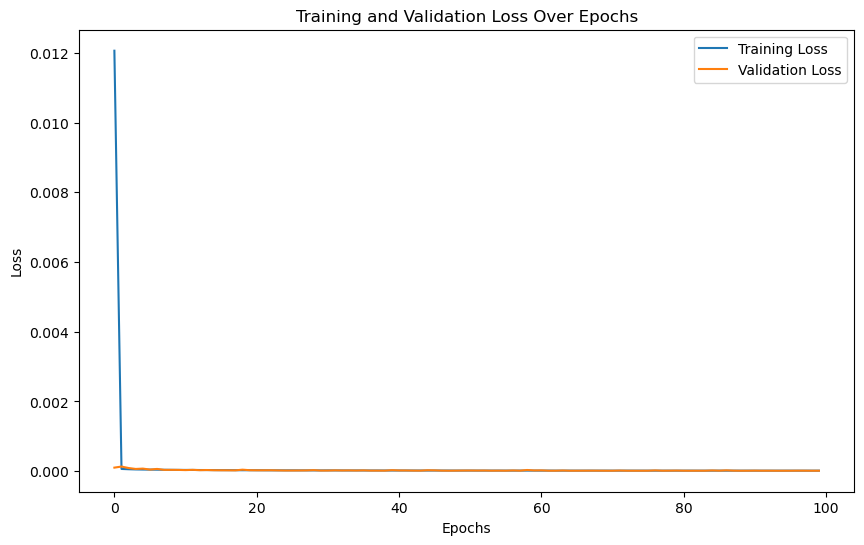

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67475.9637, Test MSE: 62354.5841, Train MAE: 145.2719, Test MAE: 141.3318
Train RMSE: 259.7614, Test RMSE: 249.7090, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4931, Test MAPE: 0.3114
Train Directional Accuracy: 0.4738, Test Directional Accuracy: 0.4722
Training Time: 113.9734 seconds, Evaluation Time: 0.1422 seconds



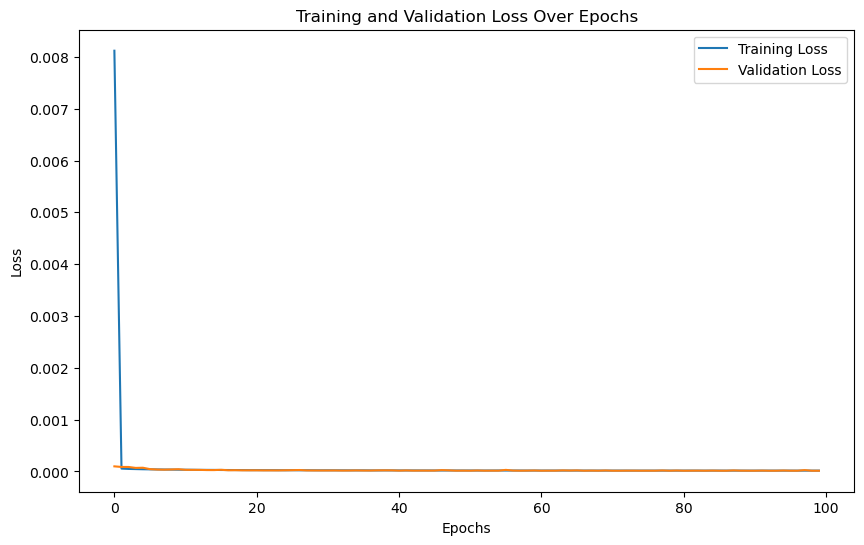

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65966.5947, Test MSE: 60793.2403, Train MAE: 146.7475, Test MAE: 140.1007
Train RMSE: 256.8396, Test RMSE: 246.5629, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5097, Test MAPE: 0.3102
Train Directional Accuracy: 0.4683, Test Directional Accuracy: 0.4692
Training Time: 175.1855 seconds, Eval

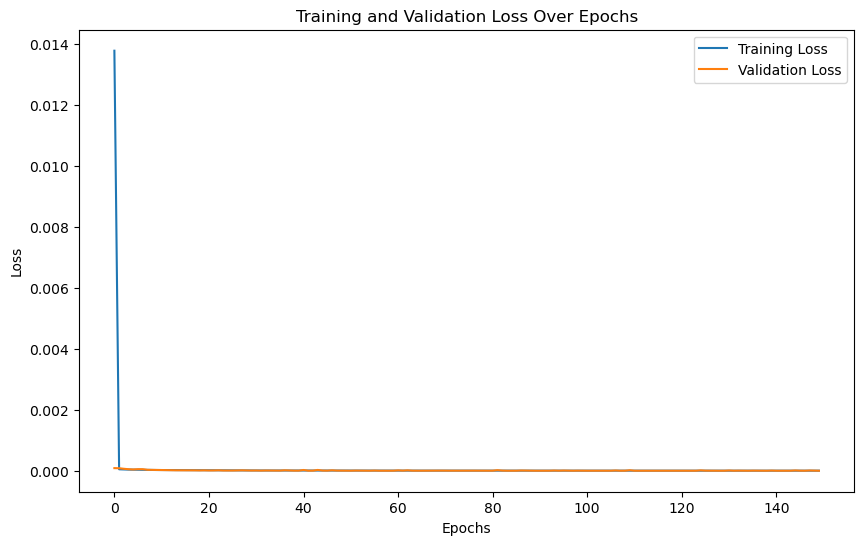

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64790.3847, Test MSE: 61612.4137, Train MAE: 142.6411, Test MAE: 141.1444
Train RMSE: 254.5396, Test RMSE: 248.2185, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4892, Test MAPE: 0.3106
Train Directional Accuracy: 0.4687, Test Directional Accuracy: 0.4699
Training Time: 194.8920 seconds, Evaluation Time: 0.1827 seconds



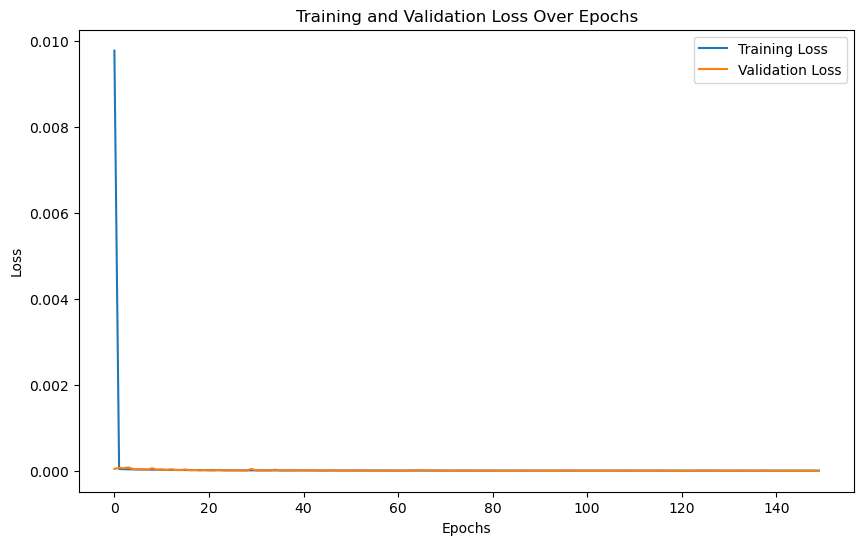

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65360.3420, Test MSE: 61210.8530, Train MAE: 142.2088, Test MAE: 140.8270
Train RMSE: 255.6567, Test RMSE: 247.4083, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4820, Test MAPE: 0.3103
Train Directional Accuracy: 0.4687, Test Directional Accuracy: 0.4697
Training Time: 60.1203 seconds, Evaluatio

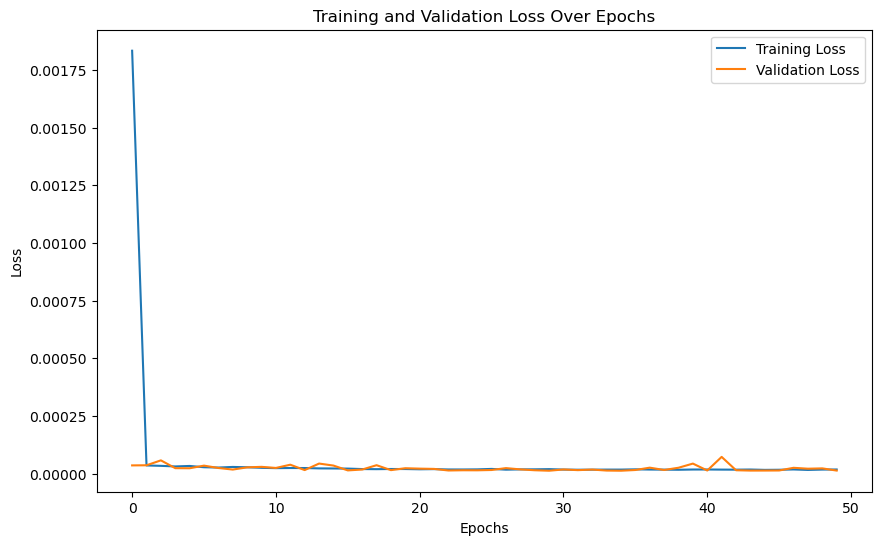

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73353.1090, Test MSE: 91691.3873, Train MAE: 157.2993, Test MAE: 197.0036
Train RMSE: 270.8378, Test RMSE: 302.8059, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5104, Test MAPE: 0.4342
Train Directional Accuracy: 0.4696, Test Directional Accuracy: 0.4679
Training Time: 60.9913 seconds, Evaluation Time: 0.1535 seconds



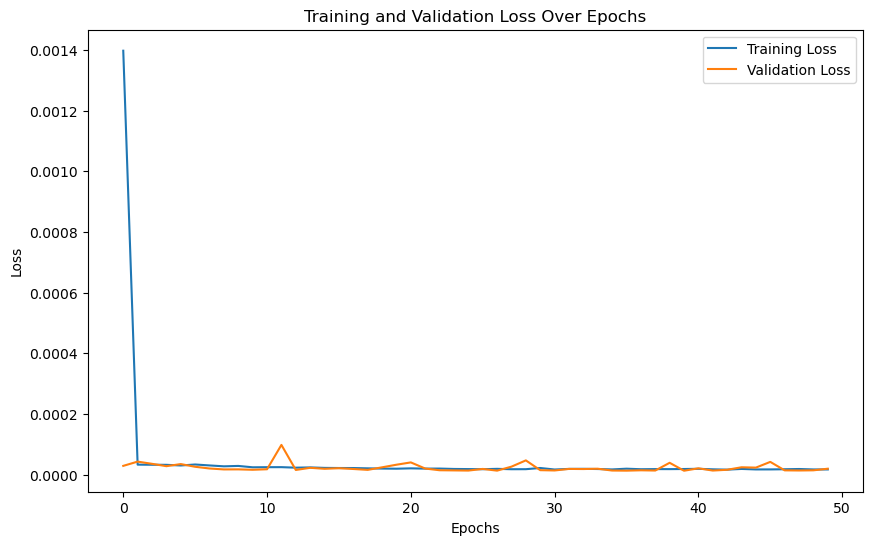

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66277.8872, Test MSE: 61158.7349, Train MAE: 144.2080, Test MAE: 140.4298
Train RMSE: 257.4449, Test RMSE: 247.3029, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4855, Test MAPE: 0.3087
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4681
Training Time: 72.2312 seconds, Evaluat

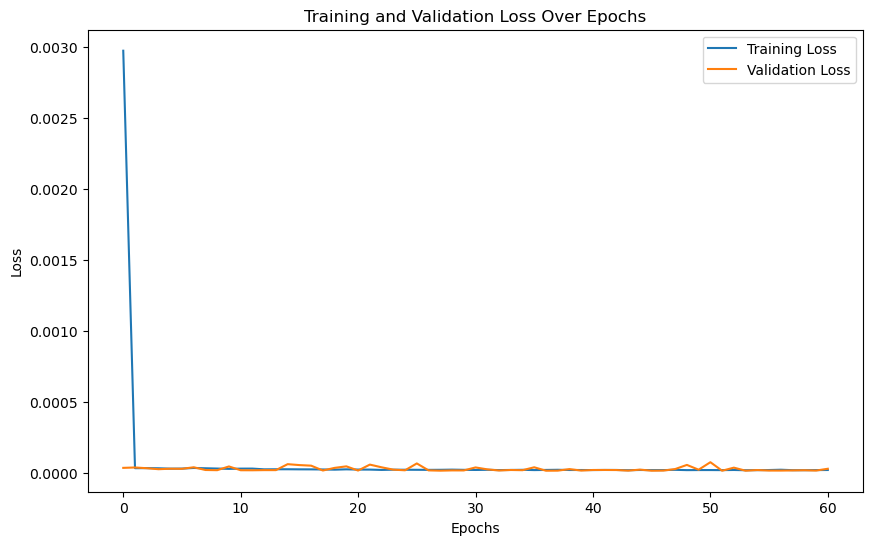

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72306.1227, Test MSE: 81389.9737, Train MAE: 166.9473, Test MAE: 187.2713
Train RMSE: 268.8980, Test RMSE: 285.2893, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.6141, Test MAPE: 0.4290
Train Directional Accuracy: 0.4707, Test Directional Accuracy: 0.4703
Training Time: 112.4608 seconds, Evaluation Time: 0.1431 seconds



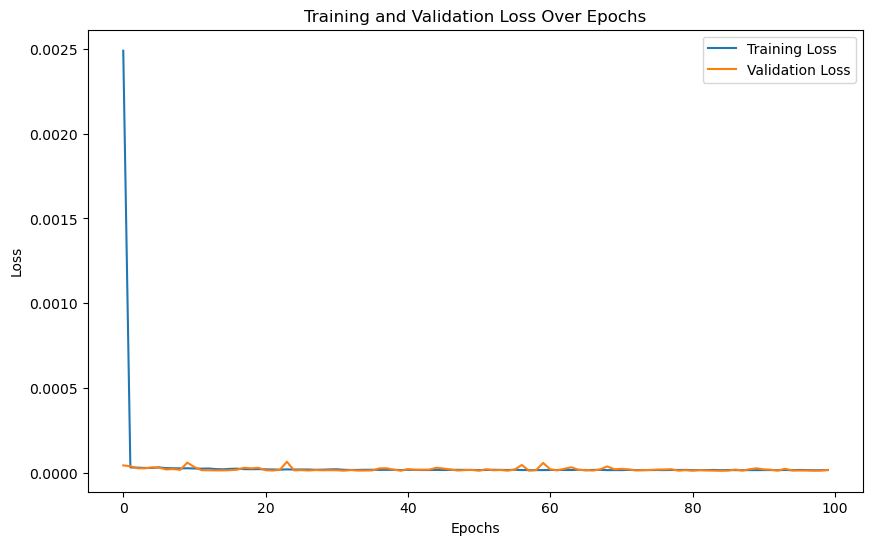

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65451.9846, Test MSE: 60649.7904, Train MAE: 144.6528, Test MAE: 139.0101
Train RMSE: 255.8359, Test RMSE: 246.2718, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5016, Test MAPE: 0.3058
Train Directional Accuracy: 0.4702, Test Directional Accuracy: 0.4666
Training Time: 94.4221 seconds, Evaluat

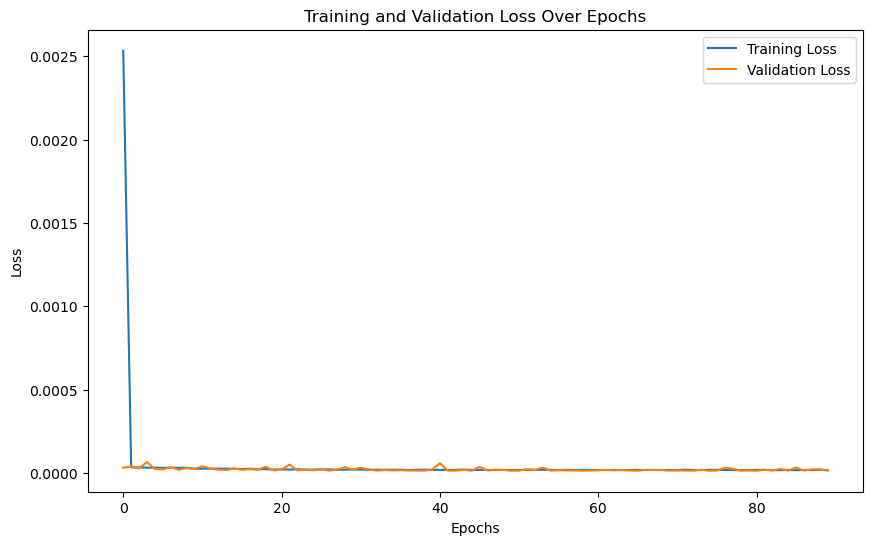

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 97771.5444, Test MSE: 132604.6440, Train MAE: 219.7535, Test MAE: 278.2192
Train RMSE: 312.6844, Test RMSE: 364.1492, Train R2: 0.9996, Test R2: 0.9994
Train MAPE: 0.8446, Test MAPE: 0.6549
Train Directional Accuracy: 0.4677, Test Directional Accuracy: 0.4687
Training Time: 156.6141 seconds, Evaluation Time: 0.1439 seconds



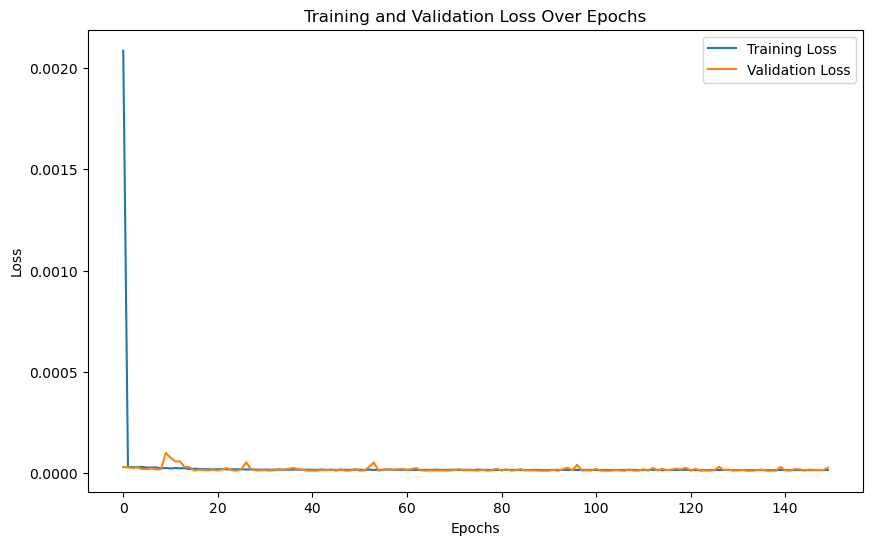

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 75352.2393, Test MSE: 68347.1238, Train MAE: 156.3717, Test MAE: 149.1049
Train RMSE: 274.5036, Test RMSE: 261.4328, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5390, Test MAPE: 0.3320
Train Directional Accuracy: 0.4670, Test Directional Accuracy: 0.4729
Training Time: 53.4252 seconds, Evalu

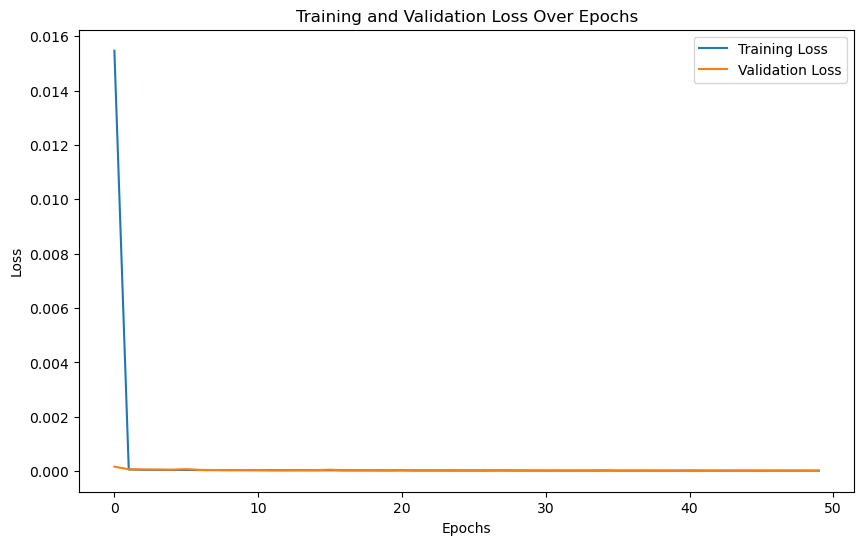

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 82684.9527, Test MSE: 71476.9424, Train MAE: 180.8914, Test MAE: 163.4659
Train RMSE: 287.5499, Test RMSE: 267.3517, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.7054, Test MAPE: 0.3791
Train Directional Accuracy: 0.4679, Test Directional Accuracy: 0.4742
Training Time: 61.4006 seconds, Evaluation Time: 0.1491 seconds



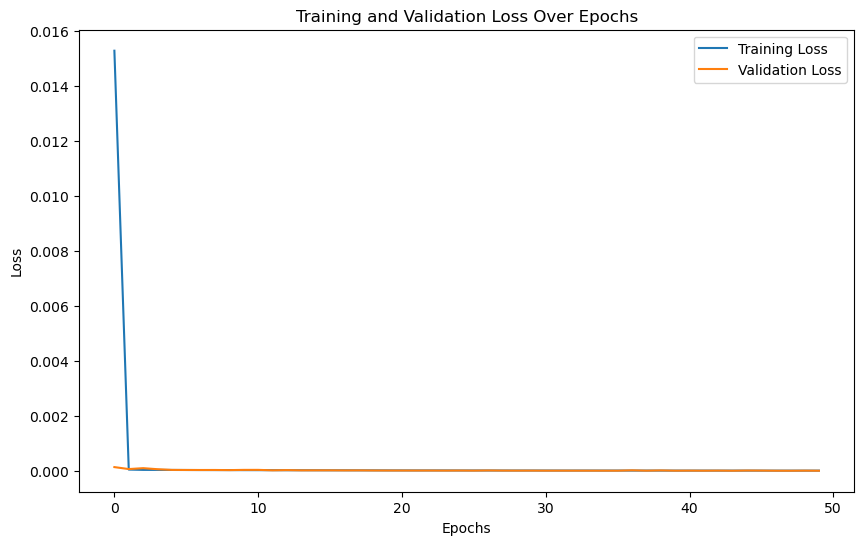

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65860.5499, Test MSE: 61875.0203, Train MAE: 142.2823, Test MAE: 140.1569
Train RMSE: 256.6331, Test RMSE: 248.7469, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4761, Test MAPE: 0.3079
Train Directional Accuracy: 0.4712, Test Directional Accuracy: 0.4710
Training Time: 117.3777 seconds, Ev

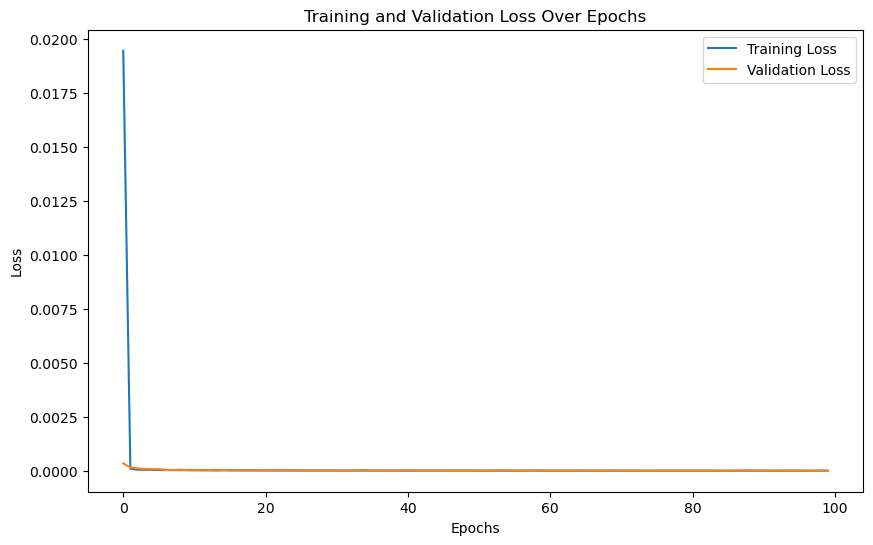

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 71138.1003, Test MSE: 68166.9495, Train MAE: 151.7635, Test MAE: 151.5104
Train RMSE: 266.7173, Test RMSE: 261.0880, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5209, Test MAPE: 0.3325
Train Directional Accuracy: 0.4725, Test Directional Accuracy: 0.4691
Training Time: 119.9327 seconds, Evaluation Time: 0.1466 seconds



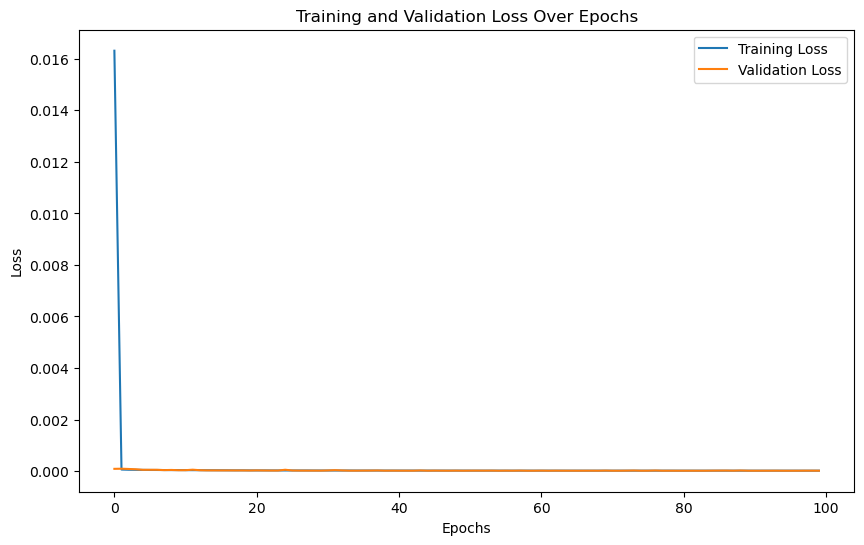

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65405.8071, Test MSE: 60839.7070, Train MAE: 141.5724, Test MAE: 139.4706
Train RMSE: 255.7456, Test RMSE: 246.6571, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4719, Test MAPE: 0.3065
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4687
Training Time: 173.1177 seconds, Ev

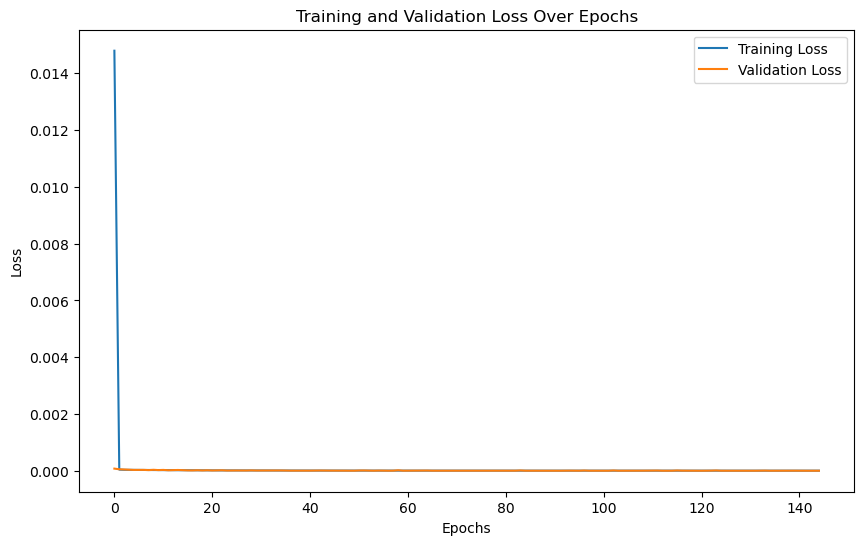

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64980.1481, Test MSE: 62207.8098, Train MAE: 141.7559, Test MAE: 141.3528
Train RMSE: 254.9120, Test RMSE: 249.4149, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4782, Test MAPE: 0.3087
Train Directional Accuracy: 0.4671, Test Directional Accuracy: 0.4684
Training Time: 185.0532 seconds, Evaluation Time: 0.1336 seconds



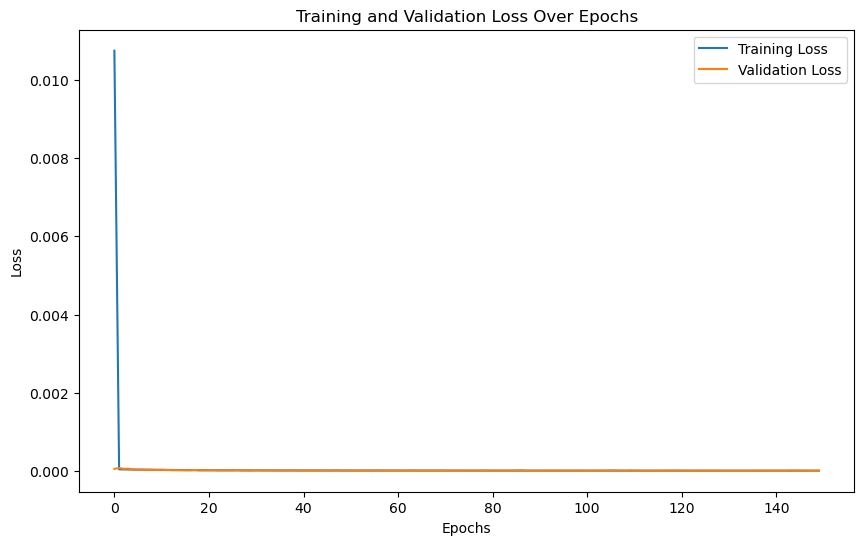

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66176.9593, Test MSE: 61648.9975, Train MAE: 143.6566, Test MAE: 142.9662
Train RMSE: 257.2488, Test RMSE: 248.2922, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4825, Test MAPE: 0.3166
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4704
Training Time: 67.1424 seconds, Evaluat

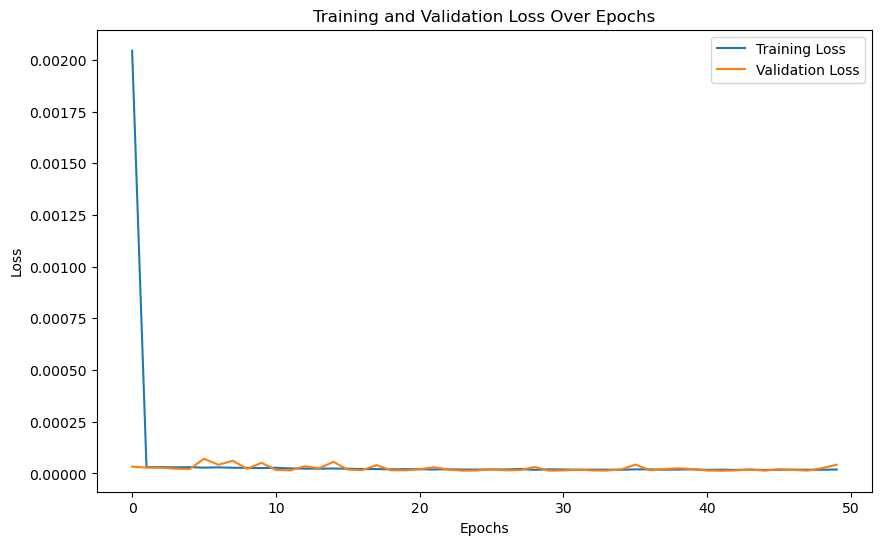

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 96888.4165, Test MSE: 147947.4359, Train MAE: 198.1142, Test MAE: 288.0796
Train RMSE: 311.2690, Test RMSE: 384.6394, Train R2: 0.9996, Test R2: 0.9993
Train MAPE: 0.6303, Test MAPE: 0.6587
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4675
Training Time: 66.1751 seconds, Evaluation Time: 0.1341 seconds



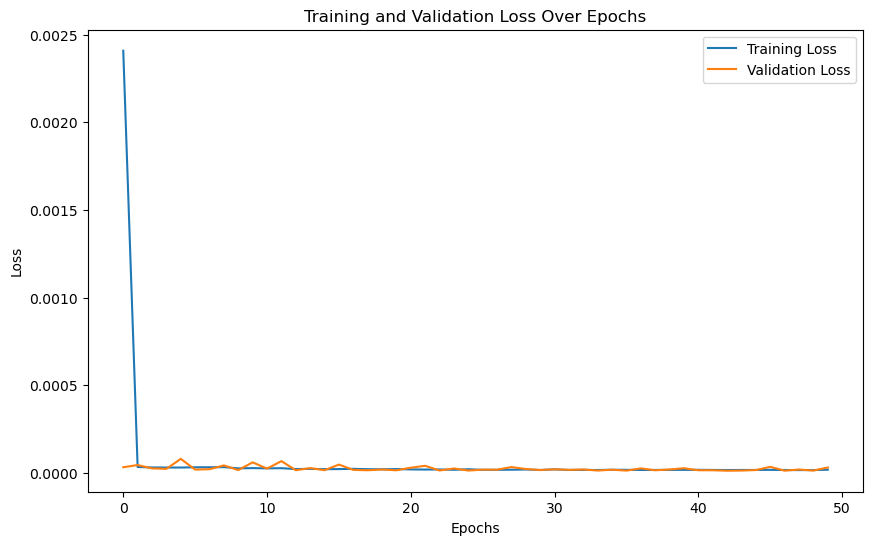

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65927.5801, Test MSE: 61208.8019, Train MAE: 142.5113, Test MAE: 140.1323
Train RMSE: 256.7637, Test RMSE: 247.4041, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4758, Test MAPE: 0.3091
Train Directional Accuracy: 0.4705, Test Directional Accuracy: 0.4709
Training Time: 71.2232 seconds, Evalu

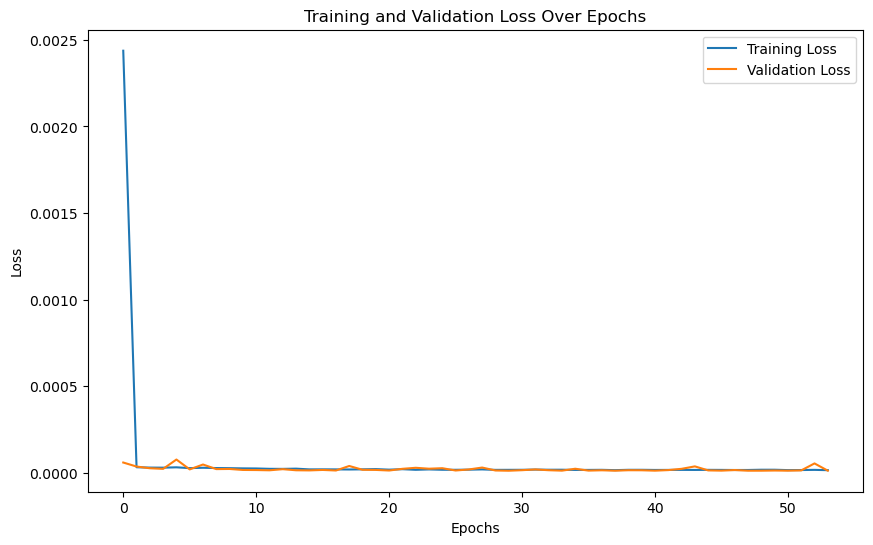

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 97051.7594, Test MSE: 87058.7607, Train MAE: 233.2842, Test MAE: 221.1990
Train RMSE: 311.5313, Test RMSE: 295.0572, Train R2: 0.9996, Test R2: 0.9996
Train MAPE: 1.0681, Test MAPE: 0.5571
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4671
Training Time: 134.3434 seconds, Evaluation Time: 0.1402 seconds



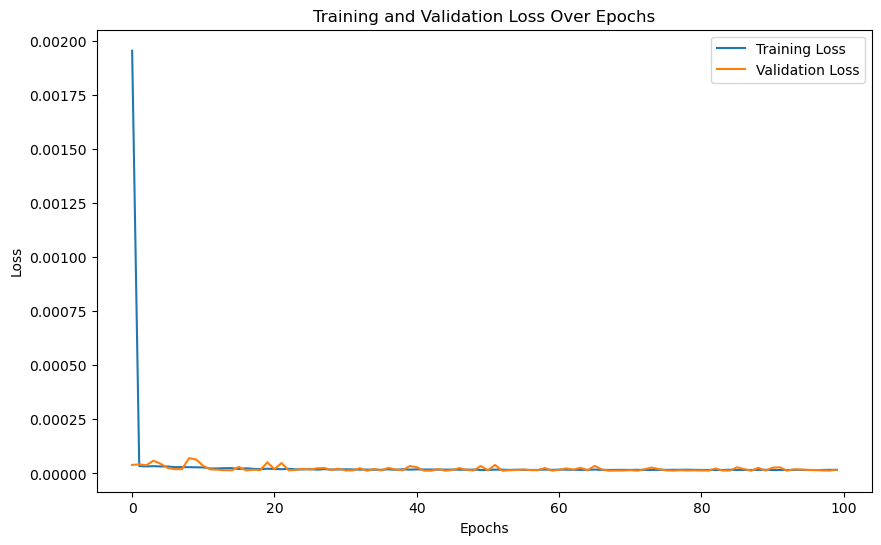

Running model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67755.4064, Test MSE: 61833.7524, Train MAE: 153.3828, Test MAE: 142.0451
Train RMSE: 260.2987, Test RMSE: 248.6639, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5789, Test MAPE: 0.3139
Train Directional Accuracy: 0.4717, Test Directional Accuracy: 0.4688
Training Time: 85.1489 seconds, Evalu

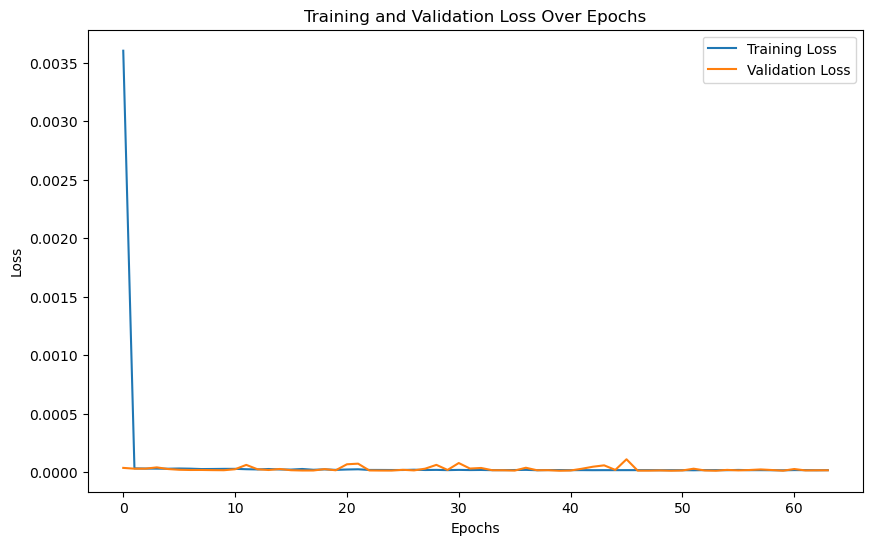

Finished model with parameters: {'window_size': 24, 'lstm_dim': 96, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 110388.7553, Test MSE: 126943.4969, Train MAE: 223.3602, Test MAE: 279.2539
Train RMSE: 332.2480, Test RMSE: 356.2913, Train R2: 0.9996, Test R2: 0.9994
Train MAPE: 0.7494, Test MAPE: 0.6746
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4660
Training Time: 198.9011 seconds, Evaluation Time: 0.1532 seconds



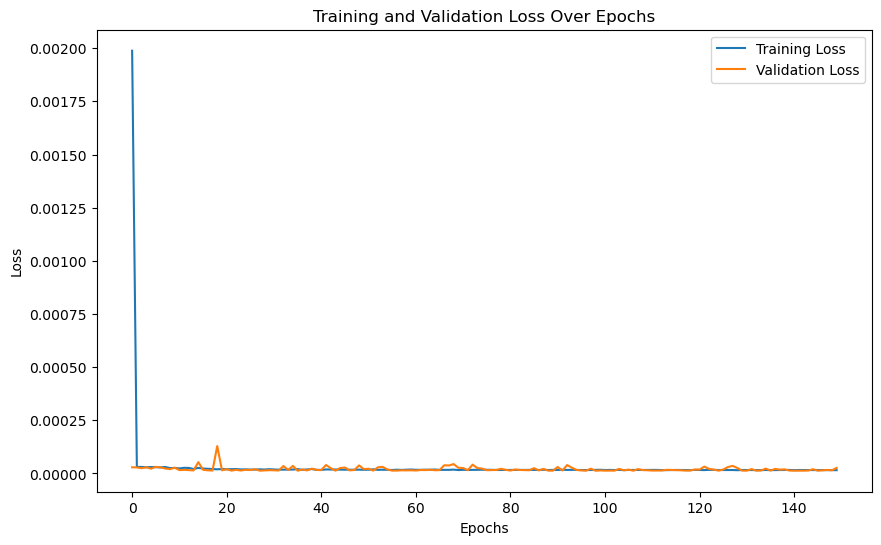

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74557.1535, Test MSE: 65575.0112, Train MAE: 162.1496, Test MAE: 144.7583
Train RMSE: 273.0516, Test RMSE: 256.0762, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6122, Test MAPE: 0.3227
Train Directional Accuracy: 0.4703, Test Directional Accuracy: 0.4691
Training Time: 66.8279 seconds, Evaluat

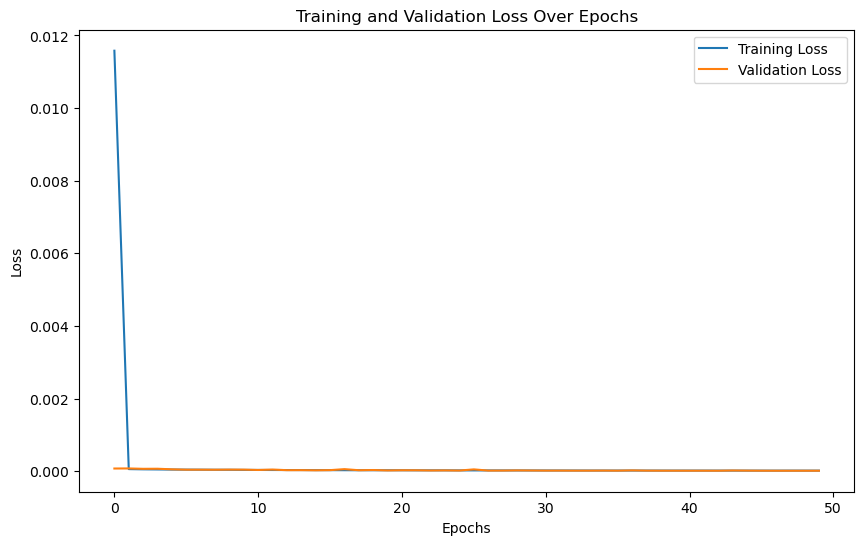

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73023.9138, Test MSE: 67358.8580, Train MAE: 152.5402, Test MAE: 148.4584
Train RMSE: 270.2294, Test RMSE: 259.5359, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5216, Test MAPE: 0.3294
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4703
Training Time: 65.5261 seconds, Evaluation Time: 0.1892 seconds



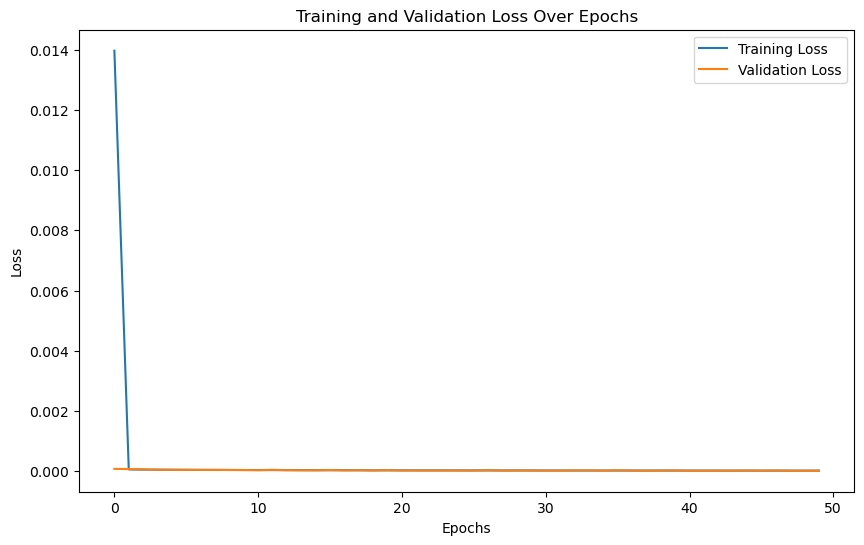

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66675.2342, Test MSE: 61831.0548, Train MAE: 143.8037, Test MAE: 140.8483
Train RMSE: 258.2155, Test RMSE: 248.6585, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4837, Test MAPE: 0.3105
Train Directional Accuracy: 0.4735, Test Directional Accuracy: 0.4703
Training Time: 115.6807 seconds, Eval

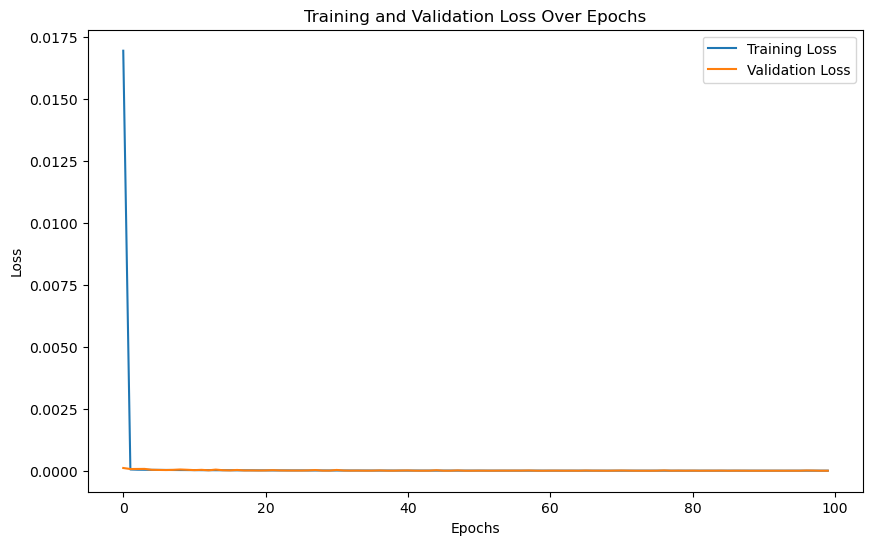

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74195.8874, Test MSE: 66247.4907, Train MAE: 172.9177, Test MAE: 157.4057
Train RMSE: 272.3892, Test RMSE: 257.3859, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6924, Test MAPE: 0.3618
Train Directional Accuracy: 0.4717, Test Directional Accuracy: 0.4705
Training Time: 116.2513 seconds, Evaluation Time: 0.1872 seconds



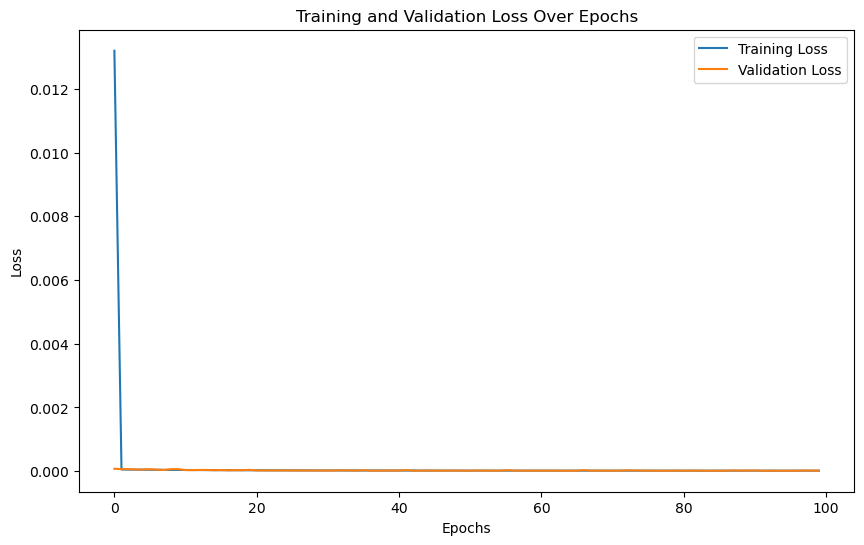

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64828.7814, Test MSE: 60323.8394, Train MAE: 140.9559, Test MAE: 138.5569
Train RMSE: 254.6150, Test RMSE: 245.6091, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4695, Test MAPE: 0.3045
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4692
Training Time: 179.6019 seconds, Eval

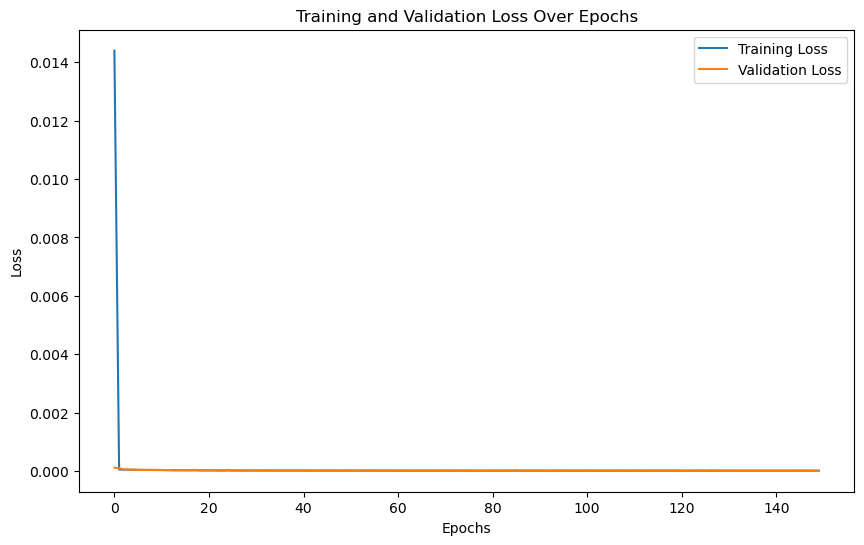

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65675.0553, Test MSE: 61220.3728, Train MAE: 142.1508, Test MAE: 141.8318
Train RMSE: 256.2714, Test RMSE: 247.4275, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4732, Test MAPE: 0.3140
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4693
Training Time: 199.4157 seconds, Evaluation Time: 0.2168 seconds



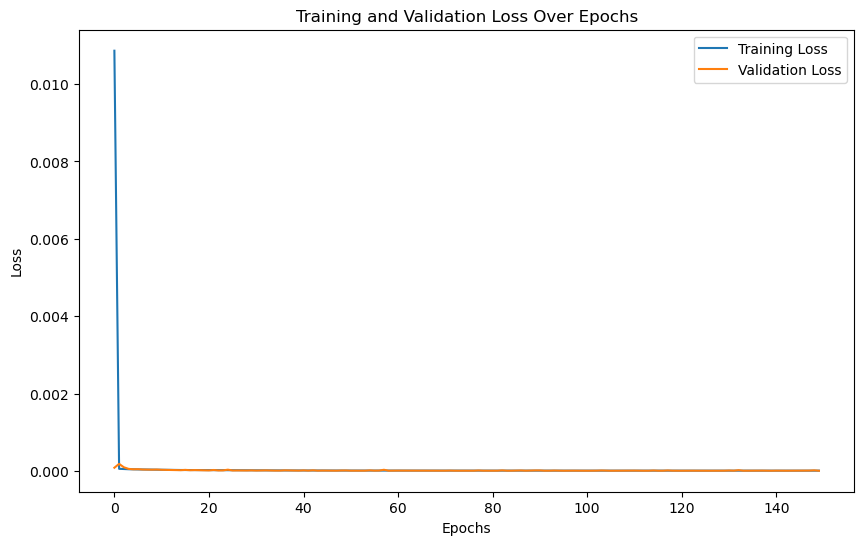

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67530.6401, Test MSE: 61726.0197, Train MAE: 157.7426, Test MAE: 146.6962
Train RMSE: 259.8666, Test RMSE: 248.4472, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6082, Test MAPE: 0.3314
Train Directional Accuracy: 0.4683, Test Directional Accuracy: 0.4689
Training Time: 65.8746 seconds, Evaluatio

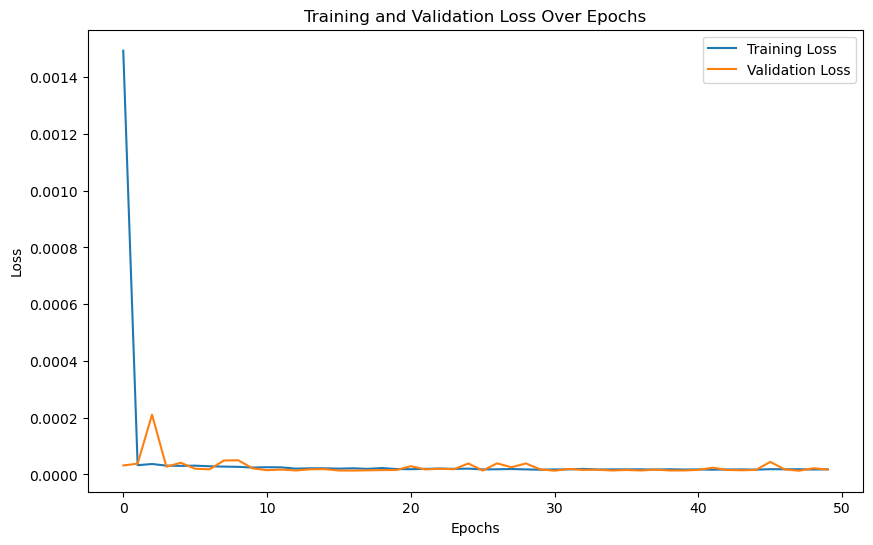

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 79408.3946, Test MSE: 75411.0892, Train MAE: 170.8479, Test MAE: 179.0484
Train RMSE: 281.7950, Test RMSE: 274.6108, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.6098, Test MAPE: 0.4131
Train Directional Accuracy: 0.4705, Test Directional Accuracy: 0.4676
Training Time: 65.2483 seconds, Evaluation Time: 0.1982 seconds



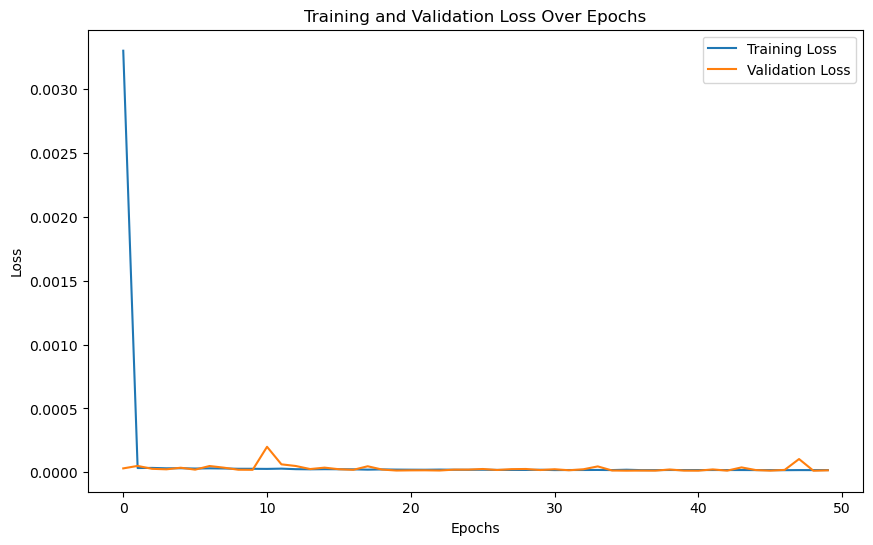

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66855.8244, Test MSE: 61992.5808, Train MAE: 148.3954, Test MAE: 141.9116
Train RMSE: 258.5649, Test RMSE: 248.9831, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5340, Test MAPE: 0.3140
Train Directional Accuracy: 0.4712, Test Directional Accuracy: 0.4699
Training Time: 69.3167 seconds, Evaluat

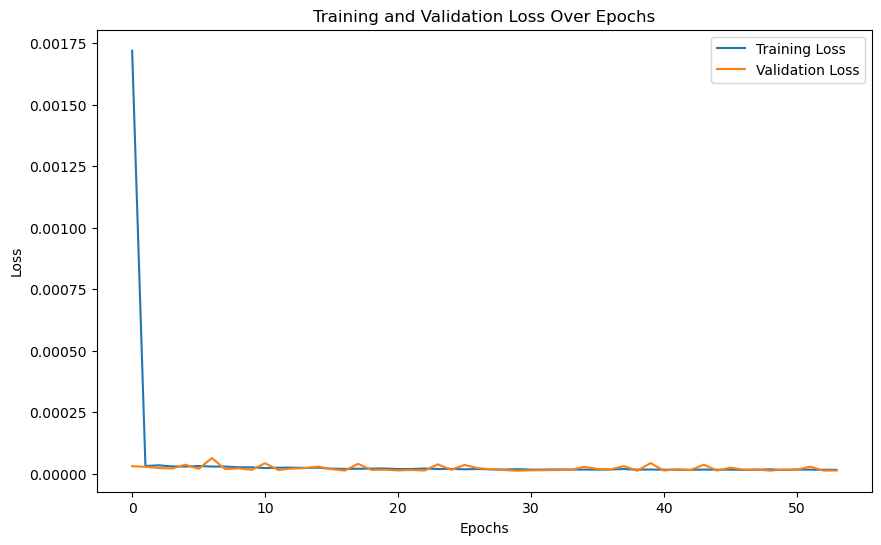

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 80686.0624, Test MSE: 115117.4979, Train MAE: 168.3834, Test MAE: 226.0574
Train RMSE: 284.0529, Test RMSE: 339.2897, Train R2: 0.9997, Test R2: 0.9994
Train MAPE: 0.5346, Test MAPE: 0.4887
Train Directional Accuracy: 0.4687, Test Directional Accuracy: 0.4671
Training Time: 129.1470 seconds, Evaluation Time: 0.2017 seconds



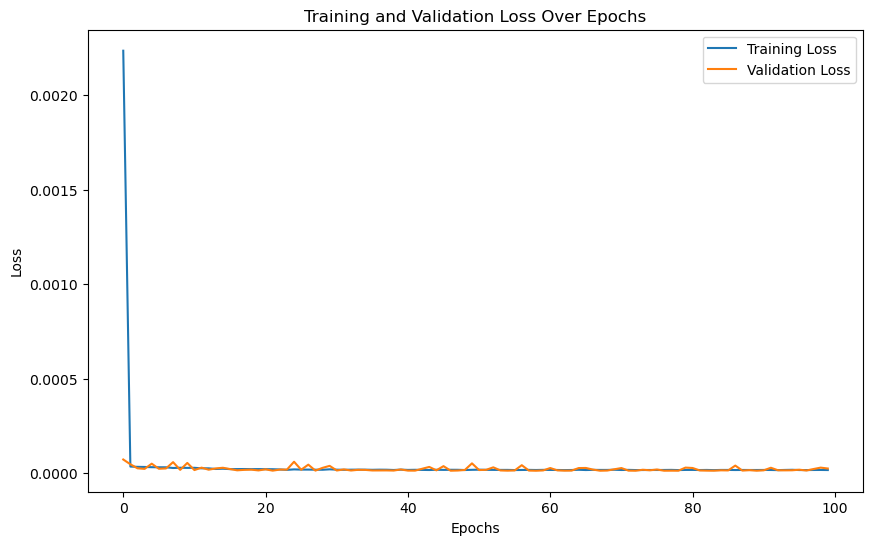

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65888.9959, Test MSE: 60947.1450, Train MAE: 142.1425, Test MAE: 140.0731
Train RMSE: 256.6885, Test RMSE: 246.8748, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4731, Test MAPE: 0.3091
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4701
Training Time: 74.8911 seconds, Evaluat

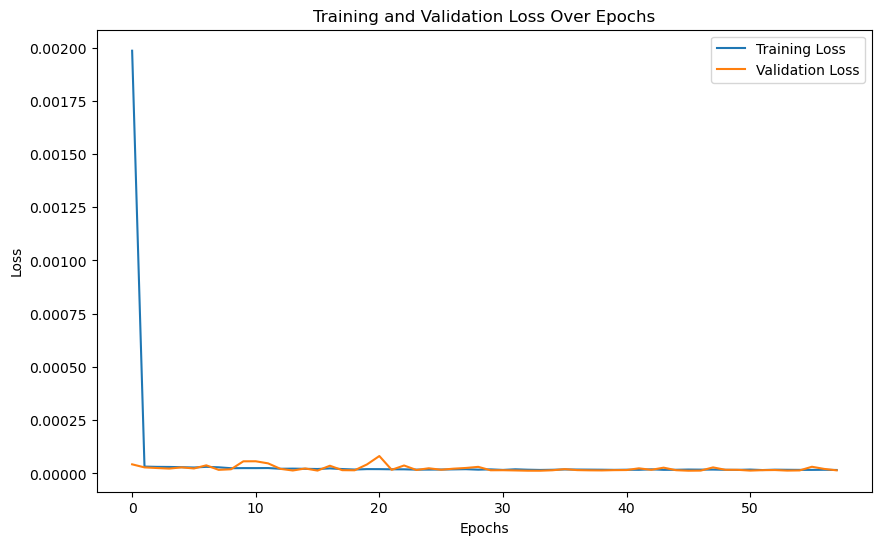

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66252.6729, Test MSE: 62869.8960, Train MAE: 157.0830, Test MAE: 141.6219
Train RMSE: 257.3959, Test RMSE: 250.7387, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6175, Test MAPE: 0.3100
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4679
Training Time: 201.2248 seconds, Evaluation Time: 0.2088 seconds



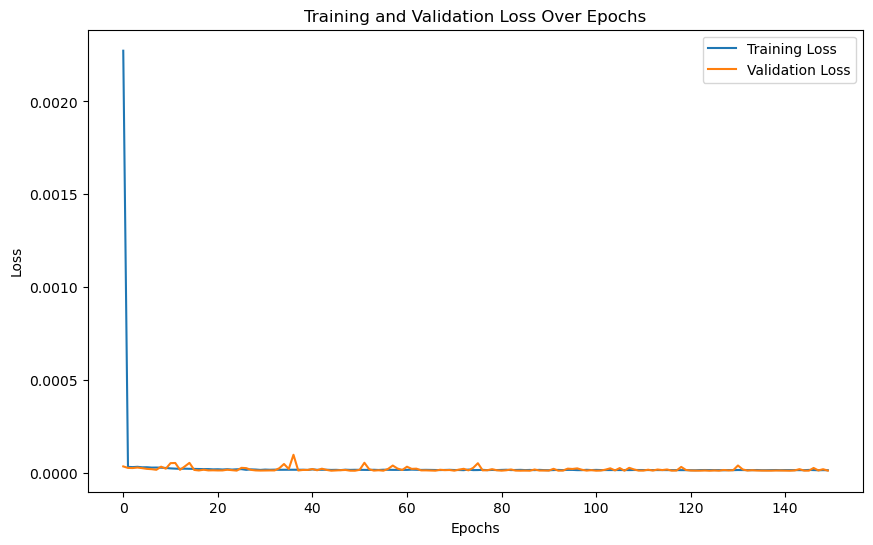

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74615.4168, Test MSE: 65973.0468, Train MAE: 152.8742, Test MAE: 143.6835
Train RMSE: 273.1582, Test RMSE: 256.8522, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5146, Test MAPE: 0.3181
Train Directional Accuracy: 0.4676, Test Directional Accuracy: 0.4710
Training Time: 62.5939 seconds, Evalu

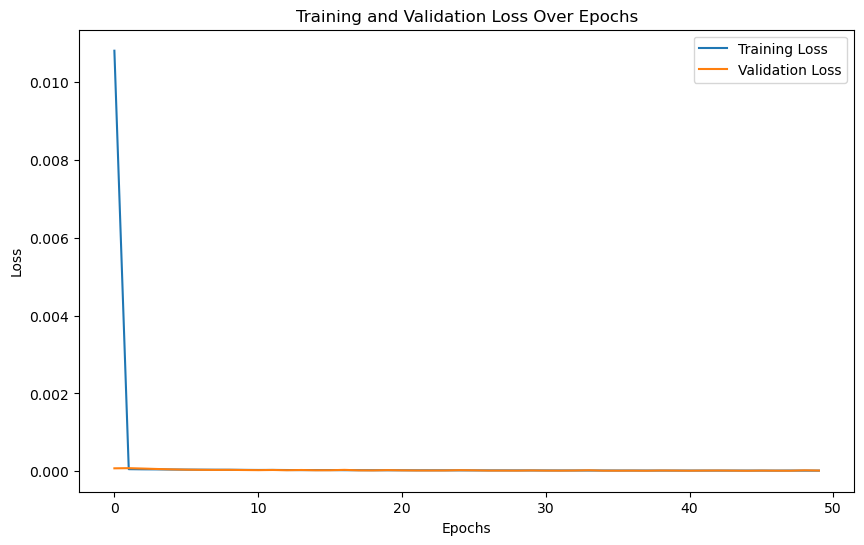

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 85301.7983, Test MSE: 90912.7424, Train MAE: 189.6817, Test MAE: 209.8560
Train RMSE: 292.0647, Test RMSE: 301.5174, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.7441, Test MAPE: 0.4978
Train Directional Accuracy: 0.4690, Test Directional Accuracy: 0.4736
Training Time: 57.6560 seconds, Evaluation Time: 0.1913 seconds



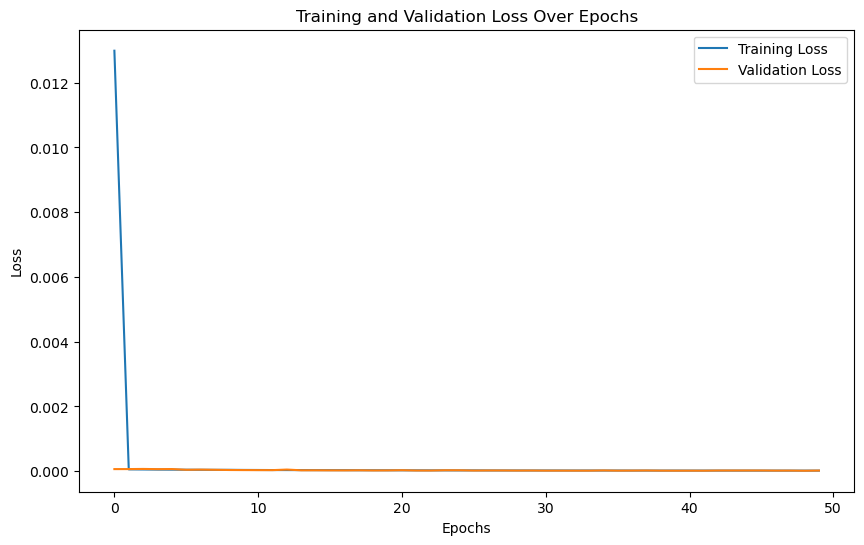

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67412.6081, Test MSE: 62185.6005, Train MAE: 150.5099, Test MAE: 141.6848
Train RMSE: 259.6394, Test RMSE: 249.3704, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5443, Test MAPE: 0.3127
Train Directional Accuracy: 0.4713, Test Directional Accuracy: 0.4692
Training Time: 118.0155 seconds, Ev

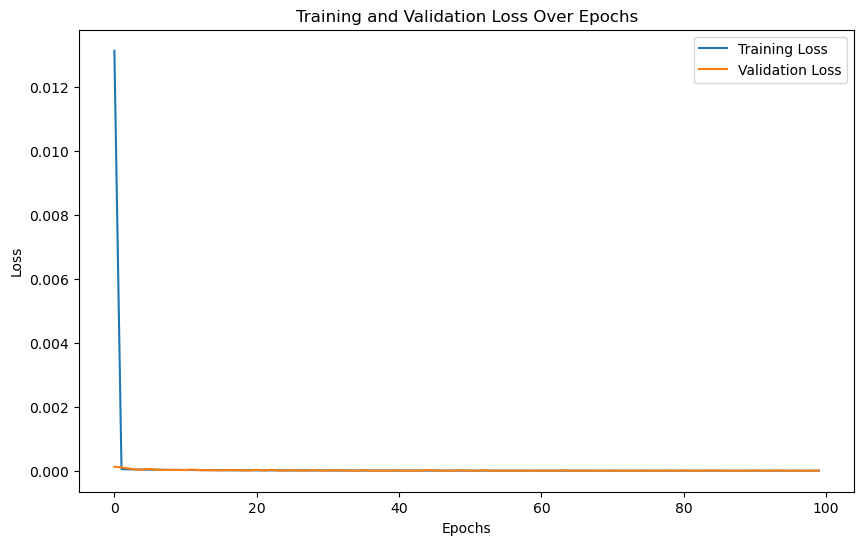

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65349.1877, Test MSE: 61948.1475, Train MAE: 141.6568, Test MAE: 141.3972
Train RMSE: 255.6349, Test RMSE: 248.8938, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4761, Test MAPE: 0.3109
Train Directional Accuracy: 0.4715, Test Directional Accuracy: 0.4714
Training Time: 117.1127 seconds, Evaluation Time: 0.1908 seconds



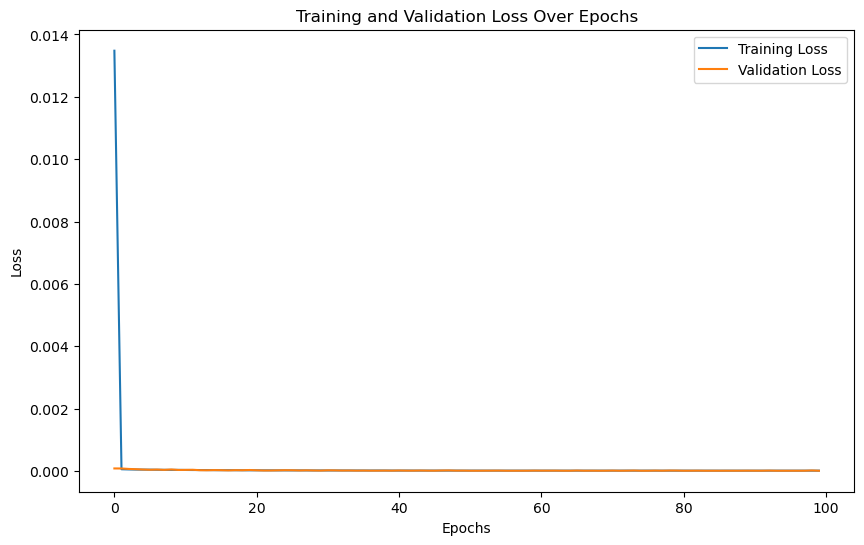

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65098.8487, Test MSE: 61309.4890, Train MAE: 141.0641, Test MAE: 140.4812
Train RMSE: 255.1448, Test RMSE: 247.6075, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4703, Test MAPE: 0.3085
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4699
Training Time: 171.8138 seconds, Ev

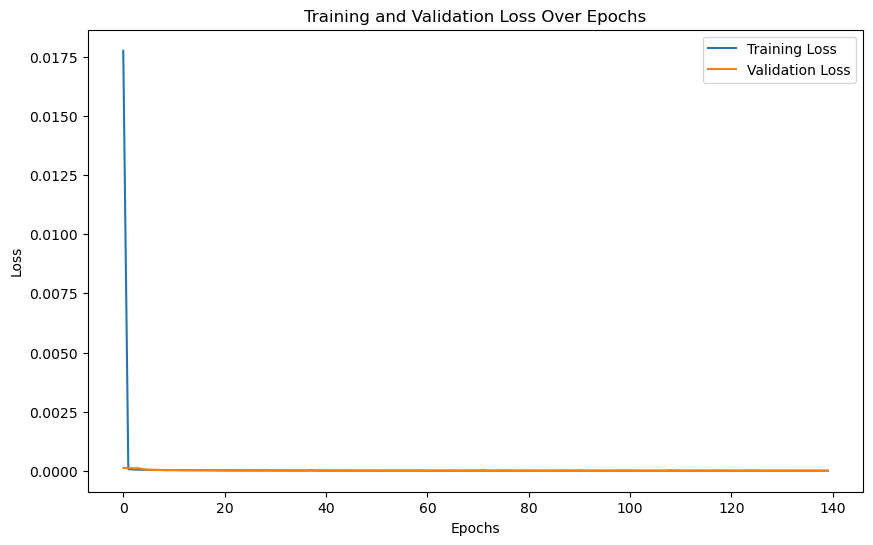

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66426.5062, Test MSE: 61929.8201, Train MAE: 148.2015, Test MAE: 146.9786
Train RMSE: 257.7334, Test RMSE: 248.8570, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5152, Test MAPE: 0.3313
Train Directional Accuracy: 0.4682, Test Directional Accuracy: 0.4685
Training Time: 186.2596 seconds, Evaluation Time: 0.2078 seconds



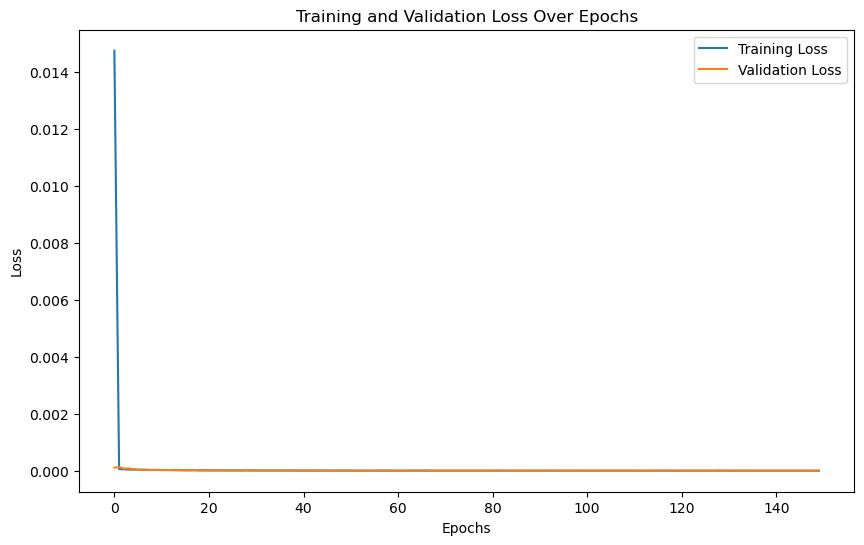

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66974.8658, Test MSE: 61342.5411, Train MAE: 150.9411, Test MAE: 141.6573
Train RMSE: 258.7950, Test RMSE: 247.6743, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5597, Test MAPE: 0.3133
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4681
Training Time: 60.5378 seconds, Evaluat

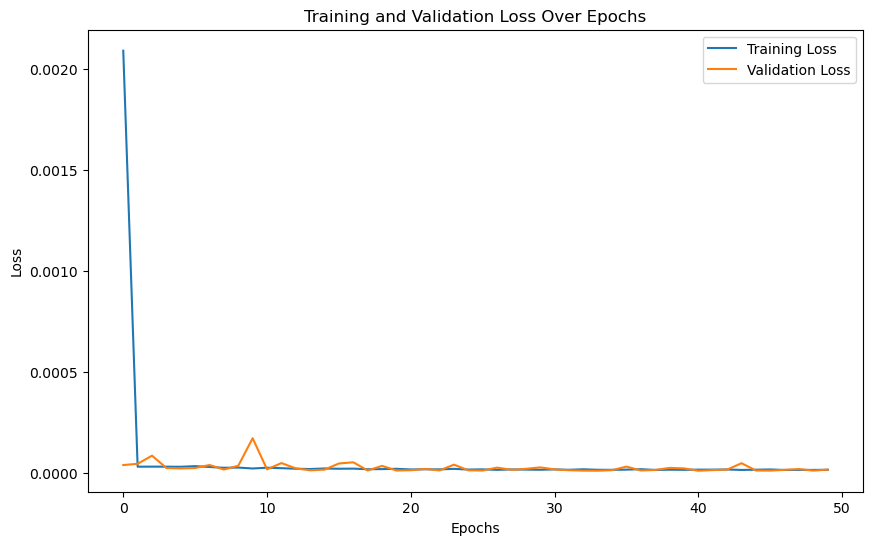

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65972.3407, Test MSE: 65760.2744, Train MAE: 146.2480, Test MAE: 146.6128
Train RMSE: 256.8508, Test RMSE: 256.4377, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5188, Test MAPE: 0.3170
Train Directional Accuracy: 0.4723, Test Directional Accuracy: 0.4688
Training Time: 59.7283 seconds, Evaluation Time: 0.1943 seconds



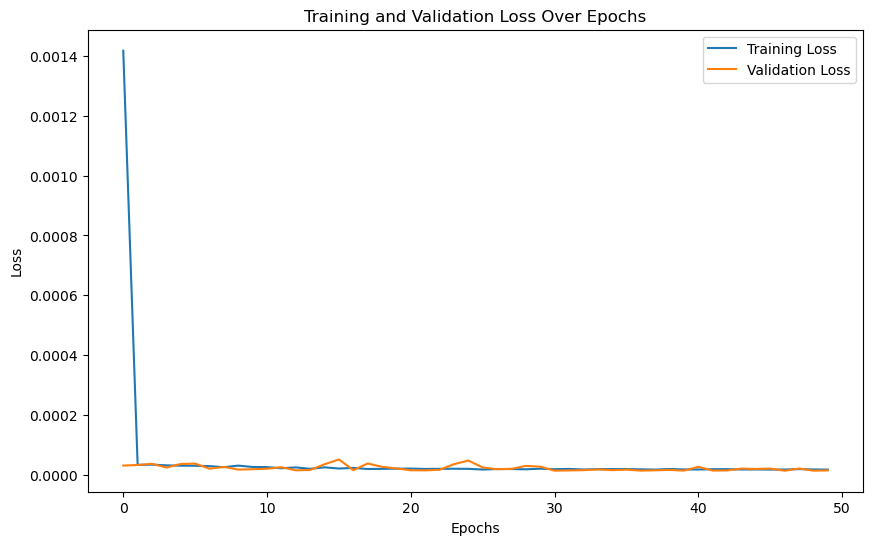

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64950.9483, Test MSE: 60928.7931, Train MAE: 144.4007, Test MAE: 141.9874
Train RMSE: 254.8548, Test RMSE: 246.8376, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5066, Test MAPE: 0.3163
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4668
Training Time: 81.0314 seconds, Evalu

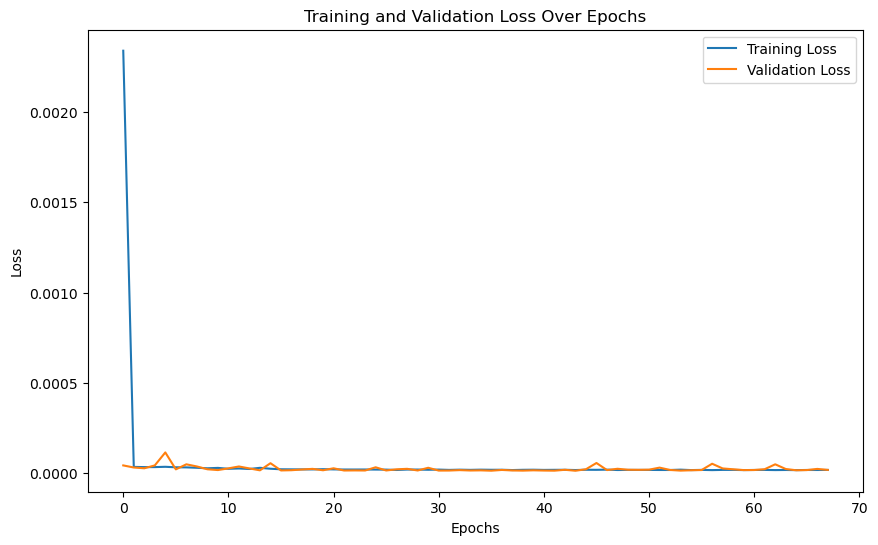

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65990.3083, Test MSE: 60902.4115, Train MAE: 154.5306, Test MAE: 139.9150
Train RMSE: 256.8858, Test RMSE: 246.7841, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6073, Test MAPE: 0.3087
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4688
Training Time: 117.3411 seconds, Evaluation Time: 0.1882 seconds



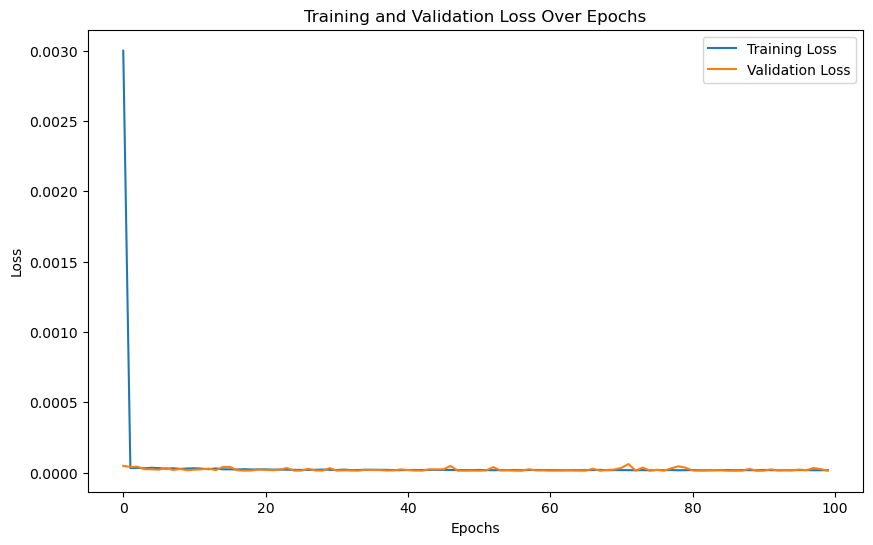

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65398.6753, Test MSE: 60459.2946, Train MAE: 147.4551, Test MAE: 138.7785
Train RMSE: 255.7316, Test RMSE: 245.8847, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5427, Test MAPE: 0.3056
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4709
Training Time: 106.3249 seconds, Eval

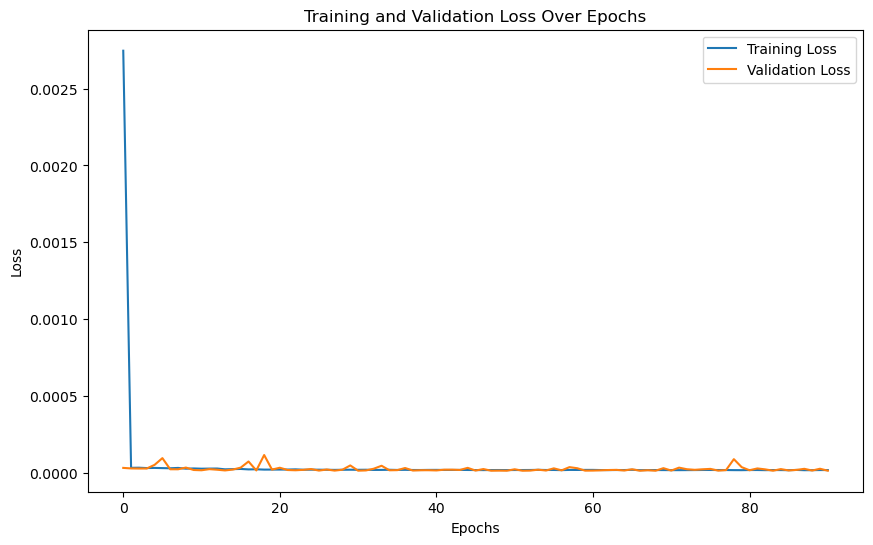

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 69932.6702, Test MSE: 81250.0789, Train MAE: 157.2605, Test MAE: 170.9179
Train RMSE: 264.4479, Test RMSE: 285.0440, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5789, Test MAPE: 0.3653
Train Directional Accuracy: 0.4681, Test Directional Accuracy: 0.4701
Training Time: 172.8638 seconds, Evaluation Time: 0.1897 seconds



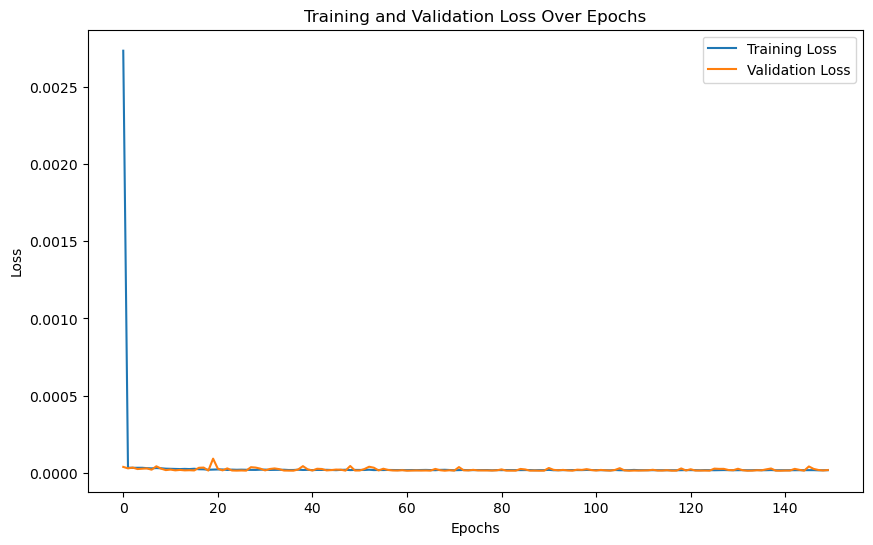

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73420.4478, Test MSE: 67248.3886, Train MAE: 165.8122, Test MAE: 156.7542
Train RMSE: 270.9621, Test RMSE: 259.3229, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6470, Test MAPE: 0.3619
Train Directional Accuracy: 0.4696, Test Directional Accuracy: 0.4692
Training Time: 57.9036 seconds, Evalu

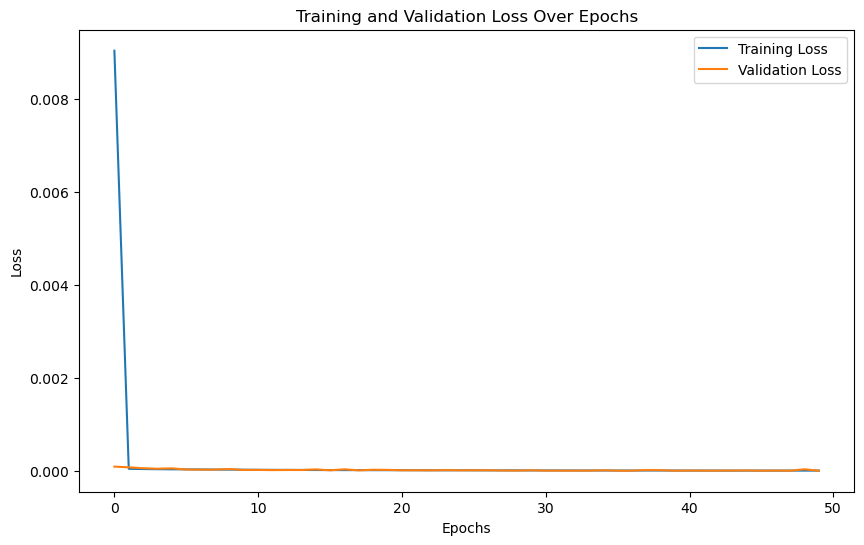

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 83398.0532, Test MSE: 79926.1717, Train MAE: 192.8711, Test MAE: 190.4964
Train RMSE: 288.7872, Test RMSE: 282.7122, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.7935, Test MAPE: 0.4553
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4707
Training Time: 57.7093 seconds, Evaluation Time: 0.2015 seconds



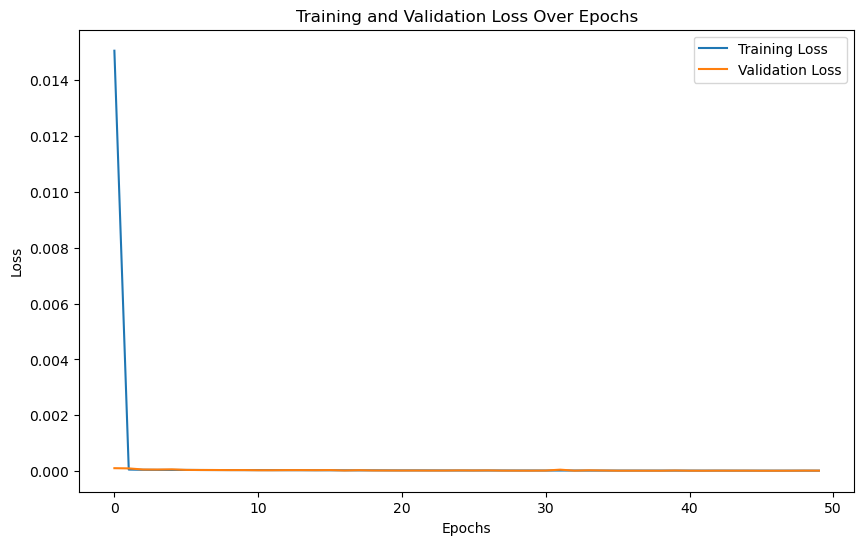

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67446.4662, Test MSE: 62486.9298, Train MAE: 144.0104, Test MAE: 141.0145
Train RMSE: 259.7046, Test RMSE: 249.9739, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4814, Test MAPE: 0.3109
Train Directional Accuracy: 0.4747, Test Directional Accuracy: 0.4722
Training Time: 115.2556 seconds, Ev

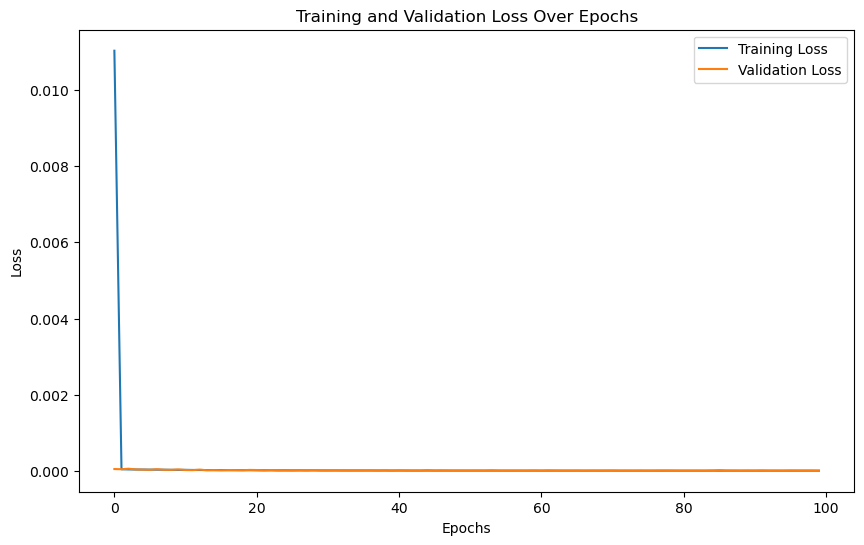

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66975.1044, Test MSE: 66692.6009, Train MAE: 144.7931, Test MAE: 149.8444
Train RMSE: 258.7955, Test RMSE: 258.2491, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4883, Test MAPE: 0.3282
Train Directional Accuracy: 0.4725, Test Directional Accuracy: 0.4704
Training Time: 115.2630 seconds, Evaluation Time: 0.1887 seconds



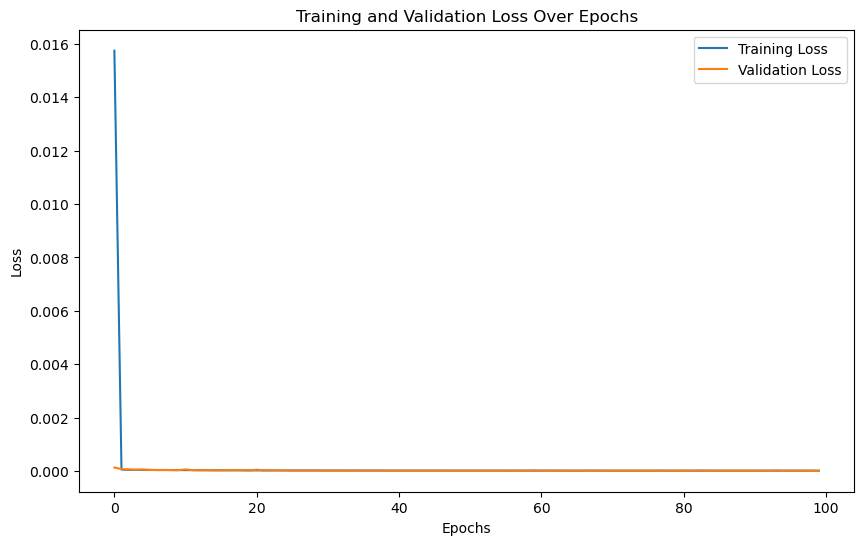

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65140.4323, Test MSE: 60587.3747, Train MAE: 142.0218, Test MAE: 139.1860
Train RMSE: 255.2262, Test RMSE: 246.1450, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4832, Test MAPE: 0.3061
Train Directional Accuracy: 0.4690, Test Directional Accuracy: 0.4687
Training Time: 173.1485 seconds, Ev

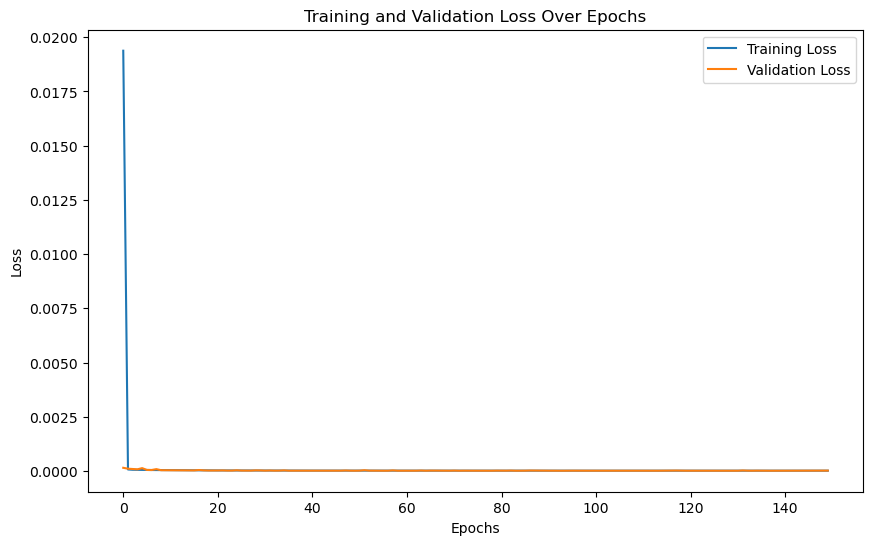

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67335.5234, Test MSE: 62976.7278, Train MAE: 148.0500, Test MAE: 143.9188
Train RMSE: 259.4909, Test RMSE: 250.9516, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5231, Test MAPE: 0.3163
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4697
Training Time: 173.3297 seconds, Evaluation Time: 0.1858 seconds



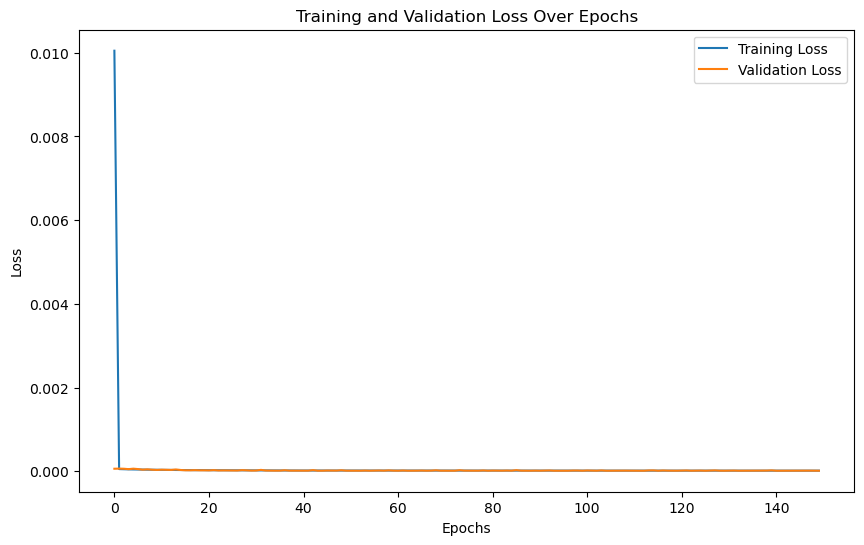

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 70358.0071, Test MSE: 63083.6507, Train MAE: 171.8182, Test MAE: 146.4746
Train RMSE: 265.2508, Test RMSE: 251.1646, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.7651, Test MAPE: 0.3261
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4688
Training Time: 57.4253 seconds, Evaluat

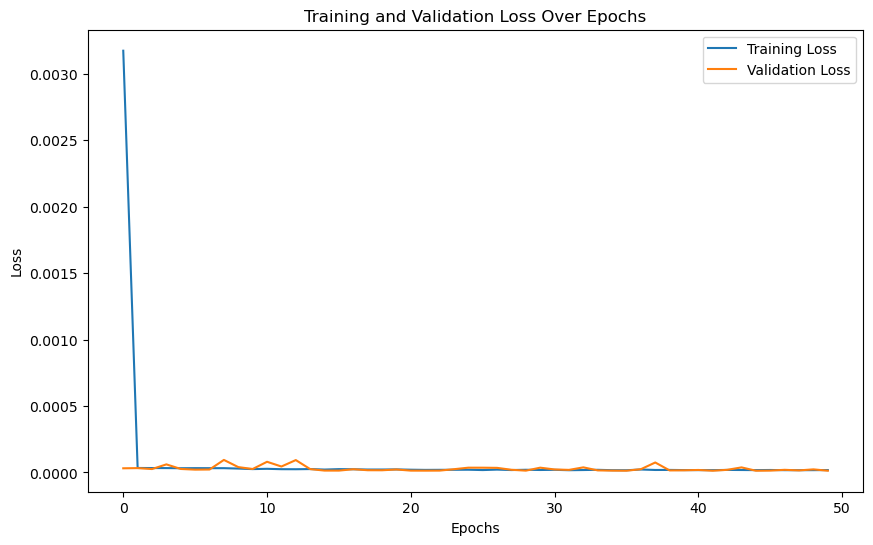

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 81587.0129, Test MSE: 108688.7997, Train MAE: 172.5550, Test MAE: 227.6315
Train RMSE: 285.6344, Test RMSE: 329.6798, Train R2: 0.9997, Test R2: 0.9995
Train MAPE: 0.5811, Test MAPE: 0.5073
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4703
Training Time: 57.7936 seconds, Evaluation Time: 0.2032 seconds



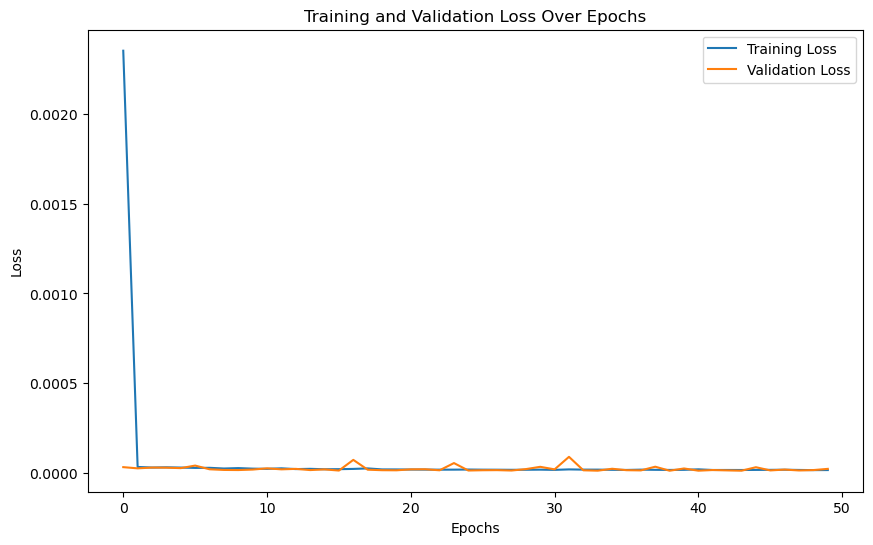

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65327.4824, Test MSE: 60134.6025, Train MAE: 144.4095, Test MAE: 138.3757
Train RMSE: 255.5924, Test RMSE: 245.2236, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4966, Test MAPE: 0.3047
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4683
Training Time: 78.4892 seconds, Evalu

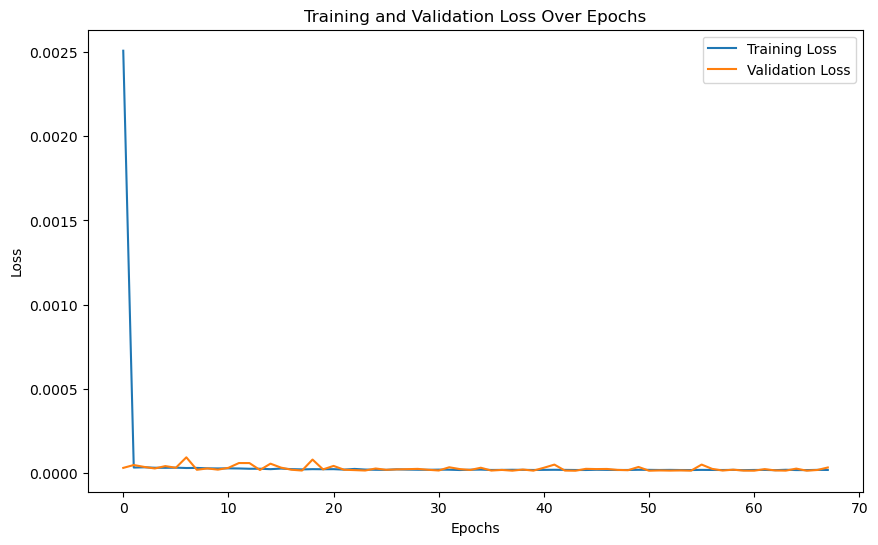

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64884.0935, Test MSE: 63040.8394, Train MAE: 144.9904, Test MAE: 143.3021
Train RMSE: 254.7236, Test RMSE: 251.0793, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5100, Test MAPE: 0.3144
Train Directional Accuracy: 0.4710, Test Directional Accuracy: 0.4664
Training Time: 102.5485 seconds, Evaluation Time: 0.2027 seconds



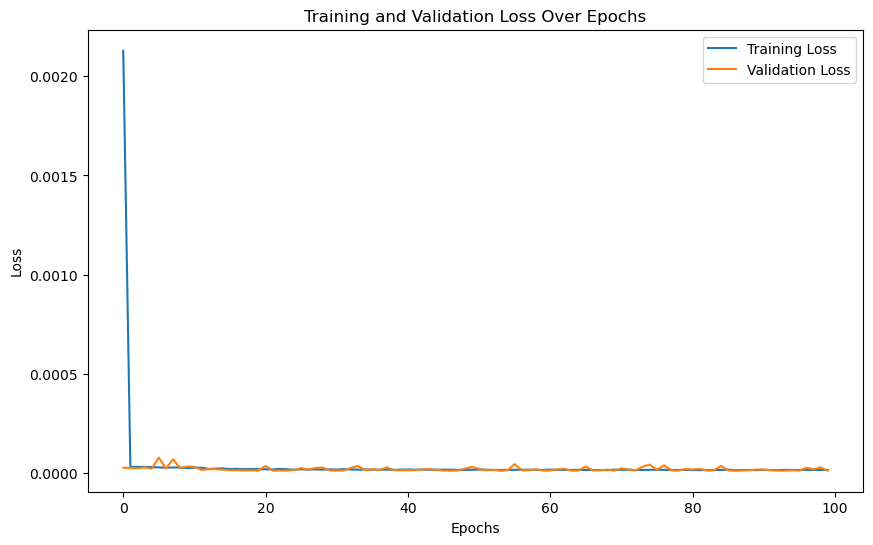

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66120.6519, Test MSE: 60933.1624, Train MAE: 144.3035, Test MAE: 140.8650
Train RMSE: 257.1394, Test RMSE: 246.8464, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4866, Test MAPE: 0.3108
Train Directional Accuracy: 0.4702, Test Directional Accuracy: 0.4695
Training Time: 102.8307 seconds, Eval

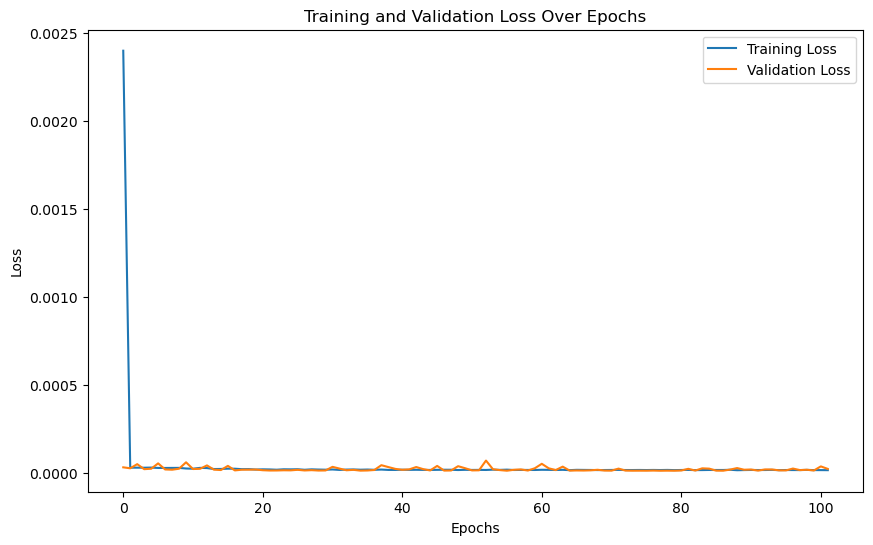

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 75954.2998, Test MSE: 104171.2980, Train MAE: 161.0776, Test MAE: 204.4172
Train RMSE: 275.5981, Test RMSE: 322.7558, Train R2: 0.9997, Test R2: 0.9995
Train MAPE: 0.5308, Test MAPE: 0.4334
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4703
Training Time: 150.8063 seconds, Evaluation Time: 0.1957 seconds



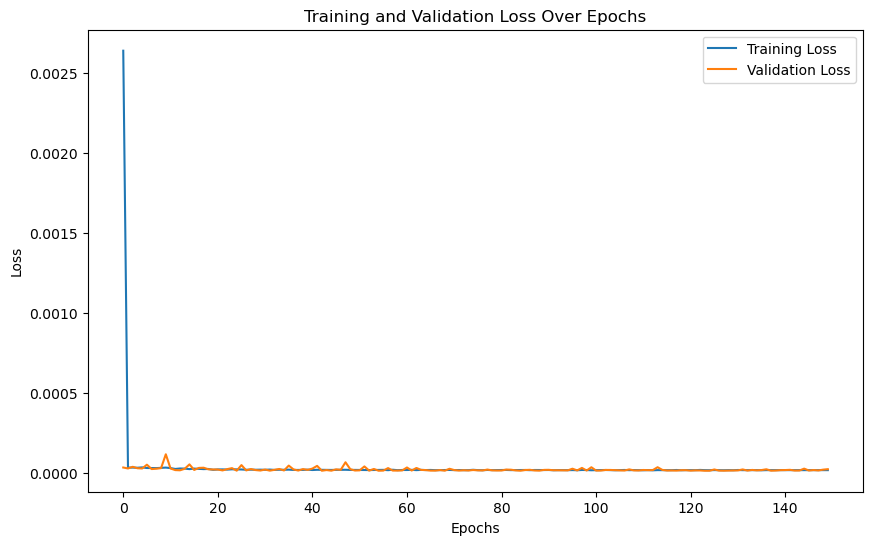

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73110.9927, Test MSE: 67054.6232, Train MAE: 151.7827, Test MAE: 147.9690
Train RMSE: 270.3904, Test RMSE: 258.9491, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5118, Test MAPE: 0.3296
Train Directional Accuracy: 0.4676, Test Directional Accuracy: 0.4732
Training Time: 51.1518 seconds, Eva

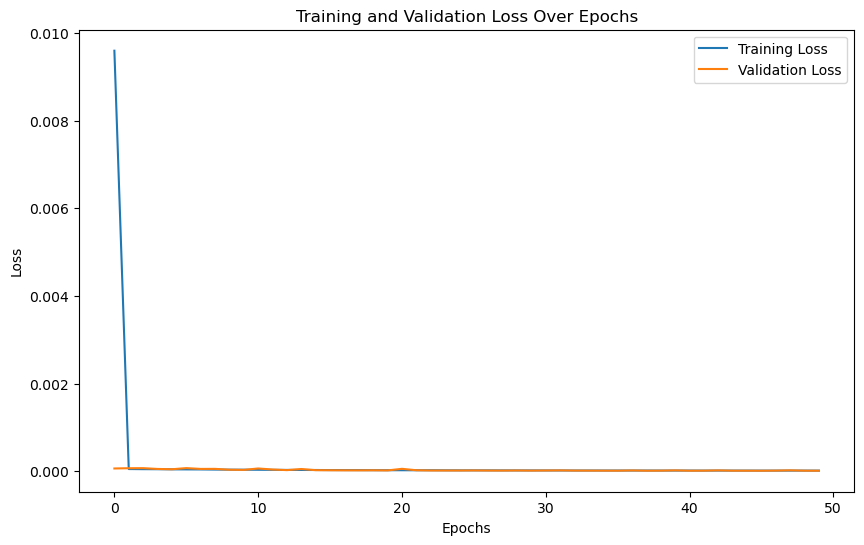

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 79023.5027, Test MSE: 75870.0392, Train MAE: 161.2284, Test MAE: 167.7465
Train RMSE: 281.1112, Test RMSE: 275.4452, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5309, Test MAPE: 0.3748
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4710
Training Time: 50.0357 seconds, Evaluation Time: 0.2304 seconds



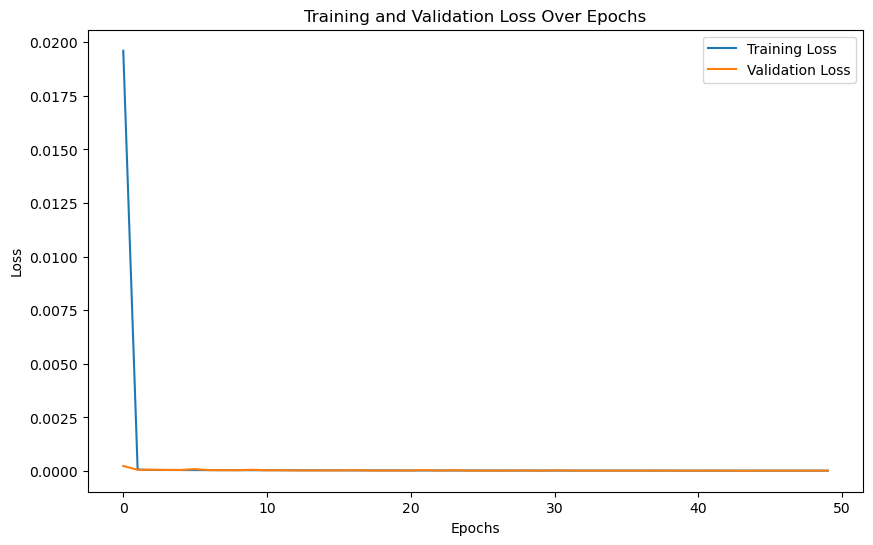

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66233.5891, Test MSE: 61262.5082, Train MAE: 146.9950, Test MAE: 140.1384
Train RMSE: 257.3589, Test RMSE: 247.5126, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5217, Test MAPE: 0.3088
Train Directional Accuracy: 0.4707, Test Directional Accuracy: 0.4701
Training Time: 100.5596 seconds, 

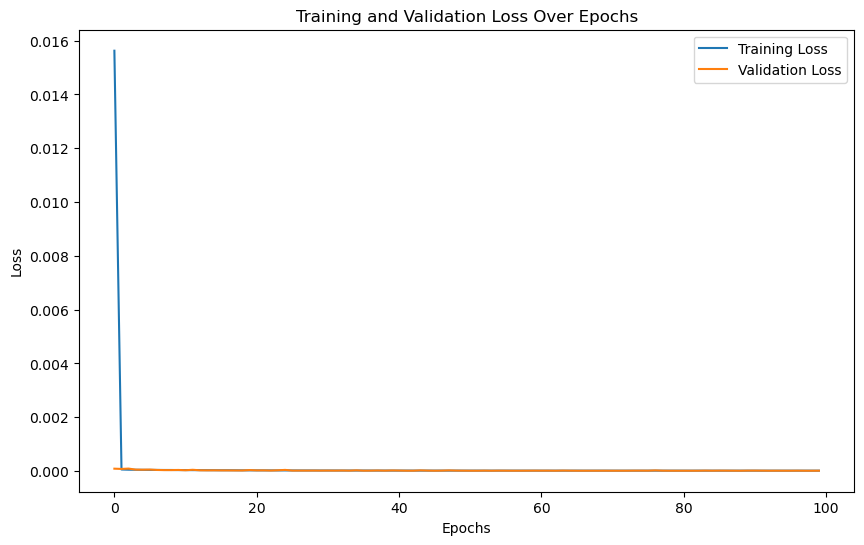

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65985.5887, Test MSE: 62799.0674, Train MAE: 145.0314, Test MAE: 145.0279
Train RMSE: 256.8766, Test RMSE: 250.5974, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4993, Test MAPE: 0.3219
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4695
Training Time: 100.7774 seconds, Evaluation Time: 0.1982 seconds



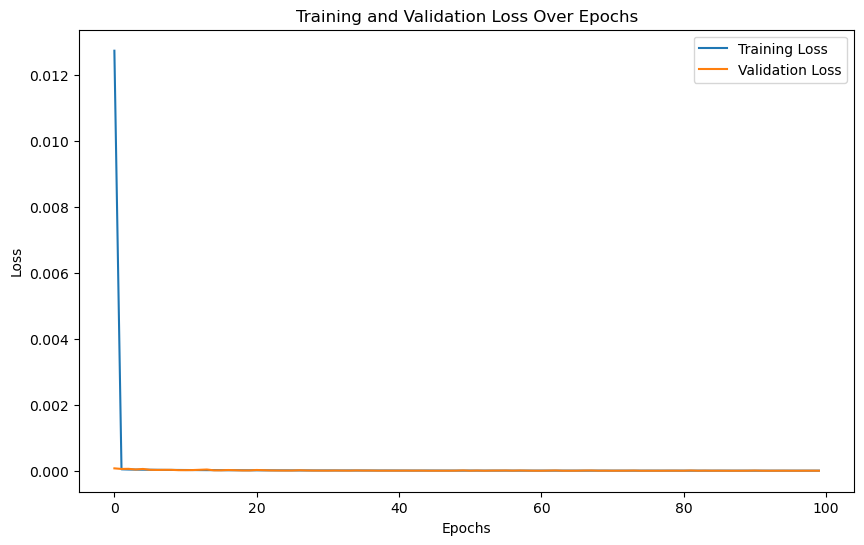

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65003.7469, Test MSE: 60486.1748, Train MAE: 141.8370, Test MAE: 138.8059
Train RMSE: 254.9583, Test RMSE: 245.9394, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4762, Test MAPE: 0.3051
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4704
Training Time: 150.7411 seconds, 

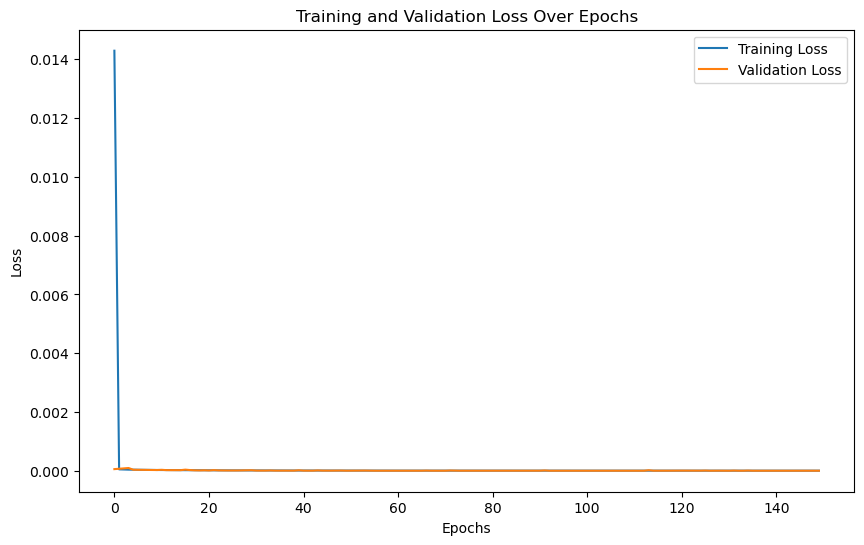

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65917.0292, Test MSE: 61185.7354, Train MAE: 152.0842, Test MAE: 140.2455
Train RMSE: 256.7431, Test RMSE: 247.3575, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5775, Test MAPE: 0.3077
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4689
Training Time: 162.6668 seconds, Evaluation Time: 0.1927 seconds



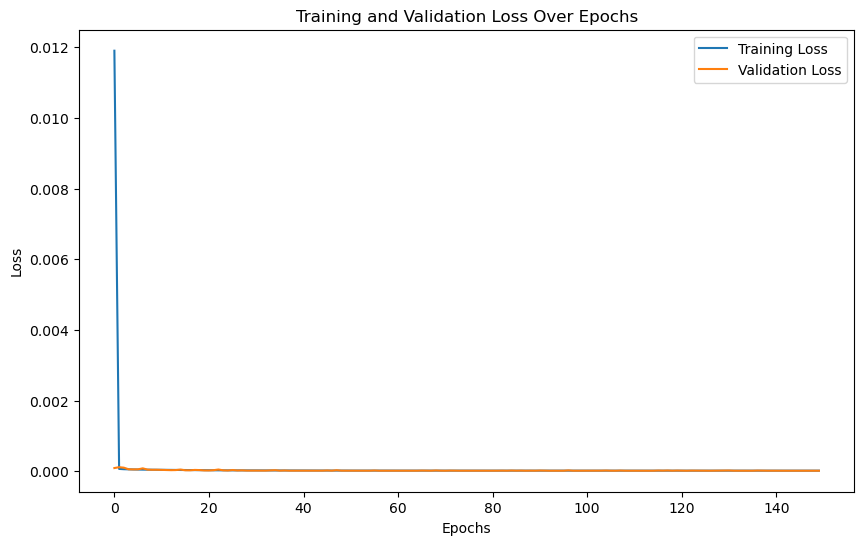

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65304.3869, Test MSE: 60412.3143, Train MAE: 141.6458, Test MAE: 139.1412
Train RMSE: 255.5472, Test RMSE: 245.7892, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4720, Test MAPE: 0.3064
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4697
Training Time: 57.1776 seconds, Evalu

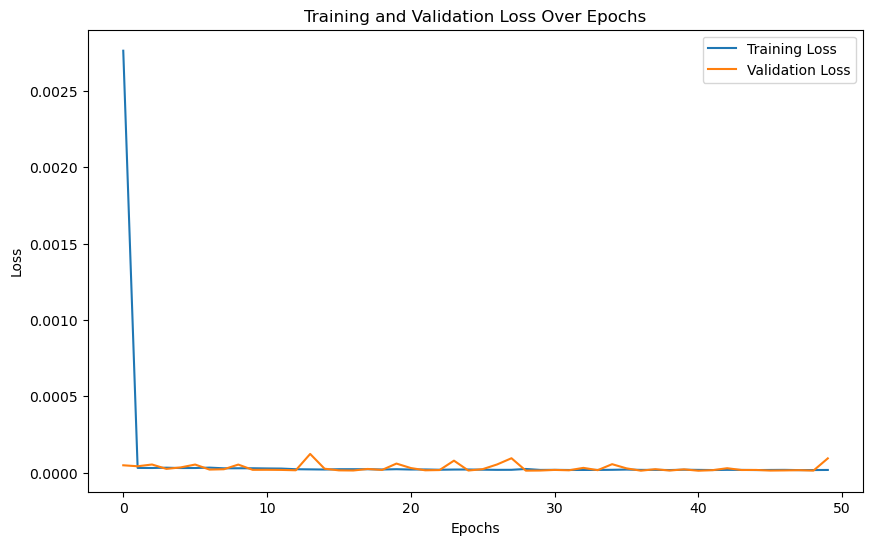

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 88367.5565, Test MSE: 116628.7082, Train MAE: 188.9519, Test MAE: 243.0918
Train RMSE: 297.2668, Test RMSE: 341.5095, Train R2: 0.9997, Test R2: 0.9994
Train MAPE: 0.6429, Test MAPE: 0.5504
Train Directional Accuracy: 0.4705, Test Directional Accuracy: 0.4691
Training Time: 60.0602 seconds, Evaluation Time: 0.2172 seconds



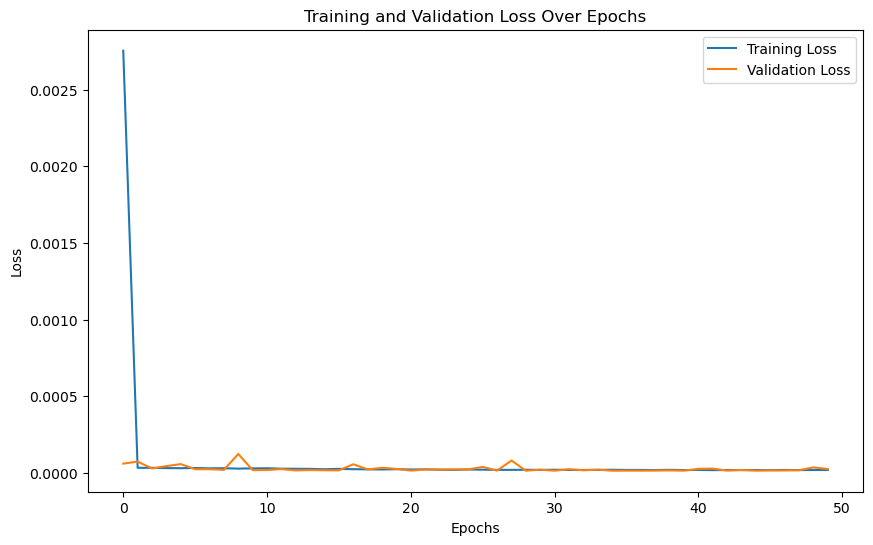

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68224.0309, Test MSE: 63788.8802, Train MAE: 146.0659, Test MAE: 145.4429
Train RMSE: 261.1973, Test RMSE: 252.5646, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4860, Test MAPE: 0.3205
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4724
Training Time: 63.0573 seconds, Eva

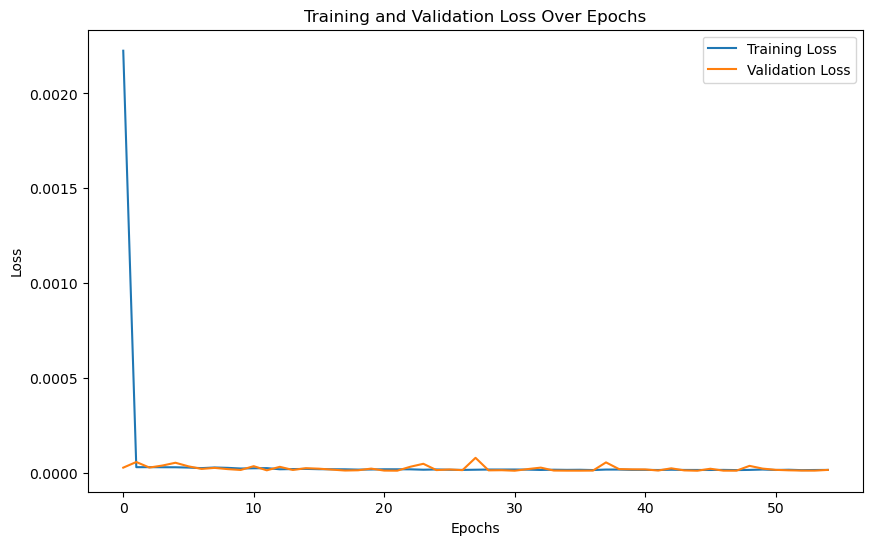

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 85404.9359, Test MSE: 126497.1581, Train MAE: 180.5028, Test MAE: 249.6943
Train RMSE: 292.2412, Test RMSE: 355.6644, Train R2: 0.9997, Test R2: 0.9994
Train MAPE: 0.6206, Test MAPE: 0.5511
Train Directional Accuracy: 0.4712, Test Directional Accuracy: 0.4639
Training Time: 105.9191 seconds, Evaluation Time: 0.1877 seconds



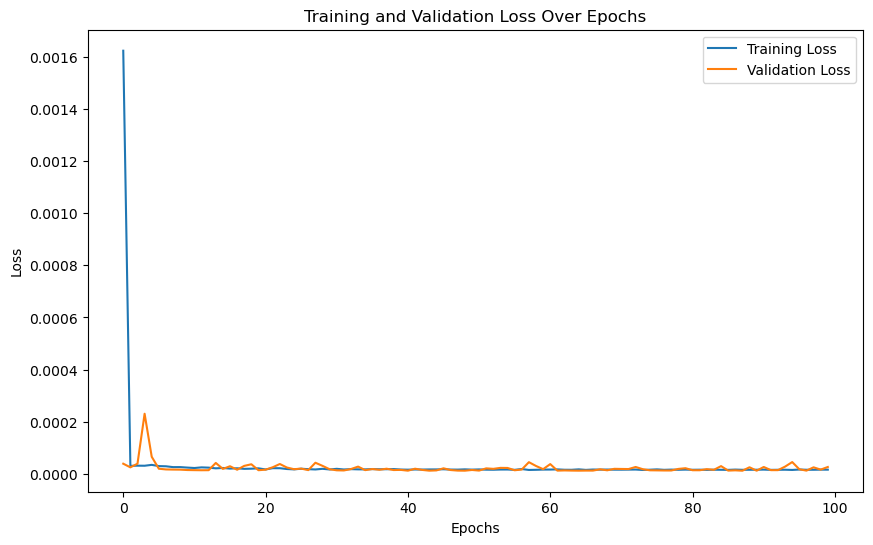

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66905.1004, Test MSE: 60817.1411, Train MAE: 146.7114, Test MAE: 139.8210
Train RMSE: 258.6602, Test RMSE: 246.6113, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5068, Test MAPE: 0.3083
Train Directional Accuracy: 0.4703, Test Directional Accuracy: 0.4697
Training Time: 68.0087 seconds, Eva

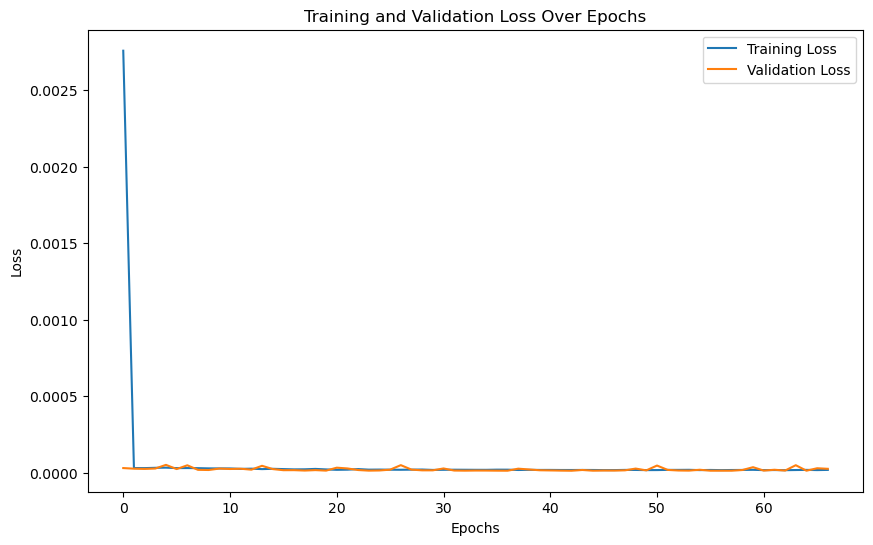

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 78064.3325, Test MSE: 98928.4275, Train MAE: 171.4149, Test MAE: 217.7735
Train RMSE: 279.4000, Test RMSE: 314.5289, Train R2: 0.9997, Test R2: 0.9995
Train MAPE: 0.5812, Test MAPE: 0.4986
Train Directional Accuracy: 0.4680, Test Directional Accuracy: 0.4687
Training Time: 157.6471 seconds, Evaluation Time: 0.1952 seconds



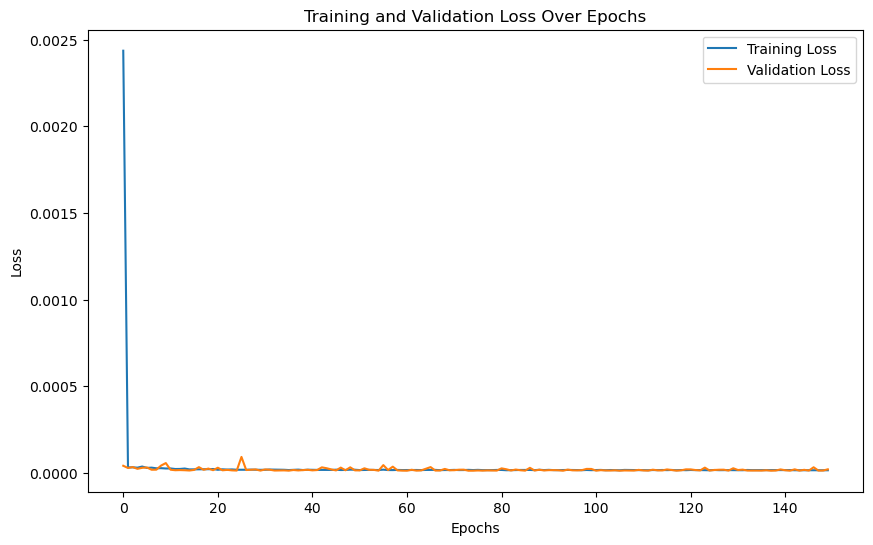

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 78544.6705, Test MSE: 68578.2249, Train MAE: 168.0421, Test MAE: 151.9579
Train RMSE: 280.2582, Test RMSE: 261.8744, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6425, Test MAPE: 0.3450
Train Directional Accuracy: 0.4669, Test Directional Accuracy: 0.4733
Training Time: 67.8193 seconds, Evalu

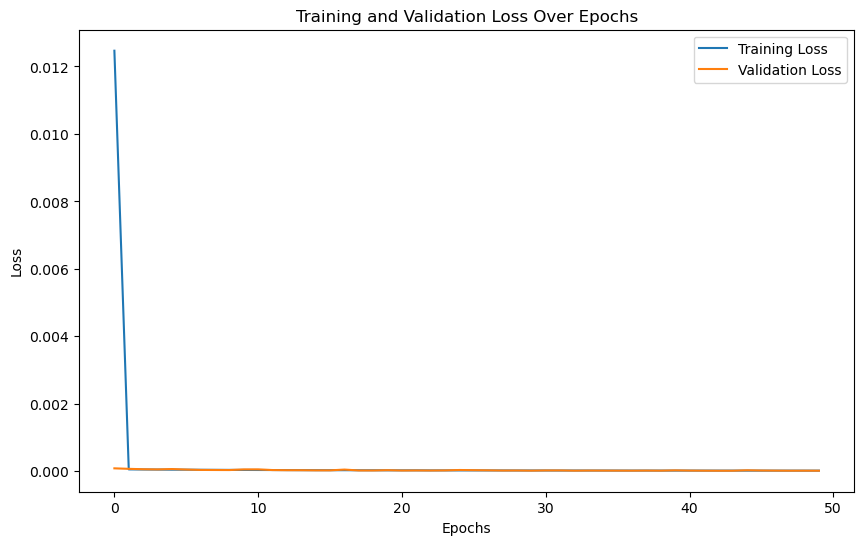

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 71670.4473, Test MSE: 64981.8551, Train MAE: 150.5446, Test MAE: 144.1853
Train RMSE: 267.7134, Test RMSE: 254.9154, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5152, Test MAPE: 0.3191
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4703
Training Time: 72.9498 seconds, Evaluation Time: 0.2177 seconds



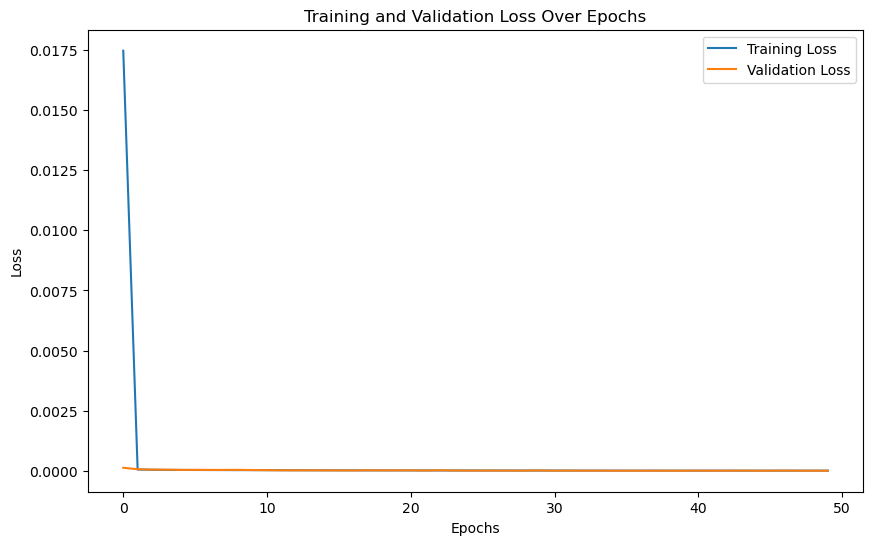

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65833.8146, Test MSE: 61254.4499, Train MAE: 142.7531, Test MAE: 139.8432
Train RMSE: 256.5810, Test RMSE: 247.4964, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4781, Test MAPE: 0.3075
Train Directional Accuracy: 0.4708, Test Directional Accuracy: 0.4681
Training Time: 126.9697 seconds, Ev

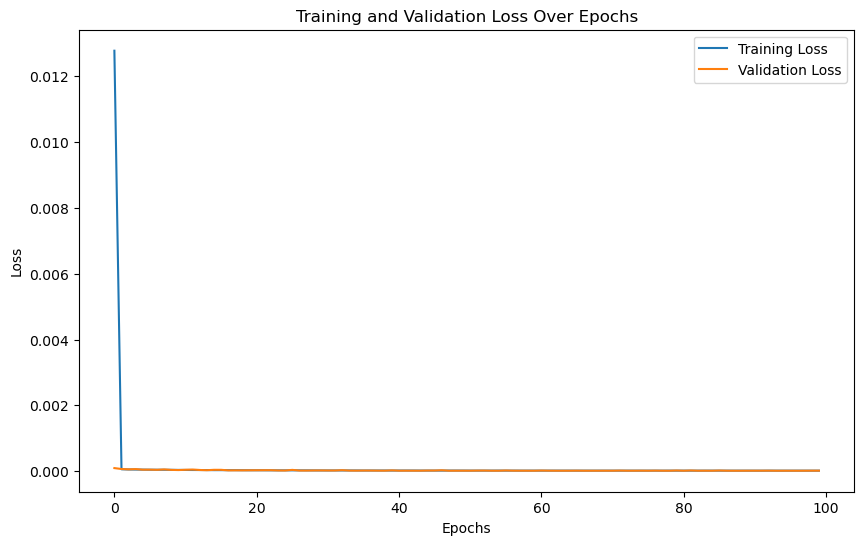

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67875.8208, Test MSE: 62909.0098, Train MAE: 151.3401, Test MAE: 146.6735
Train RMSE: 260.5299, Test RMSE: 250.8167, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5428, Test MAPE: 0.3294
Train Directional Accuracy: 0.4715, Test Directional Accuracy: 0.4713
Training Time: 104.4550 seconds, Evaluation Time: 0.1881 seconds



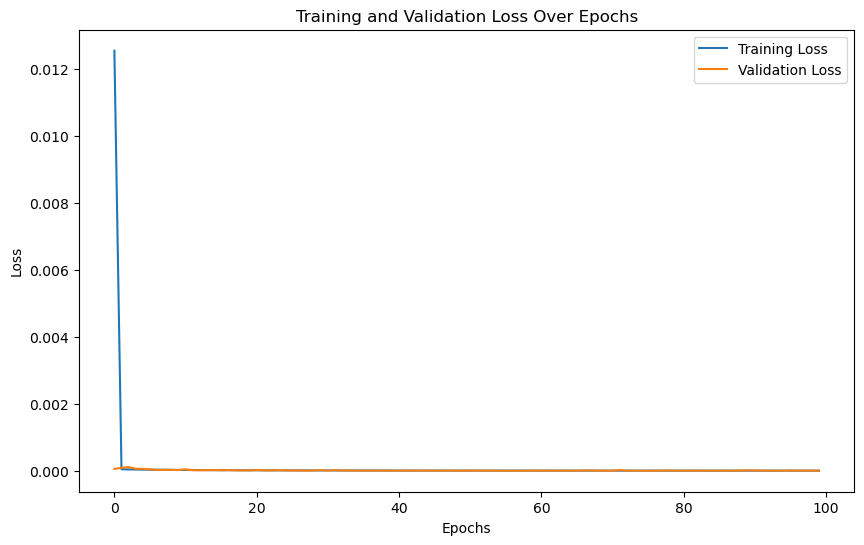

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65173.6834, Test MSE: 60544.4391, Train MAE: 146.2180, Test MAE: 140.1452
Train RMSE: 255.2914, Test RMSE: 246.0578, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5205, Test MAPE: 0.3100
Train Directional Accuracy: 0.4684, Test Directional Accuracy: 0.4681
Training Time: 176.9352 seconds, Ev

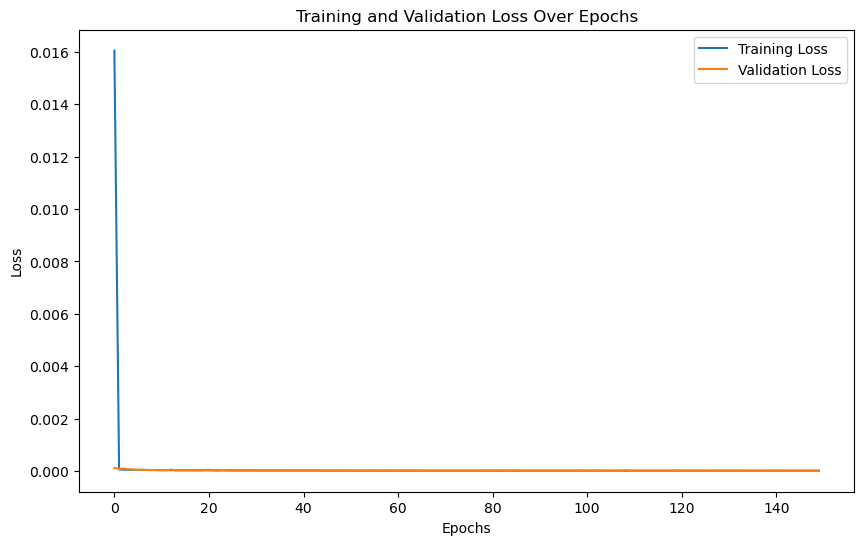

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 113437.5166, Test MSE: 147563.2819, Train MAE: 249.7155, Test MAE: 308.8029
Train RMSE: 336.8049, Test RMSE: 384.1397, Train R2: 0.9996, Test R2: 0.9993
Train MAPE: 0.9804, Test MAPE: 0.7473
Train Directional Accuracy: 0.4690, Test Directional Accuracy: 0.4705
Training Time: 160.8109 seconds, Evaluation Time: 0.1892 seconds



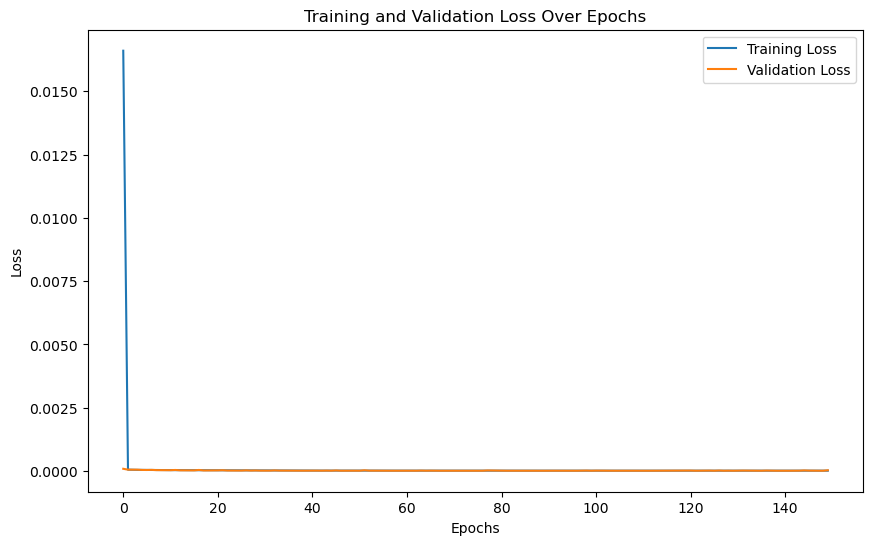

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65316.9825, Test MSE: 61236.4904, Train MAE: 146.0060, Test MAE: 139.9546
Train RMSE: 255.5719, Test RMSE: 247.4601, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5163, Test MAPE: 0.3075
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4668
Training Time: 52.7282 seconds, Evaluat

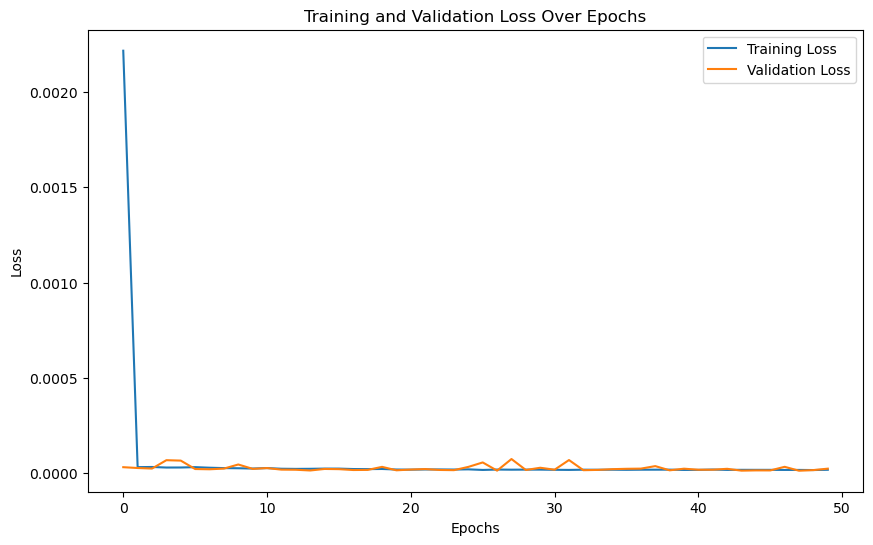

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 106387.5287, Test MSE: 118893.6429, Train MAE: 219.0336, Test MAE: 270.9986
Train RMSE: 326.1710, Test RMSE: 344.8096, Train R2: 0.9996, Test R2: 0.9994
Train MAPE: 0.7424, Test MAPE: 0.6658
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4695
Training Time: 65.3059 seconds, Evaluation Time: 0.2142 seconds



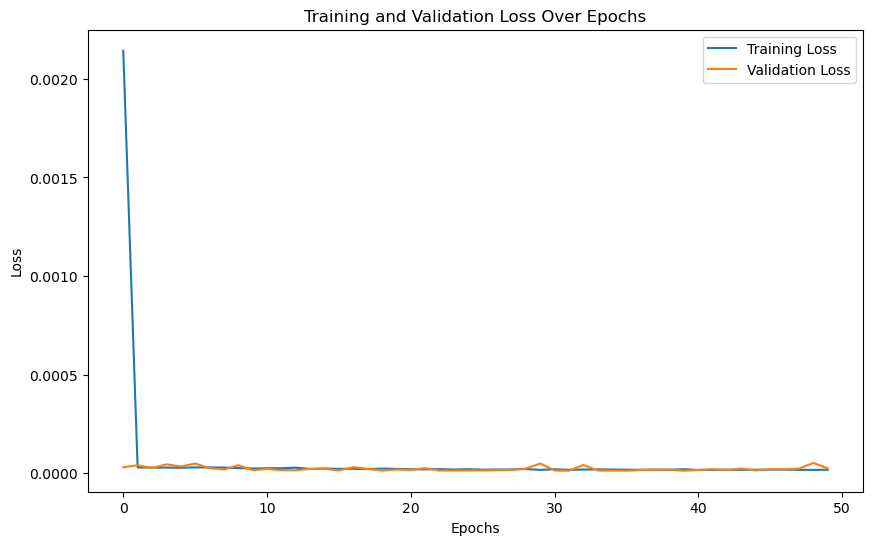

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64921.5229, Test MSE: 60516.7837, Train MAE: 142.8388, Test MAE: 139.2657
Train RMSE: 254.7970, Test RMSE: 246.0016, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4819, Test MAPE: 0.3072
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4683
Training Time: 124.9170 seconds, Eval

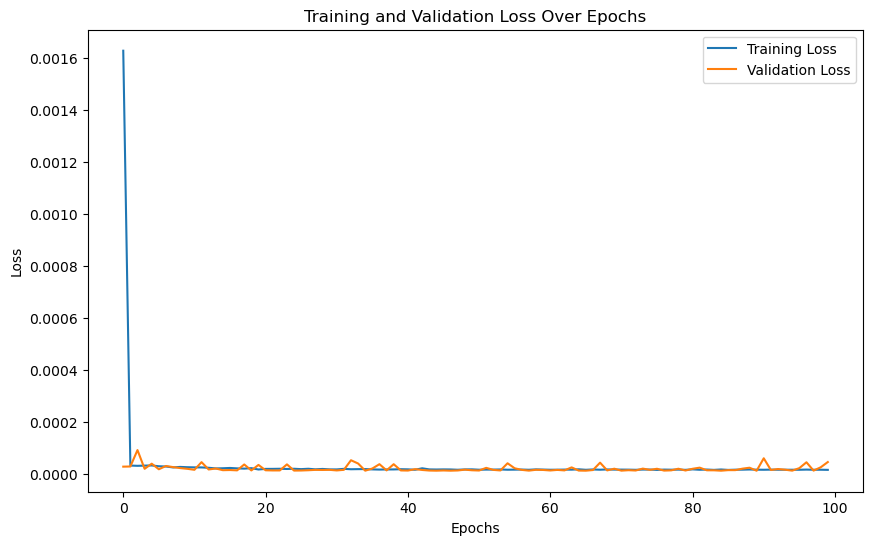

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64062.5492, Test MSE: 65204.1105, Train MAE: 139.9699, Test MAE: 144.9821
Train RMSE: 253.1058, Test RMSE: 255.3510, Train R2: 0.9998, Test R2: 0.9997
Train MAPE: 0.4649, Test MAPE: 0.3139
Train Directional Accuracy: 0.4702, Test Directional Accuracy: 0.4701
Training Time: 115.5110 seconds, Evaluation Time: 0.2179 seconds



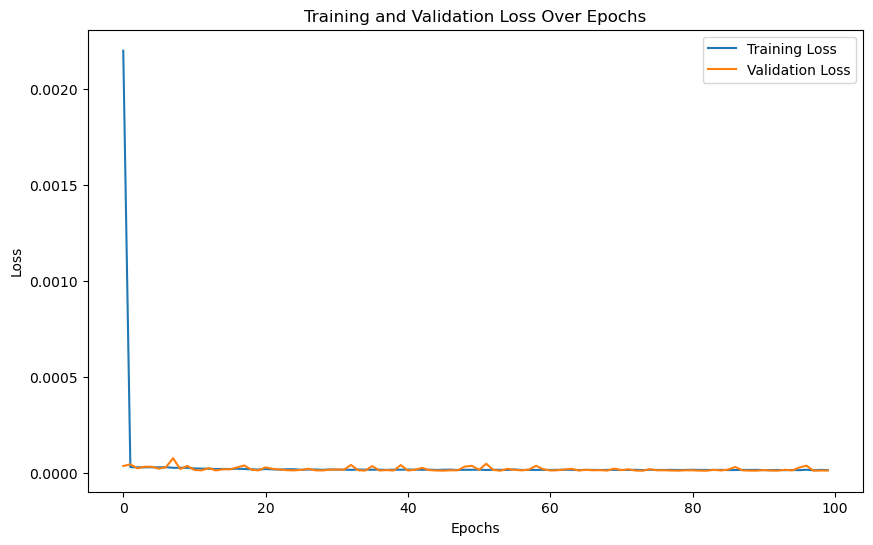

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65826.3540, Test MSE: 60716.9730, Train MAE: 150.9478, Test MAE: 140.2808
Train RMSE: 256.5665, Test RMSE: 246.4081, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5667, Test MAPE: 0.3098
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4693
Training Time: 102.0206 seconds, Eval

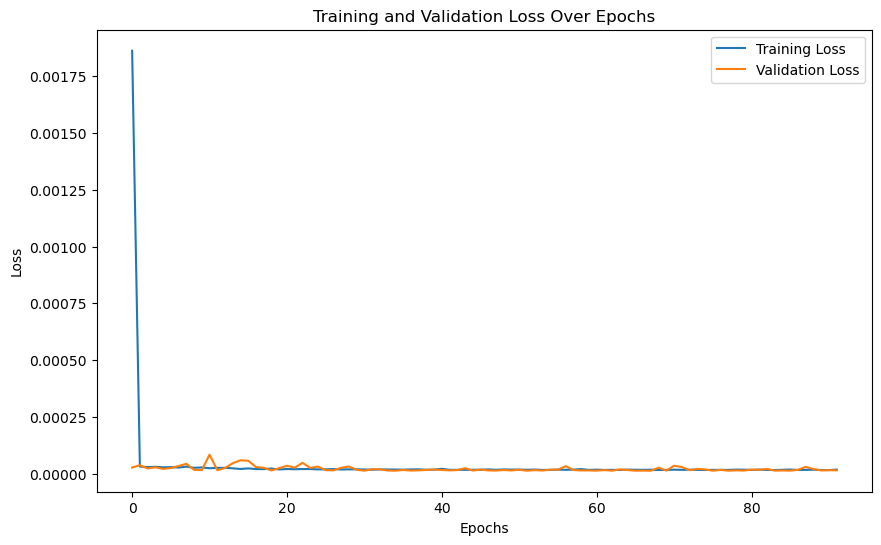

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68976.3967, Test MSE: 64952.6446, Train MAE: 150.5607, Test MAE: 150.6107
Train RMSE: 262.6336, Test RMSE: 254.8581, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5141, Test MAPE: 0.3373
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4676
Training Time: 189.9558 seconds, Evaluation Time: 0.2067 seconds



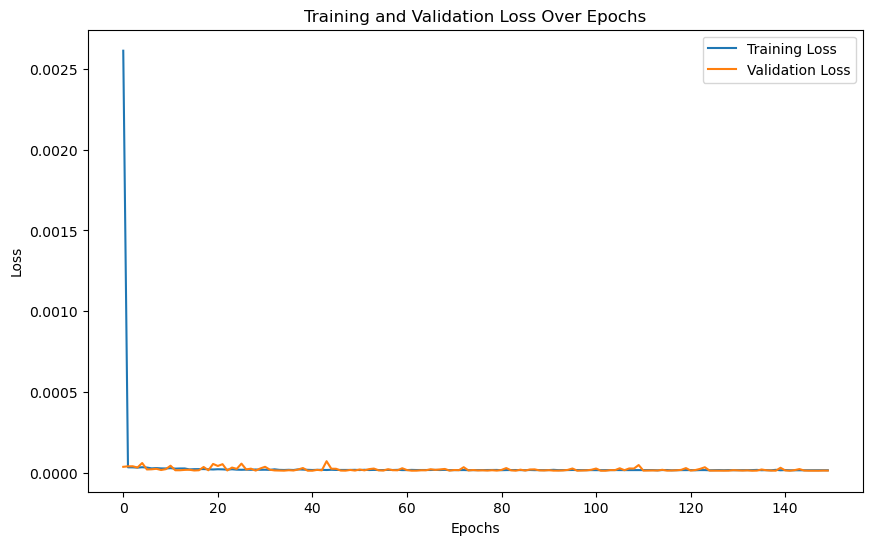

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 76061.2405, Test MSE: 67417.3214, Train MAE: 158.1719, Test MAE: 148.1135
Train RMSE: 275.7920, Test RMSE: 259.6485, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5548, Test MAPE: 0.3325
Train Directional Accuracy: 0.4678, Test Directional Accuracy: 0.4738
Training Time: 60.1736 seconds, Eva

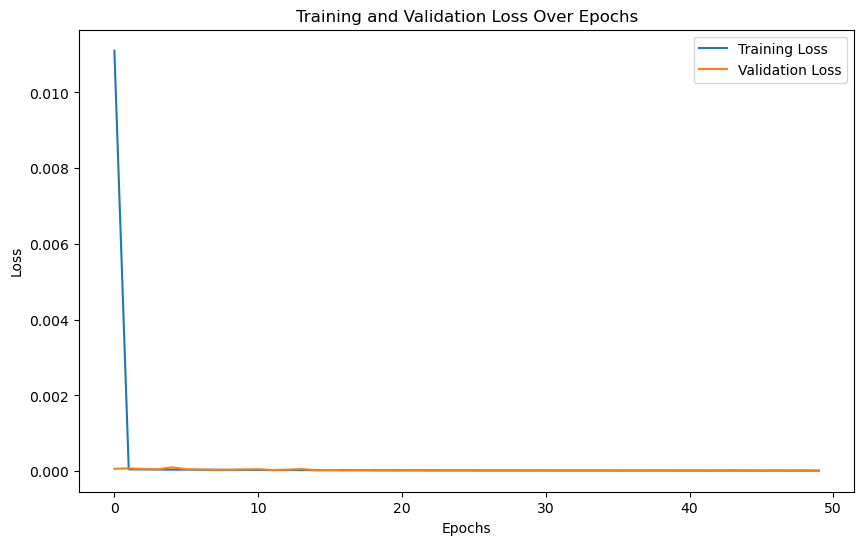

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72802.9303, Test MSE: 66114.6538, Train MAE: 157.2898, Test MAE: 150.1352
Train RMSE: 269.8202, Test RMSE: 257.1277, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5617, Test MAPE: 0.3414
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4689
Training Time: 53.4460 seconds, Evaluation Time: 0.1987 seconds



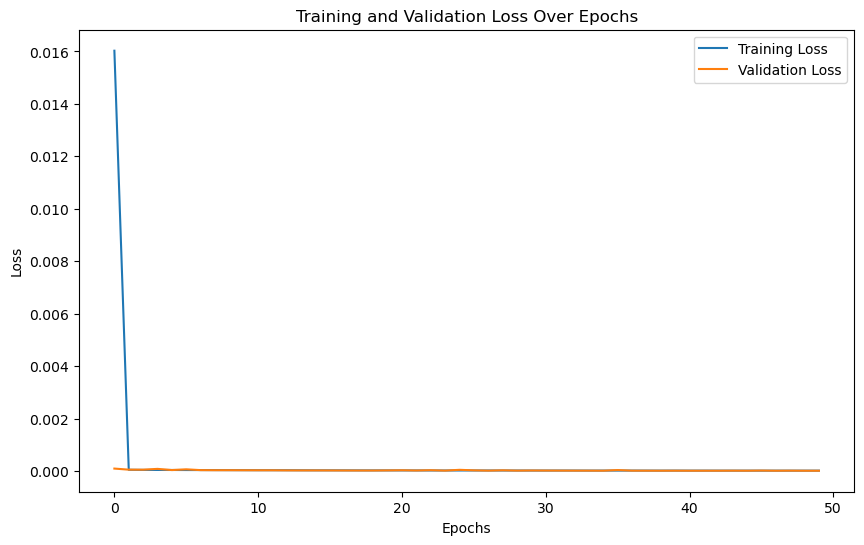

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66497.5335, Test MSE: 61651.0490, Train MAE: 143.7486, Test MAE: 140.3207
Train RMSE: 257.8712, Test RMSE: 248.2963, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4846, Test MAPE: 0.3095
Train Directional Accuracy: 0.4735, Test Directional Accuracy: 0.4697
Training Time: 130.7919 seconds, 

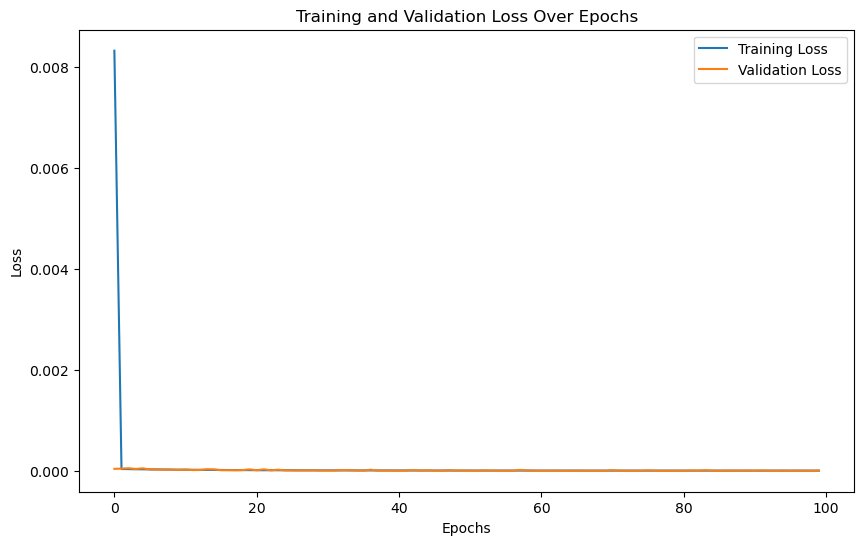

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 69042.0610, Test MSE: 63907.0194, Train MAE: 154.5439, Test MAE: 150.5044
Train RMSE: 262.7586, Test RMSE: 252.7984, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5630, Test MAPE: 0.3406
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4707
Training Time: 130.2470 seconds, Evaluation Time: 0.2137 seconds



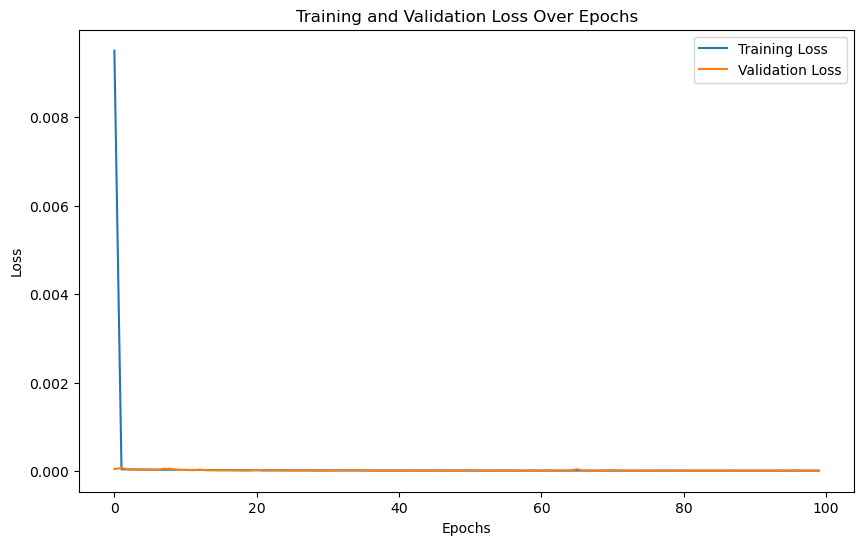

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66423.2476, Test MSE: 60986.6655, Train MAE: 151.5035, Test MAE: 140.6496
Train RMSE: 257.7271, Test RMSE: 246.9548, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5729, Test MAPE: 0.3112
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4705
Training Time: 197.5394 seconds, 

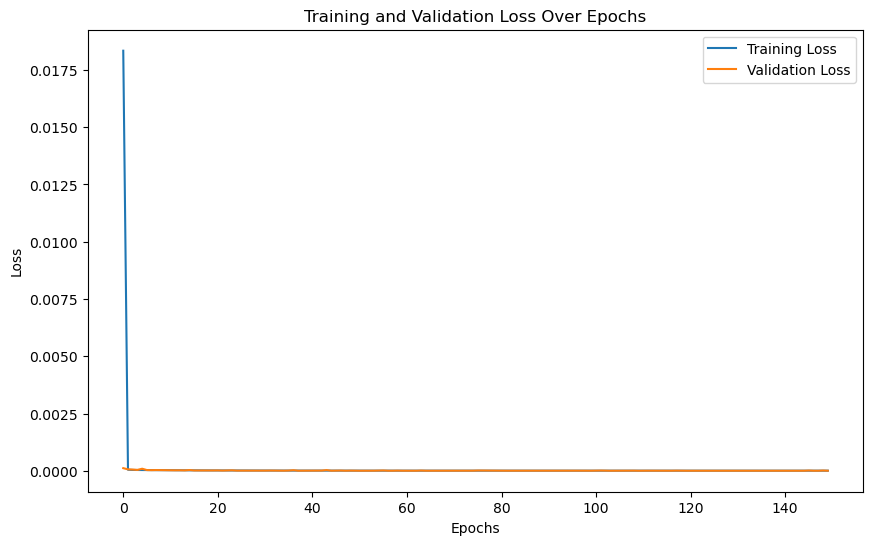

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64737.1511, Test MSE: 60295.2045, Train MAE: 141.1639, Test MAE: 138.5809
Train RMSE: 254.4350, Test RMSE: 245.5508, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4712, Test MAPE: 0.3045
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4679
Training Time: 167.0544 seconds, Evaluation Time: 0.1962 seconds



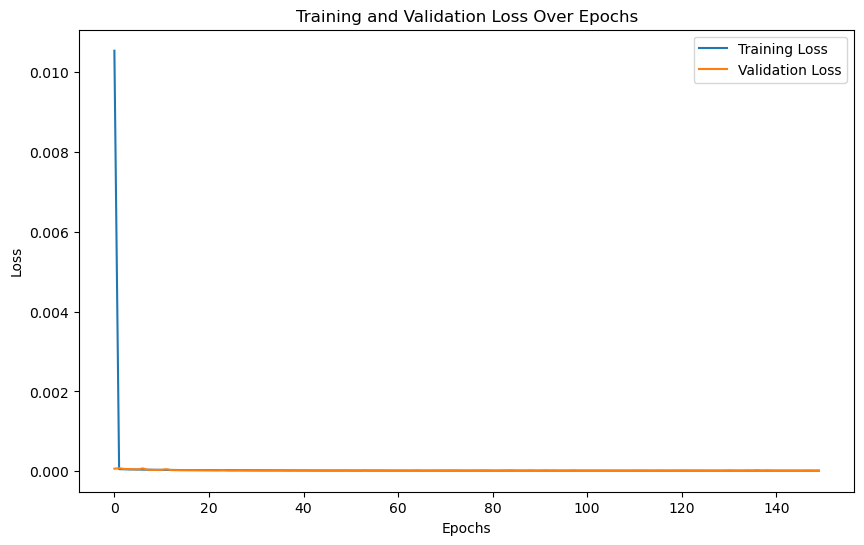

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68199.7701, Test MSE: 60447.2287, Train MAE: 152.8686, Test MAE: 139.0619
Train RMSE: 261.1509, Test RMSE: 245.8602, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5327, Test MAPE: 0.3067
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4687
Training Time: 58.0122 seconds, Evalu

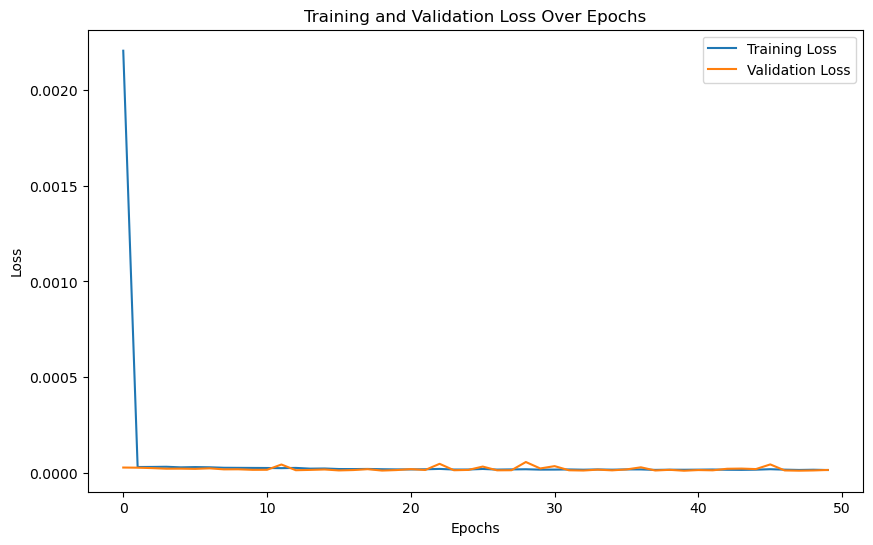

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74560.8210, Test MSE: 67102.4441, Train MAE: 171.9241, Test MAE: 155.3572
Train RMSE: 273.0583, Test RMSE: 259.0414, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6847, Test MAPE: 0.3538
Train Directional Accuracy: 0.4719, Test Directional Accuracy: 0.4643
Training Time: 54.0944 seconds, Evaluation Time: 0.2047 seconds



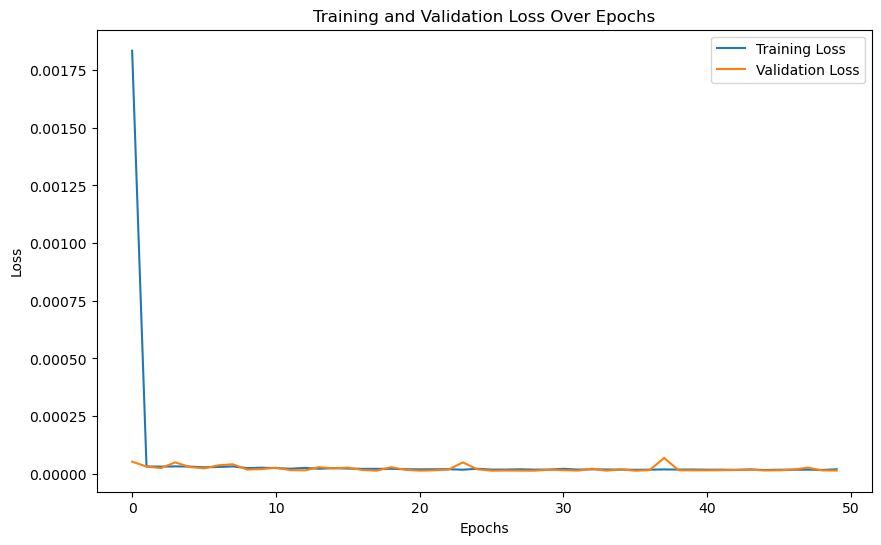

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67180.0518, Test MSE: 62355.2311, Train MAE: 154.3812, Test MAE: 147.3335
Train RMSE: 259.1911, Test RMSE: 249.7103, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5883, Test MAPE: 0.3356
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4691
Training Time: 75.7704 seconds, Eva

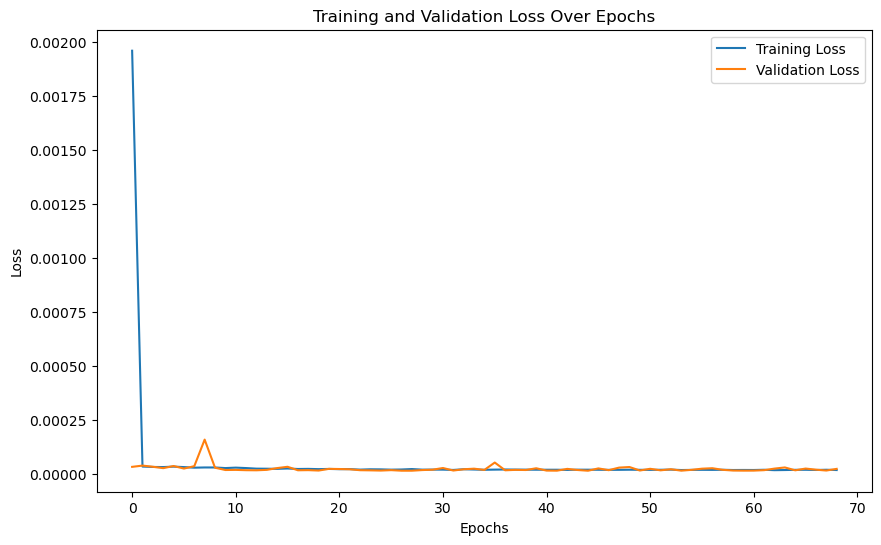

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74633.5778, Test MSE: 65181.8032, Train MAE: 179.8219, Test MAE: 160.2673
Train RMSE: 273.1915, Test RMSE: 255.3073, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.7489, Test MAPE: 0.3741
Train Directional Accuracy: 0.4709, Test Directional Accuracy: 0.4675
Training Time: 105.7271 seconds, Evaluation Time: 0.1972 seconds



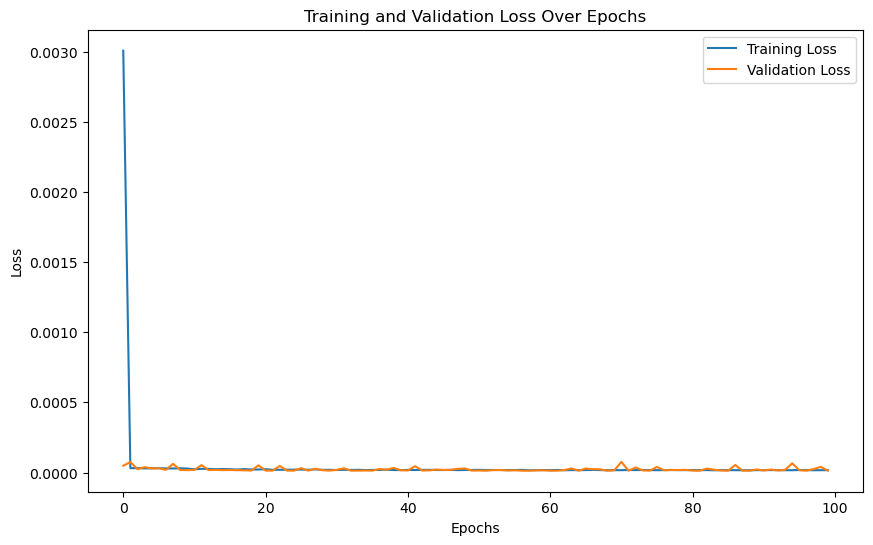

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67732.6394, Test MSE: 60858.4148, Train MAE: 152.8337, Test MAE: 139.5824
Train RMSE: 260.2550, Test RMSE: 246.6950, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5675, Test MAPE: 0.3086
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4681
Training Time: 82.2246 seconds, Eva

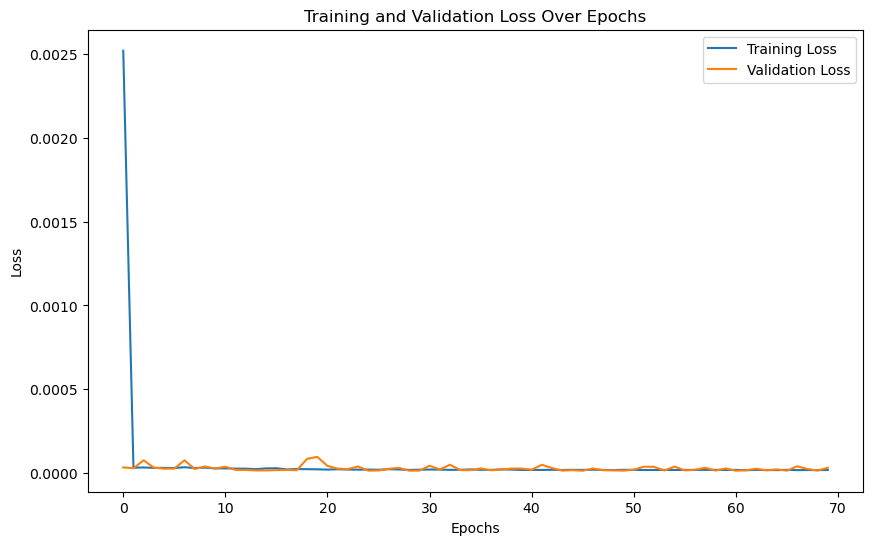

Finished model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64151.3446, Test MSE: 66828.9604, Train MAE: 140.9728, Test MAE: 147.0601
Train RMSE: 253.2812, Test RMSE: 258.5130, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4709, Test MAPE: 0.3167
Train Directional Accuracy: 0.4684, Test Directional Accuracy: 0.4673
Training Time: 171.1691 seconds, Evaluation Time: 0.2032 seconds



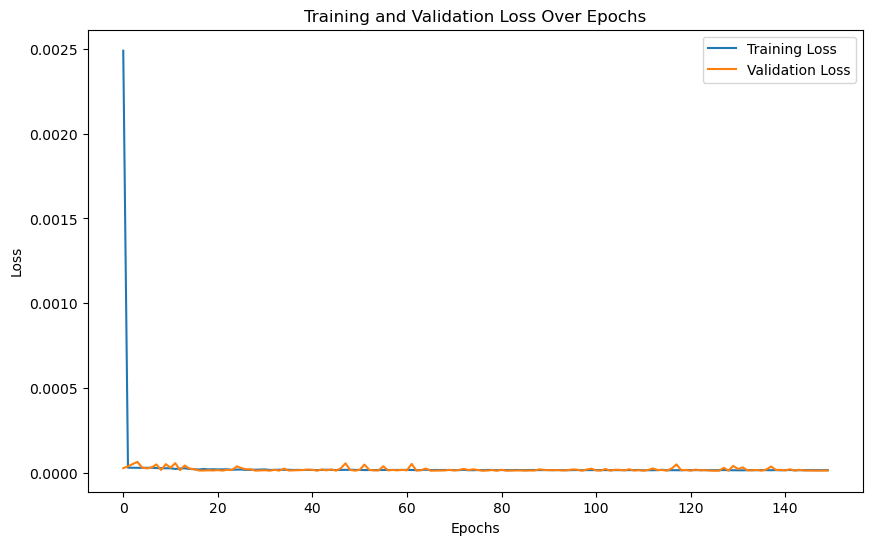

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73740.2158, Test MSE: 66671.0774, Train MAE: 161.3522, Test MAE: 148.1222
Train RMSE: 271.5515, Test RMSE: 258.2074, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6190, Test MAPE: 0.3301
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4687
Training Time: 65.3410 seconds, Evaluat

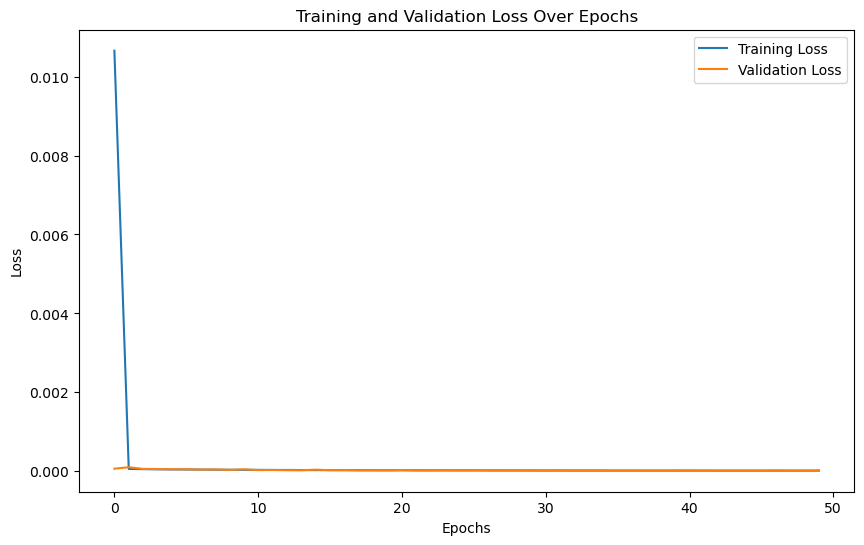

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 81389.6597, Test MSE: 73294.3624, Train MAE: 174.2487, Test MAE: 164.6438
Train RMSE: 285.2887, Test RMSE: 270.7293, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.6495, Test MAPE: 0.3771
Train Directional Accuracy: 0.4687, Test Directional Accuracy: 0.4737
Training Time: 65.0466 seconds, Evaluation Time: 0.5224 seconds



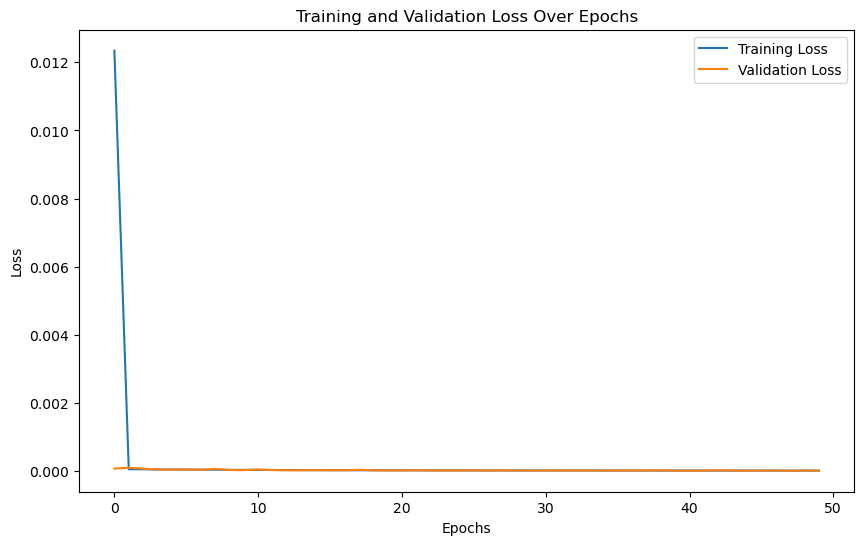

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66079.9568, Test MSE: 61979.1473, Train MAE: 141.9024, Test MAE: 140.4947
Train RMSE: 257.0602, Test RMSE: 248.9561, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4723, Test MAPE: 0.3091
Train Directional Accuracy: 0.4718, Test Directional Accuracy: 0.4689
Training Time: 158.4833 seconds, Eval

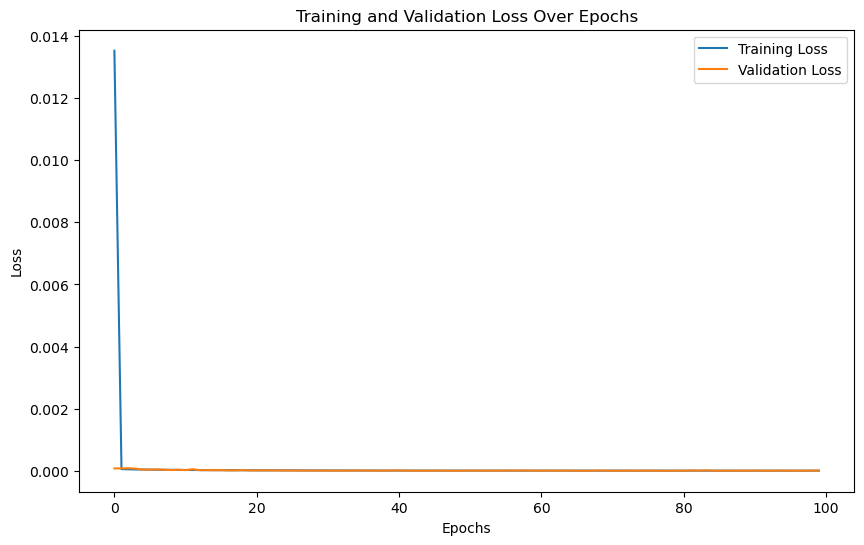

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72265.4399, Test MSE: 67228.1666, Train MAE: 165.5151, Test MAE: 163.9524
Train RMSE: 268.8223, Test RMSE: 259.2839, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6346, Test MAPE: 0.3819
Train Directional Accuracy: 0.4702, Test Directional Accuracy: 0.4688
Training Time: 147.9470 seconds, Evaluation Time: 0.4849 seconds



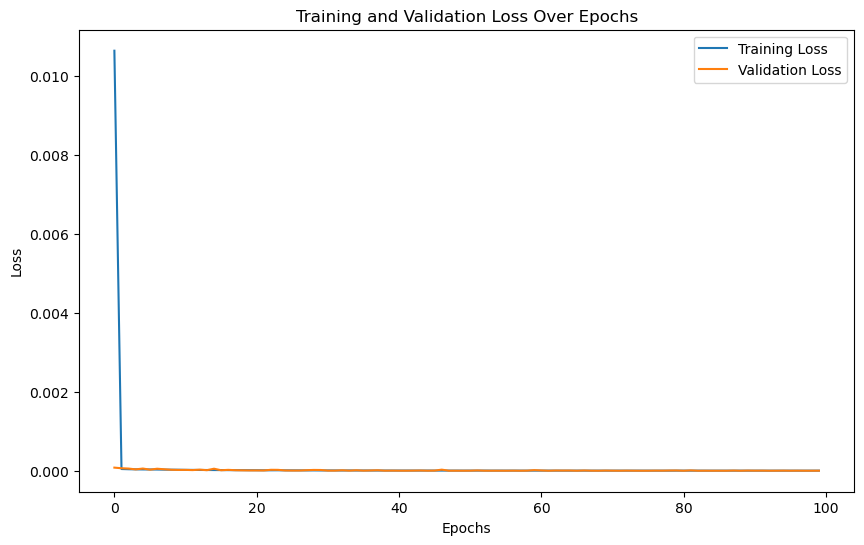

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64844.1965, Test MSE: 60341.3335, Train MAE: 141.3378, Test MAE: 138.8166
Train RMSE: 254.6452, Test RMSE: 245.6447, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4755, Test MAPE: 0.3052
Train Directional Accuracy: 0.4692, Test Directional Accuracy: 0.4680
Training Time: 229.1817 seconds, Eval

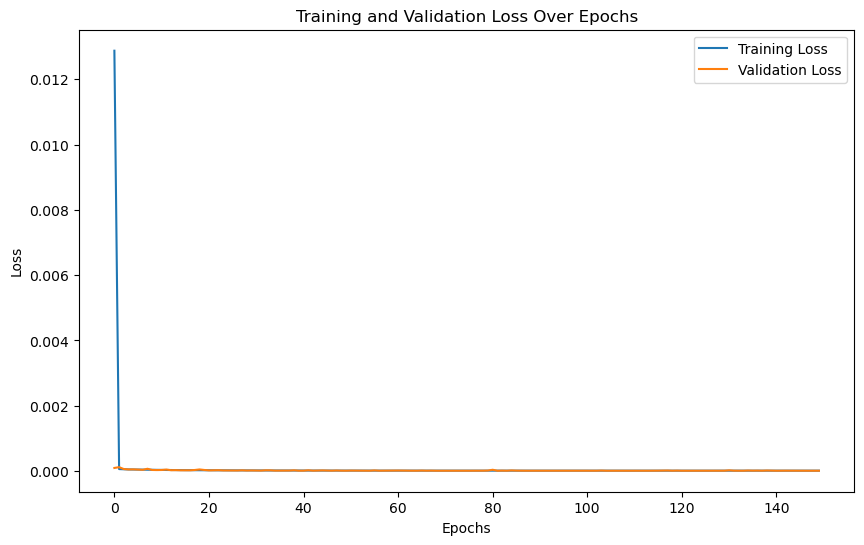

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65008.9964, Test MSE: 60720.6608, Train MAE: 144.0775, Test MAE: 139.1125
Train RMSE: 254.9686, Test RMSE: 246.4156, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5079, Test MAPE: 0.3059
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4700
Training Time: 224.9497 seconds, Evaluation Time: 0.5015 seconds



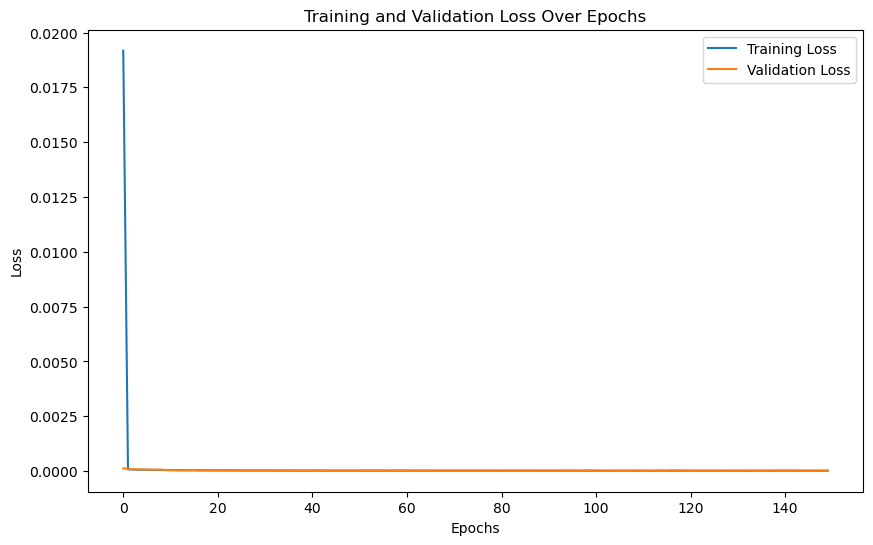

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67193.3307, Test MSE: 62626.3010, Train MAE: 149.4122, Test MAE: 143.2999
Train RMSE: 259.2168, Test RMSE: 250.2525, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5492, Test MAPE: 0.3155
Train Directional Accuracy: 0.4713, Test Directional Accuracy: 0.4695
Training Time: 74.9151 seconds, Evaluatio

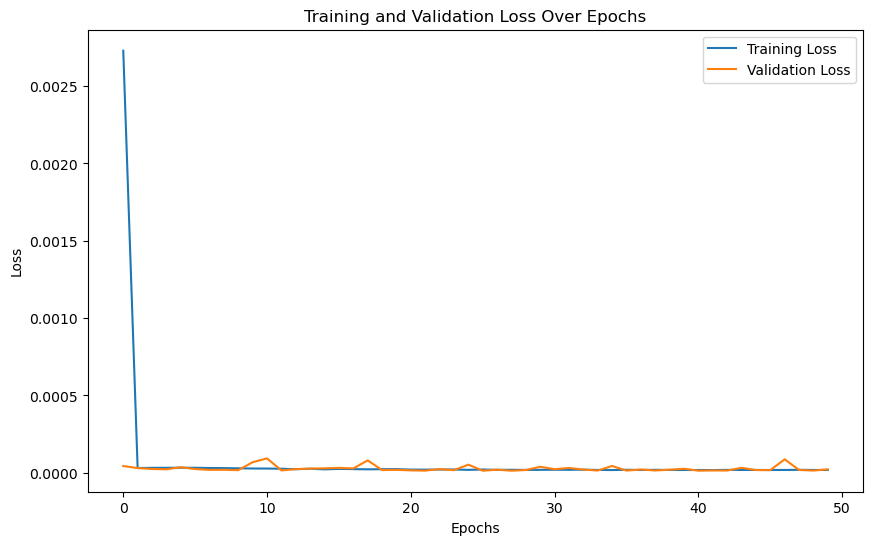

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65521.7835, Test MSE: 63387.1722, Train MAE: 143.8585, Test MAE: 147.9302
Train RMSE: 255.9722, Test RMSE: 251.7681, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4821, Test MAPE: 0.3311
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4679
Training Time: 74.6965 seconds, Evaluation Time: 0.5365 seconds



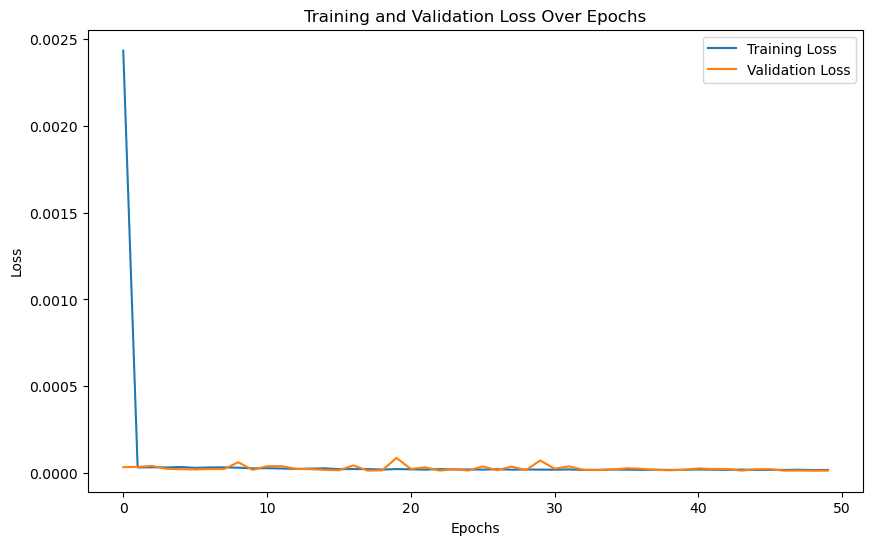

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65396.2368, Test MSE: 60771.6764, Train MAE: 147.4576, Test MAE: 139.9359
Train RMSE: 255.7269, Test RMSE: 246.5191, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5424, Test MAPE: 0.3076
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4684
Training Time: 113.6289 seconds, Evalua

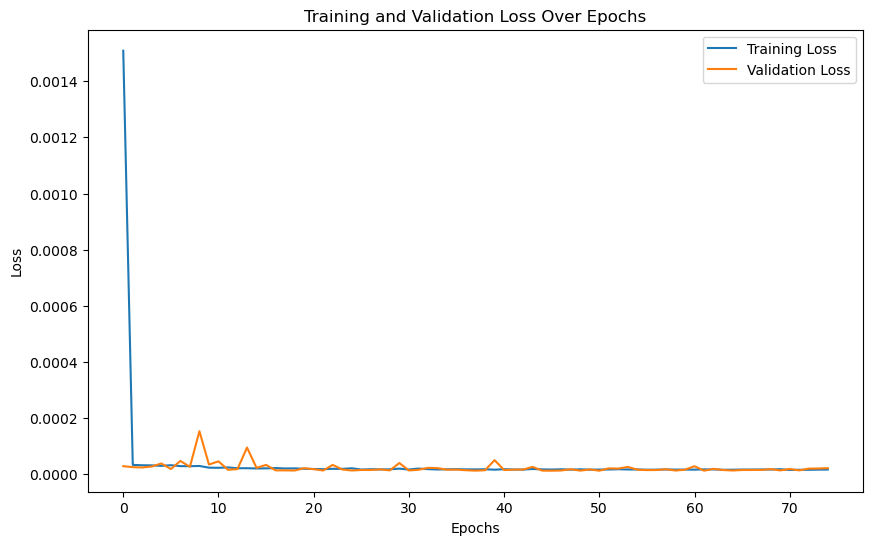

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 77504.7220, Test MSE: 73712.8490, Train MAE: 196.8469, Test MAE: 172.6487
Train RMSE: 278.3967, Test RMSE: 271.5011, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.9559, Test MAPE: 0.4003
Train Directional Accuracy: 0.4688, Test Directional Accuracy: 0.4696
Training Time: 150.9616 seconds, Evaluation Time: 0.5176 seconds



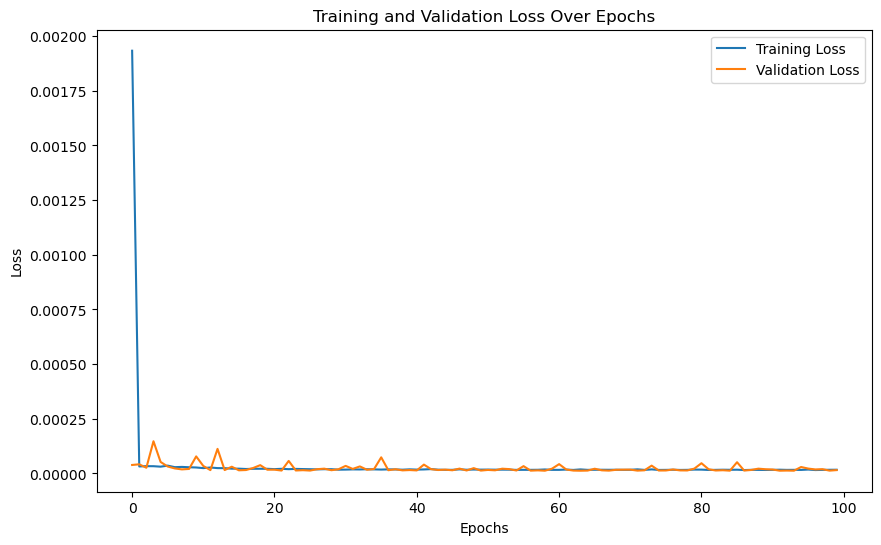

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66007.8830, Test MSE: 60580.5678, Train MAE: 143.3254, Test MAE: 139.7622
Train RMSE: 256.9200, Test RMSE: 246.1312, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4778, Test MAPE: 0.3082
Train Directional Accuracy: 0.4705, Test Directional Accuracy: 0.4687
Training Time: 119.7764 seconds, Evalua

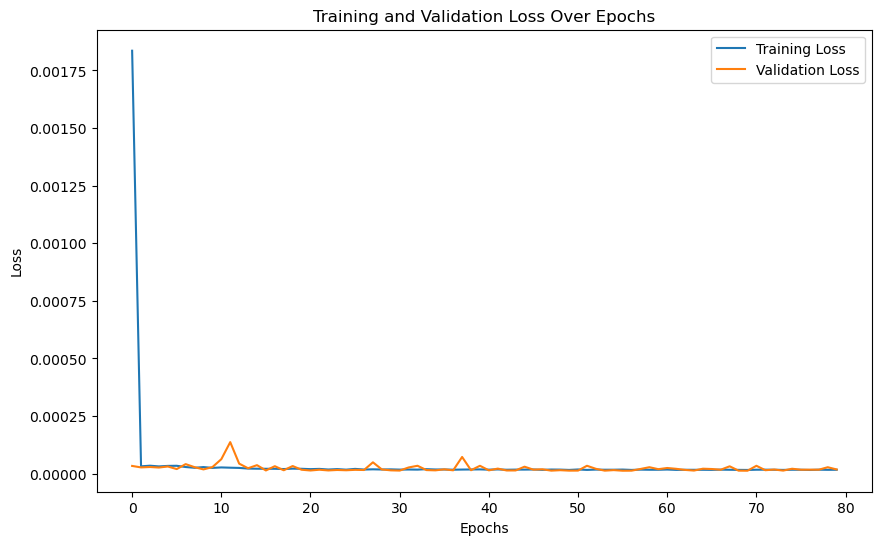

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68600.6808, Test MSE: 62208.0900, Train MAE: 164.4555, Test MAE: 146.0073
Train RMSE: 261.9173, Test RMSE: 249.4155, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6725, Test MAPE: 0.3305
Train Directional Accuracy: 0.4685, Test Directional Accuracy: 0.4692
Training Time: 216.6813 seconds, Evaluation Time: 0.5099 seconds



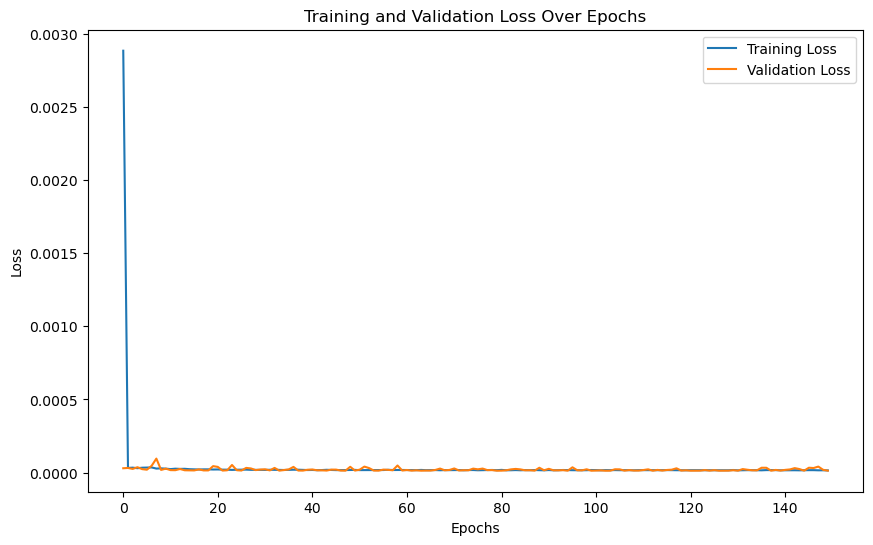

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73235.0024, Test MSE: 66547.0837, Train MAE: 158.2617, Test MAE: 152.1426
Train RMSE: 270.6197, Test RMSE: 257.9672, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5744, Test MAPE: 0.3485
Train Directional Accuracy: 0.4703, Test Directional Accuracy: 0.4696
Training Time: 70.7381 seconds, Evalu

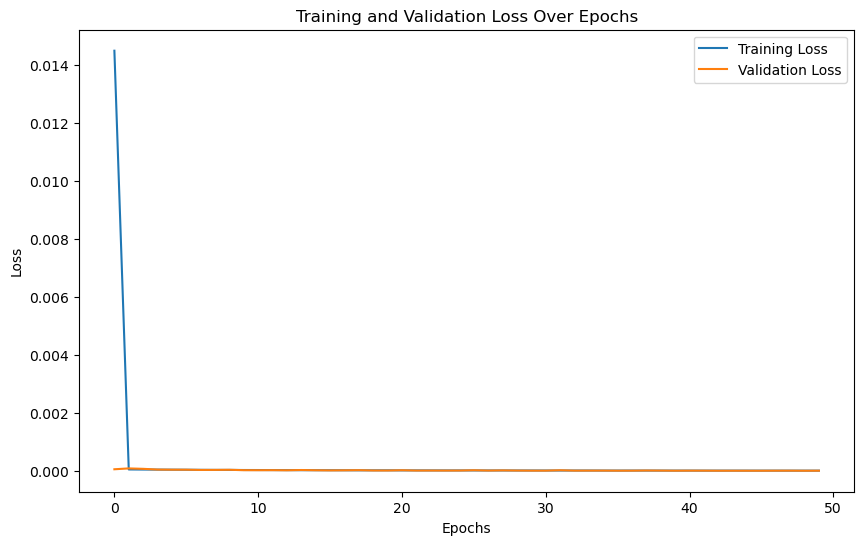

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 81508.7367, Test MSE: 82782.3574, Train MAE: 184.5333, Test MAE: 195.1230
Train RMSE: 285.4973, Test RMSE: 287.7192, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.7199, Test MAPE: 0.4626
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4709
Training Time: 72.5248 seconds, Evaluation Time: 0.4384 seconds



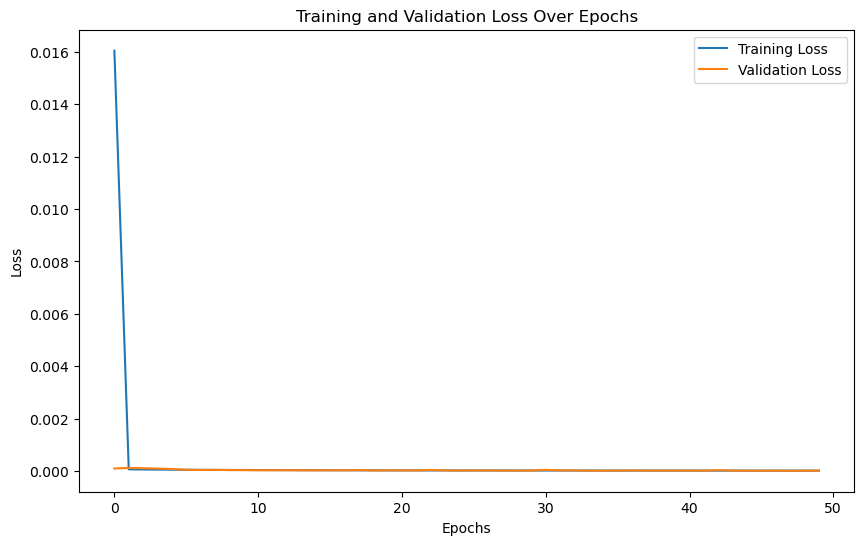

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66601.6741, Test MSE: 62143.2144, Train MAE: 142.5982, Test MAE: 142.0277
Train RMSE: 258.0730, Test RMSE: 249.2854, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4724, Test MAPE: 0.3130
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4712
Training Time: 138.1487 seconds, Ev

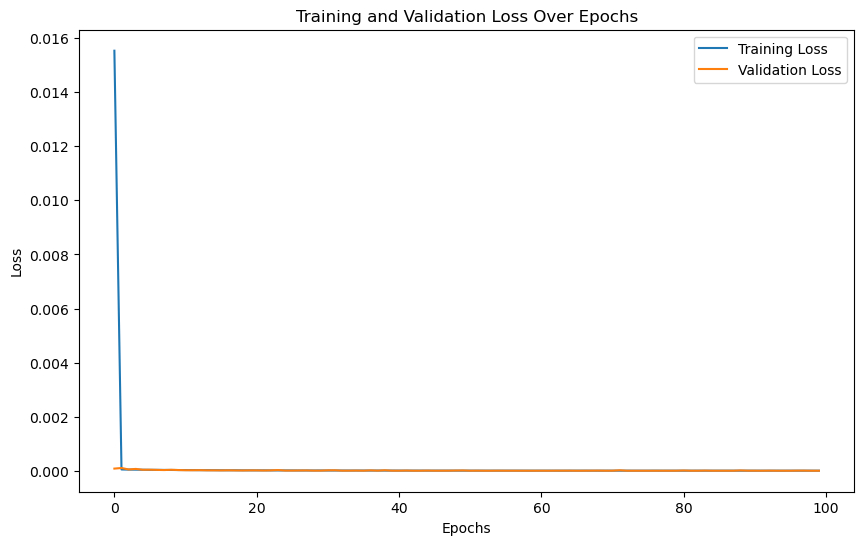

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65690.3315, Test MSE: 63379.6881, Train MAE: 143.7626, Test MAE: 146.5287
Train RMSE: 256.3013, Test RMSE: 251.7532, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4828, Test MAPE: 0.3267
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4720
Training Time: 143.4691 seconds, Evaluation Time: 0.4715 seconds



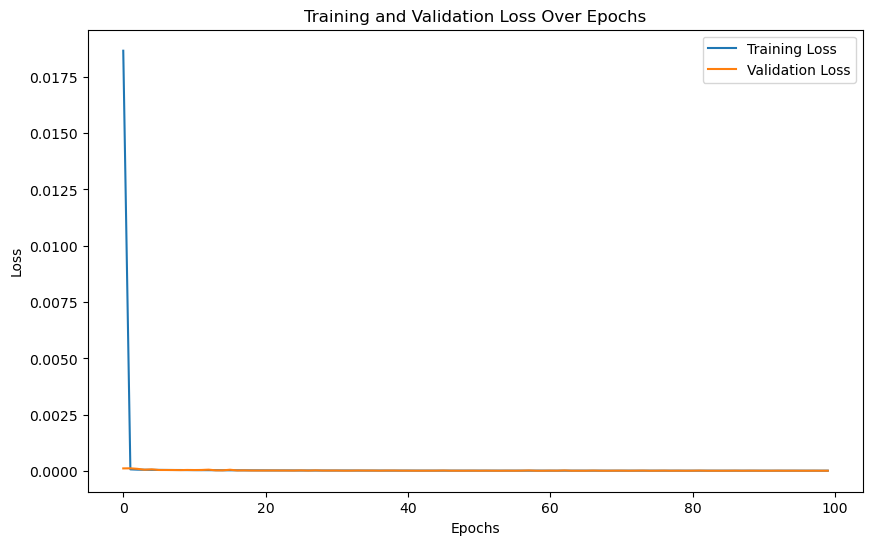

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64844.9686, Test MSE: 60452.9963, Train MAE: 140.6724, Test MAE: 138.7708
Train RMSE: 254.6468, Test RMSE: 245.8719, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4672, Test MAPE: 0.3053
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4672
Training Time: 200.3151 seconds, Ev

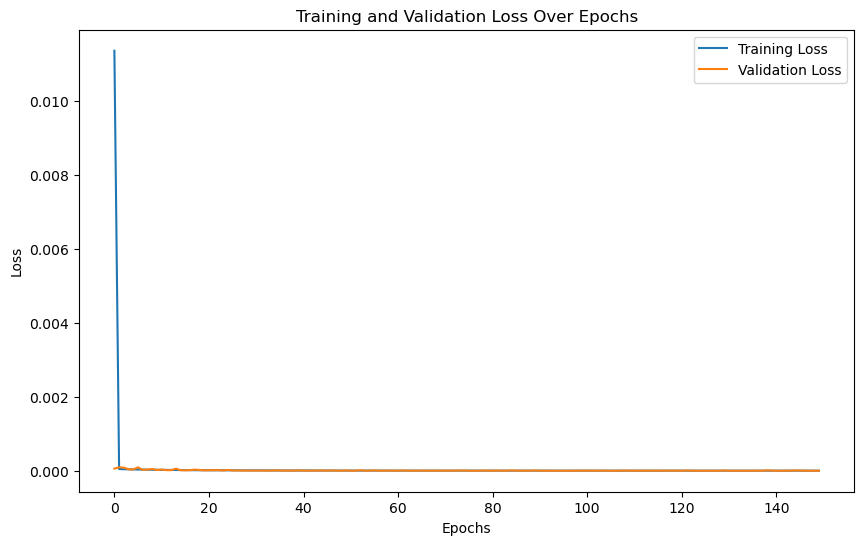

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67768.3175, Test MSE: 65224.2879, Train MAE: 151.1975, Test MAE: 149.5807
Train RMSE: 260.3235, Test RMSE: 255.3905, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5336, Test MAPE: 0.3315
Train Directional Accuracy: 0.4700, Test Directional Accuracy: 0.4666
Training Time: 226.7475 seconds, Evaluation Time: 0.5109 seconds



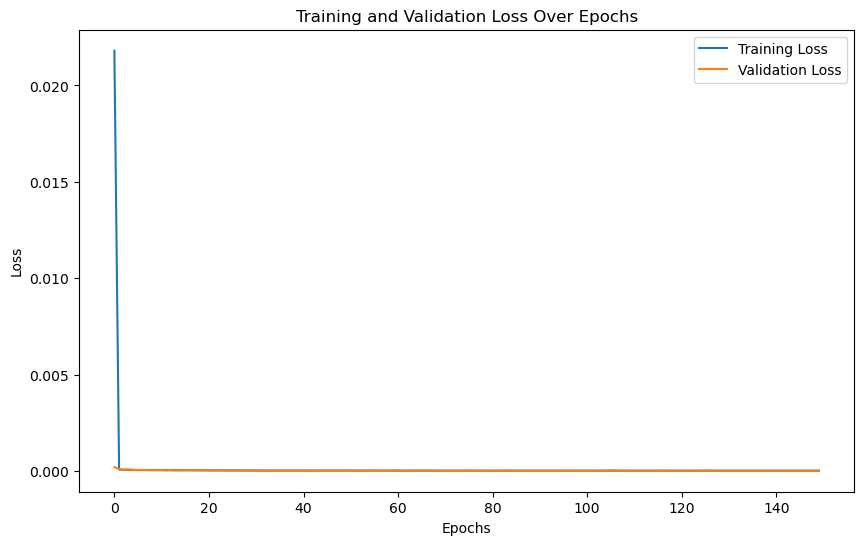

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67947.0670, Test MSE: 61472.9821, Train MAE: 151.0135, Test MAE: 142.4165
Train RMSE: 260.6666, Test RMSE: 247.9375, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5527, Test MAPE: 0.3142
Train Directional Accuracy: 0.4719, Test Directional Accuracy: 0.4689
Training Time: 69.3340 seconds, Evaluat

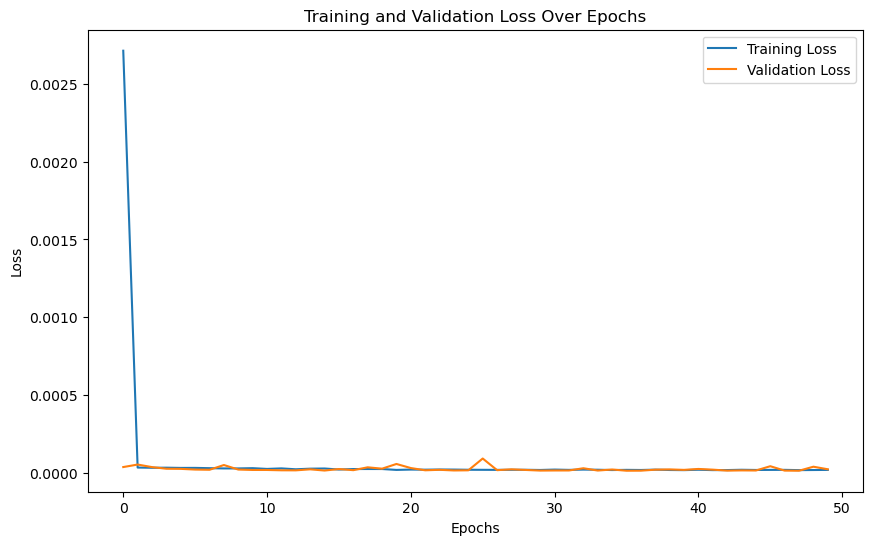

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 70007.7370, Test MSE: 64586.0552, Train MAE: 156.2927, Test MAE: 152.7174
Train RMSE: 264.5898, Test RMSE: 254.1379, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5709, Test MAPE: 0.3449
Train Directional Accuracy: 0.4734, Test Directional Accuracy: 0.4716
Training Time: 97.2245 seconds, Evaluation Time: 0.5150 seconds



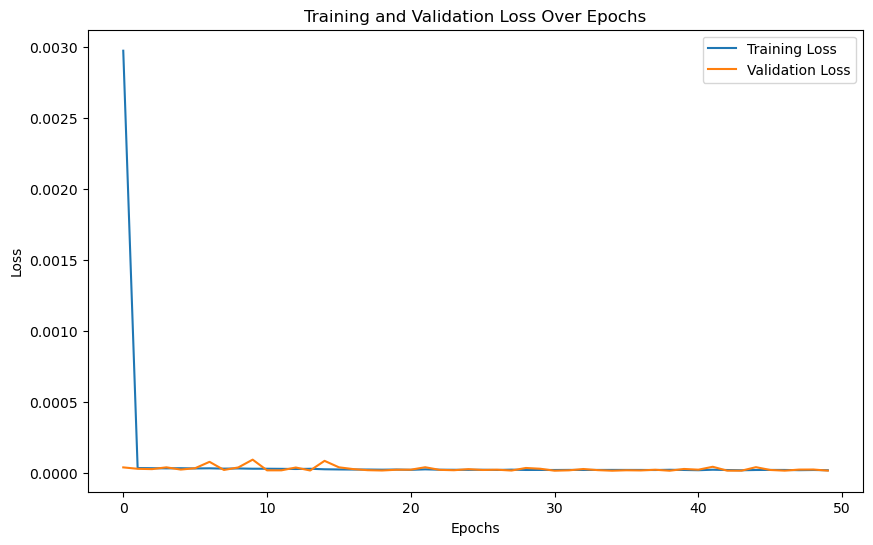

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66413.4189, Test MSE: 61358.5218, Train MAE: 147.4704, Test MAE: 143.4678
Train RMSE: 257.7080, Test RMSE: 247.7065, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5097, Test MAPE: 0.3193
Train Directional Accuracy: 0.4713, Test Directional Accuracy: 0.4680
Training Time: 141.9089 seconds, Eval

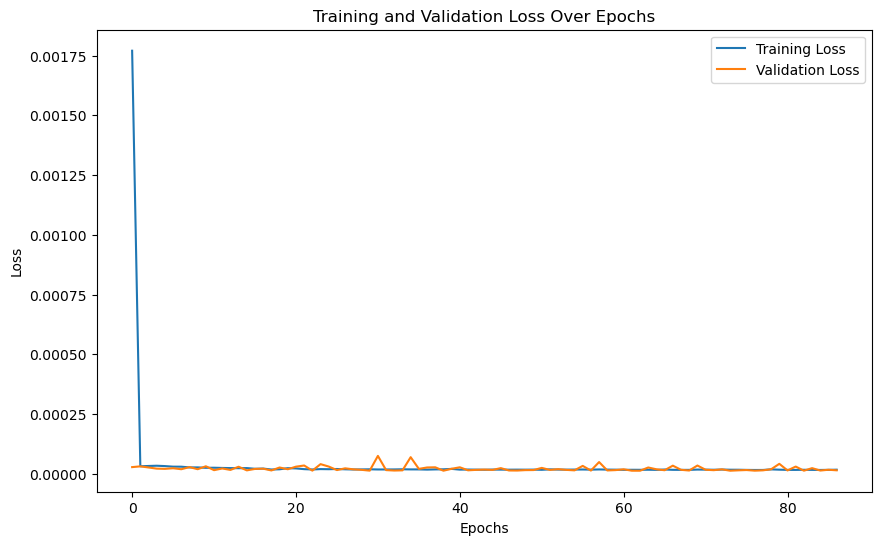

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65704.6168, Test MSE: 60741.6402, Train MAE: 142.4482, Test MAE: 139.6085
Train RMSE: 256.3291, Test RMSE: 246.4582, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4746, Test MAPE: 0.3095
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4648
Training Time: 169.7644 seconds, Evaluation Time: 0.6337 seconds



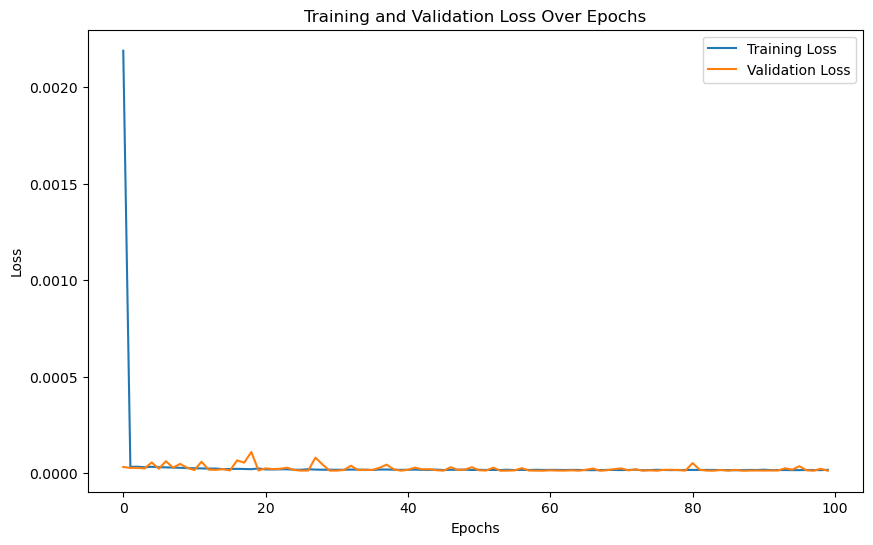

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68368.0804, Test MSE: 62538.3230, Train MAE: 152.7062, Test MAE: 144.9145
Train RMSE: 261.4729, Test RMSE: 250.0766, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5496, Test MAPE: 0.3218
Train Directional Accuracy: 0.4683, Test Directional Accuracy: 0.4695
Training Time: 94.8100 seconds, Evalu

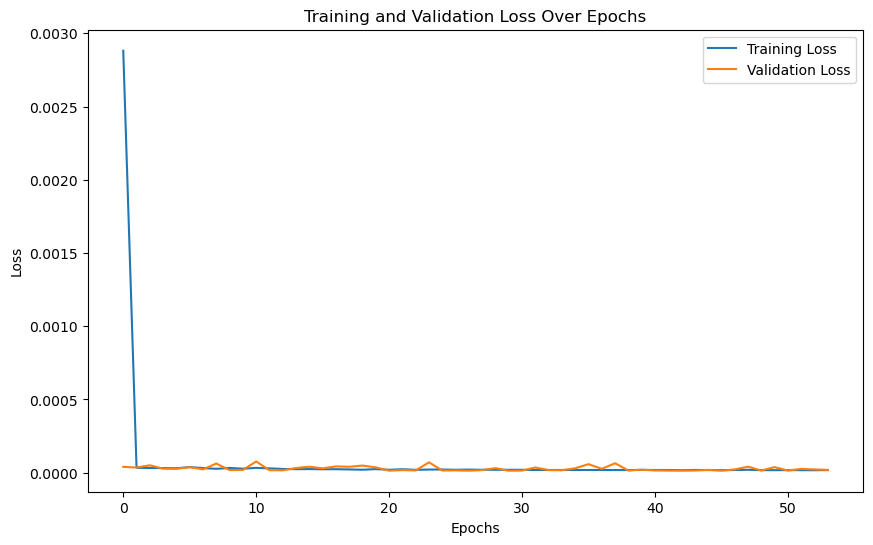

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 96, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 71640.0994, Test MSE: 80187.7820, Train MAE: 162.8461, Test MAE: 189.6439
Train RMSE: 267.6567, Test RMSE: 283.1745, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5578, Test MAPE: 0.4425
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4680
Training Time: 250.8650 seconds, Evaluation Time: 0.5575 seconds



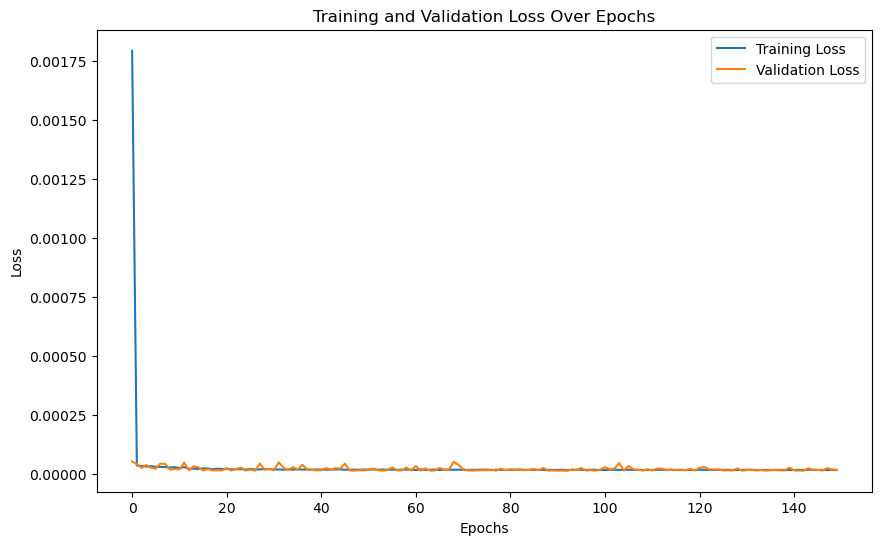

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 71604.9304, Test MSE: 64801.3652, Train MAE: 150.9912, Test MAE: 144.9042
Train RMSE: 267.5910, Test RMSE: 254.5611, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5181, Test MAPE: 0.3224
Train Directional Accuracy: 0.4714, Test Directional Accuracy: 0.4714
Training Time: 78.8186 seconds, Evalu

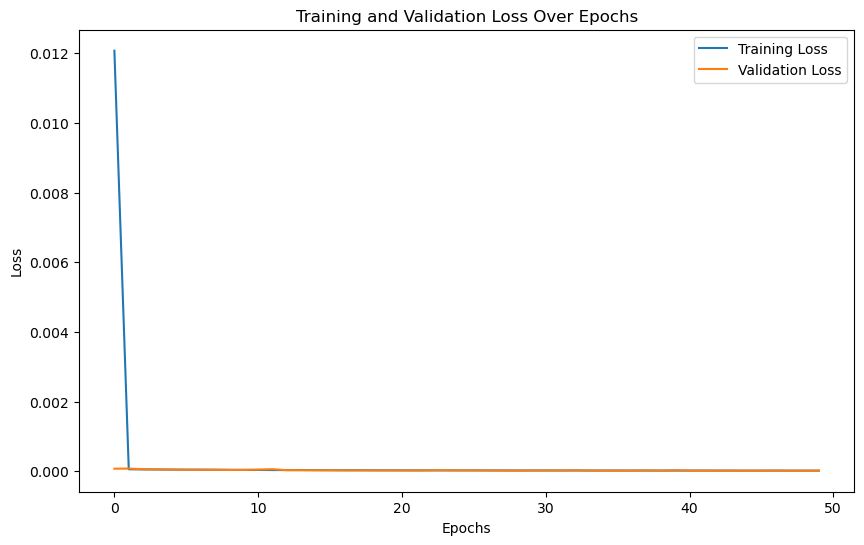

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 77536.8853, Test MSE: 83793.1015, Train MAE: 162.7237, Test MAE: 182.6809
Train RMSE: 278.4545, Test RMSE: 289.4704, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5649, Test MAPE: 0.4054
Train Directional Accuracy: 0.4684, Test Directional Accuracy: 0.4714
Training Time: 78.2751 seconds, Evaluation Time: 0.5626 seconds



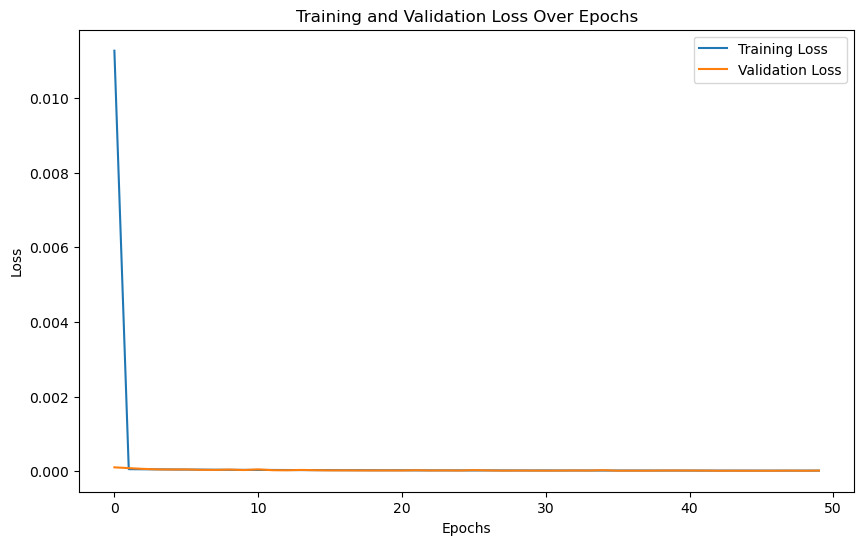

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65141.7299, Test MSE: 61074.5860, Train MAE: 140.5287, Test MAE: 139.5124
Train RMSE: 255.2288, Test RMSE: 247.1327, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4665, Test MAPE: 0.3066
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4695
Training Time: 160.5947 seconds, Ev

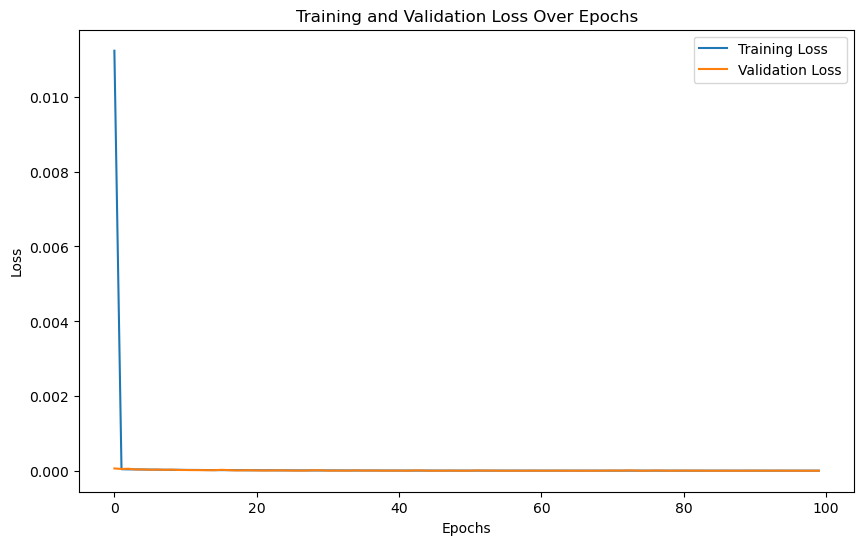

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 88121.3616, Test MSE: 113171.8930, Train MAE: 190.9887, Test MAE: 244.8424
Train RMSE: 296.8524, Test RMSE: 336.4103, Train R2: 0.9997, Test R2: 0.9995
Train MAPE: 0.6550, Test MAPE: 0.5667
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4684
Training Time: 162.5990 seconds, Evaluation Time: 0.6006 seconds



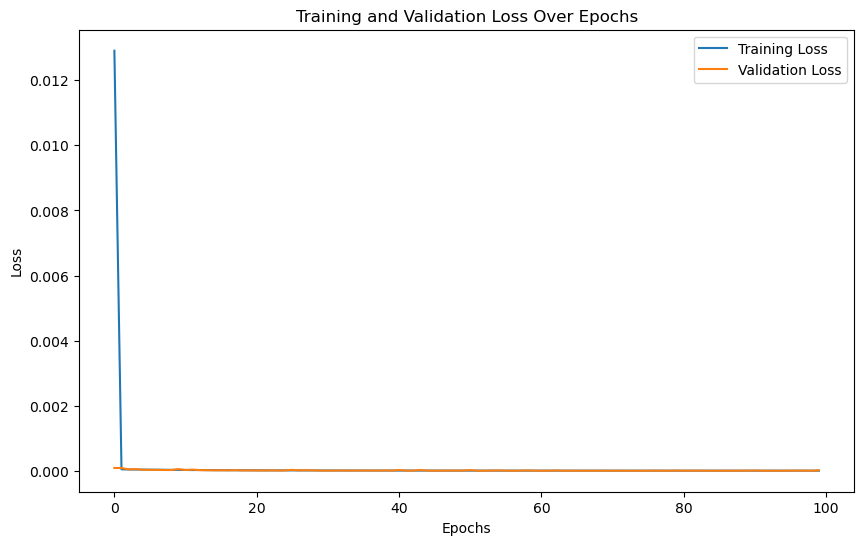

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64636.5758, Test MSE: 60550.8162, Train MAE: 141.8452, Test MAE: 138.7607
Train RMSE: 254.2372, Test RMSE: 246.0708, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4795, Test MAPE: 0.3045
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4683
Training Time: 244.3395 seconds, Ev

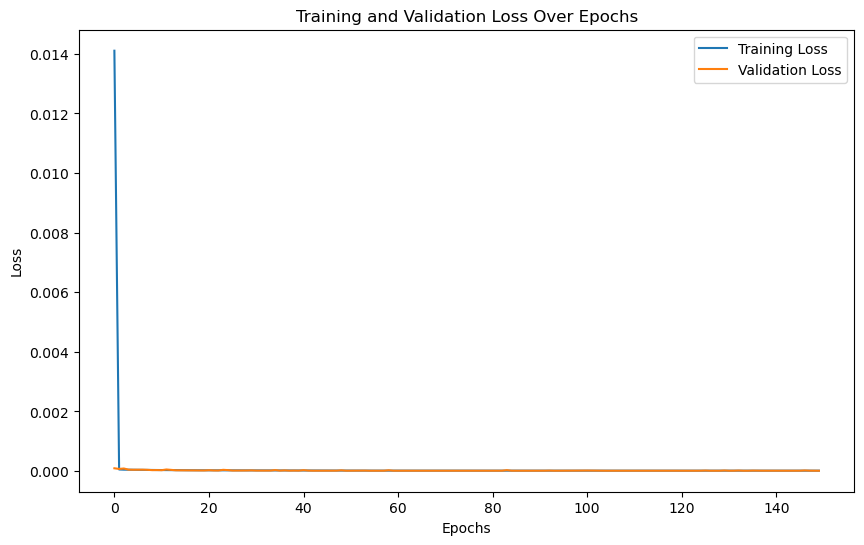

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 77198.2390, Test MSE: 92255.2623, Train MAE: 169.7121, Test MAE: 207.9190
Train RMSE: 277.8457, Test RMSE: 303.7355, Train R2: 0.9997, Test R2: 0.9996
Train MAPE: 0.5759, Test MAPE: 0.4758
Train Directional Accuracy: 0.4685, Test Directional Accuracy: 0.4672
Training Time: 248.7255 seconds, Evaluation Time: 0.5765 seconds



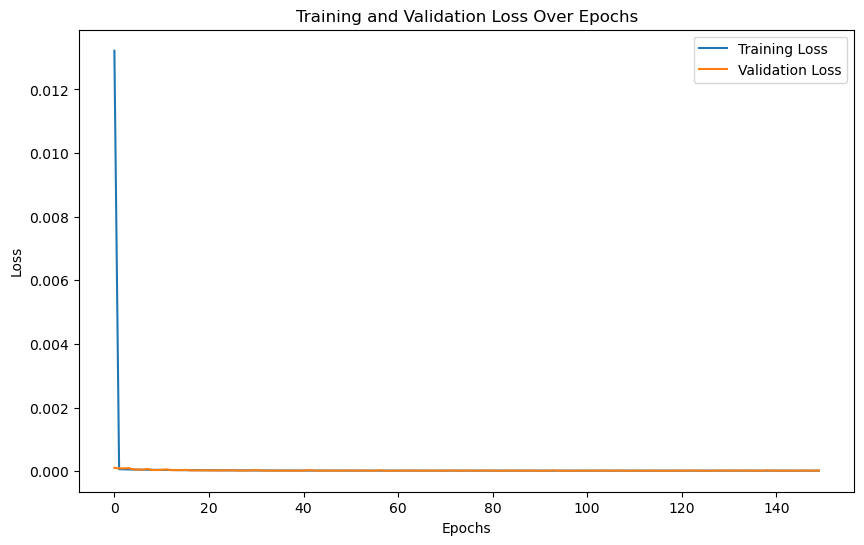

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64785.5361, Test MSE: 62583.8242, Train MAE: 141.1075, Test MAE: 144.7804
Train RMSE: 254.5300, Test RMSE: 250.1676, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4703, Test MAPE: 0.3217
Train Directional Accuracy: 0.4708, Test Directional Accuracy: 0.4703
Training Time: 64.8969 seconds, Evaluat

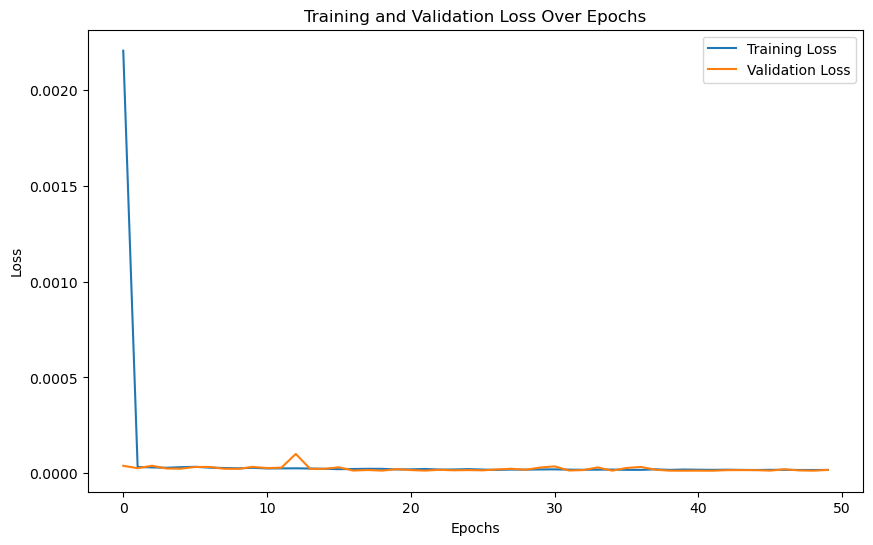

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 111482.1488, Test MSE: 134659.3227, Train MAE: 219.7585, Test MAE: 279.9372
Train RMSE: 333.8894, Test RMSE: 366.9596, Train R2: 0.9996, Test R2: 0.9994
Train MAPE: 0.7291, Test MAPE: 0.6603
Train Directional Accuracy: 0.4718, Test Directional Accuracy: 0.4669
Training Time: 66.6160 seconds, Evaluation Time: 0.4552 seconds



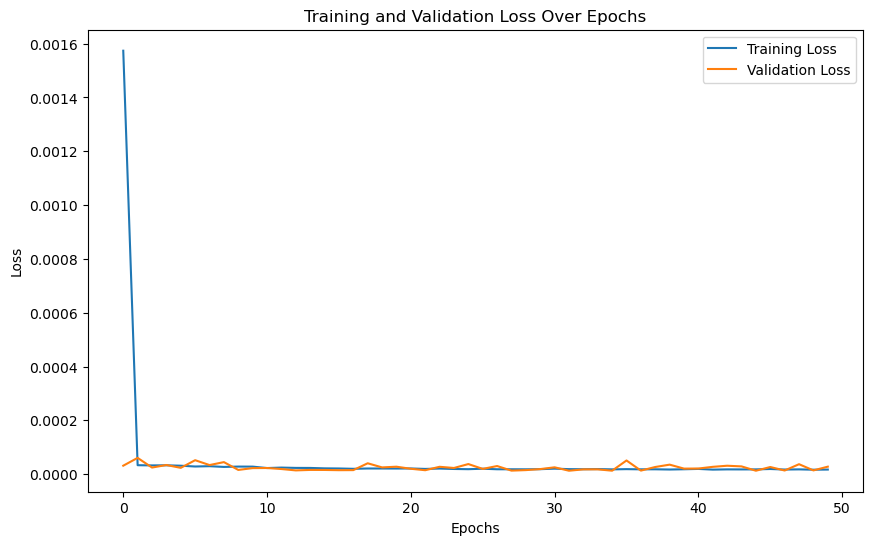

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72076.5447, Test MSE: 63430.1246, Train MAE: 178.0851, Test MAE: 155.2084
Train RMSE: 268.4708, Test RMSE: 251.8534, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.8071, Test MAPE: 0.3629
Train Directional Accuracy: 0.4685, Test Directional Accuracy: 0.4687
Training Time: 80.9769 seconds, Evalu

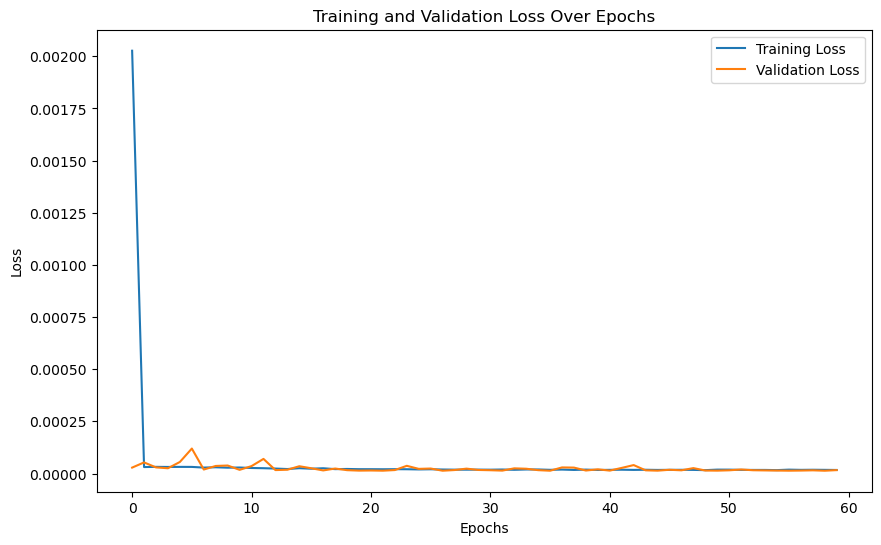

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 106264.9015, Test MSE: 119493.7097, Train MAE: 210.3853, Test MAE: 254.6001
Train RMSE: 325.9830, Test RMSE: 345.6786, Train R2: 0.9996, Test R2: 0.9994
Train MAPE: 0.6834, Test MAPE: 0.5938
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4668
Training Time: 133.9510 seconds, Evaluation Time: 0.4443 seconds



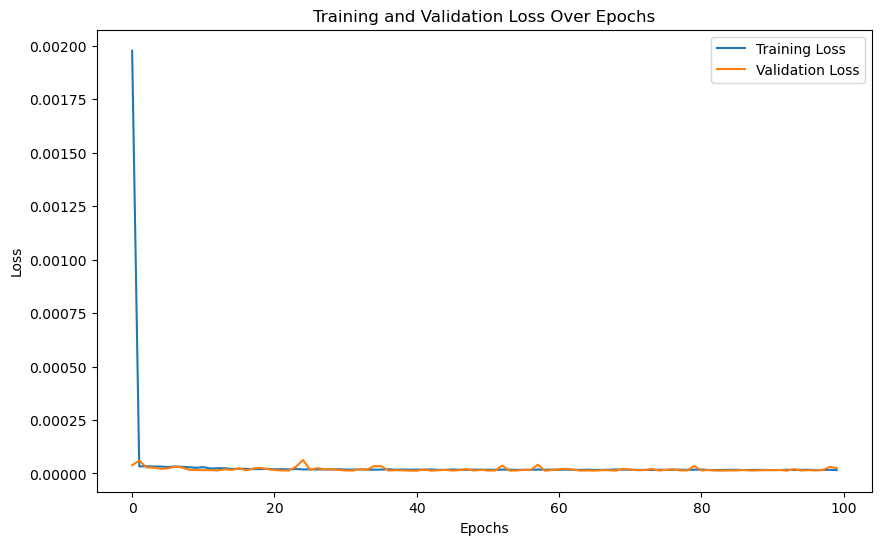

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67475.8880, Test MSE: 60957.4223, Train MAE: 147.2057, Test MAE: 140.3335
Train RMSE: 259.7612, Test RMSE: 246.8956, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5023, Test MAPE: 0.3089
Train Directional Accuracy: 0.4727, Test Directional Accuracy: 0.4687
Training Time: 74.5112 seconds, Evalu

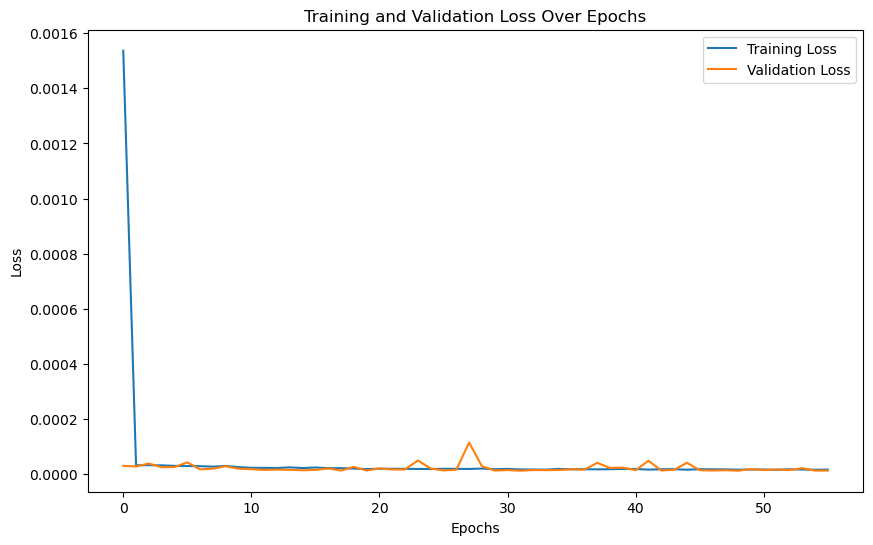

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 74521.7480, Test MSE: 66091.0581, Train MAE: 186.1867, Test MAE: 166.4149
Train RMSE: 272.9867, Test RMSE: 257.0818, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.8283, Test MAPE: 0.3975
Train Directional Accuracy: 0.4683, Test Directional Accuracy: 0.4708
Training Time: 203.6865 seconds, Evaluation Time: 0.4529 seconds



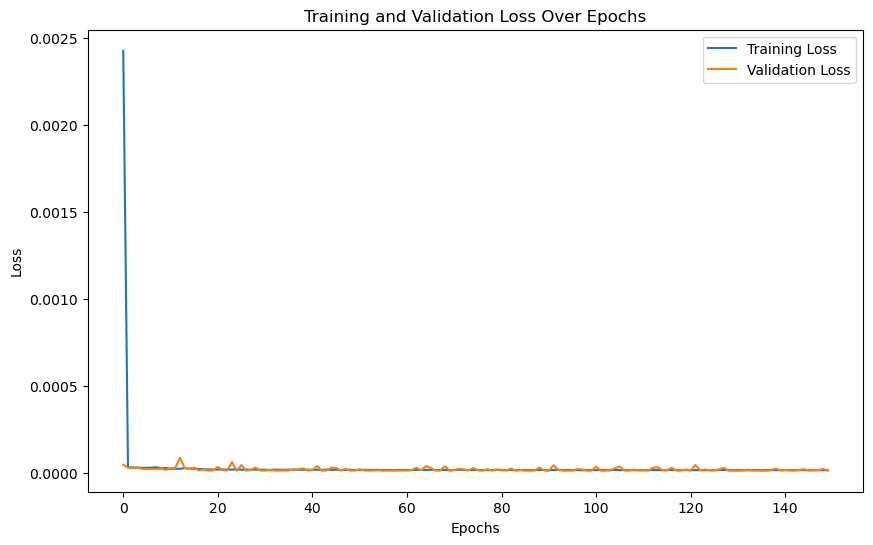

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73124.7274, Test MSE: 69493.9892, Train MAE: 153.4099, Test MAE: 155.6105
Train RMSE: 270.4158, Test RMSE: 263.6171, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5262, Test MAPE: 0.3482
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4707
Training Time: 76.8923 seconds, Eva

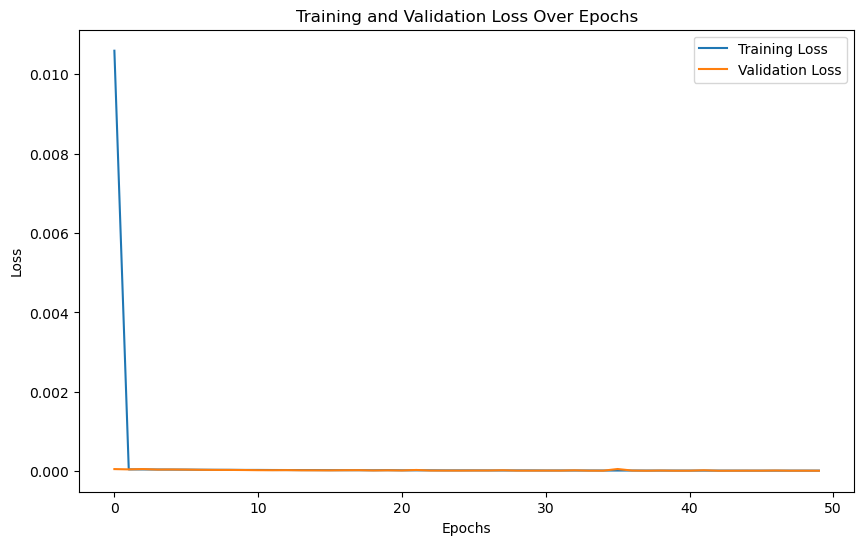

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 70633.1952, Test MSE: 65409.9101, Train MAE: 150.8466, Test MAE: 148.2986
Train RMSE: 265.7691, Test RMSE: 255.7536, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5176, Test MAPE: 0.3320
Train Directional Accuracy: 0.4693, Test Directional Accuracy: 0.4720
Training Time: 70.0815 seconds, Evaluation Time: 0.4744 seconds



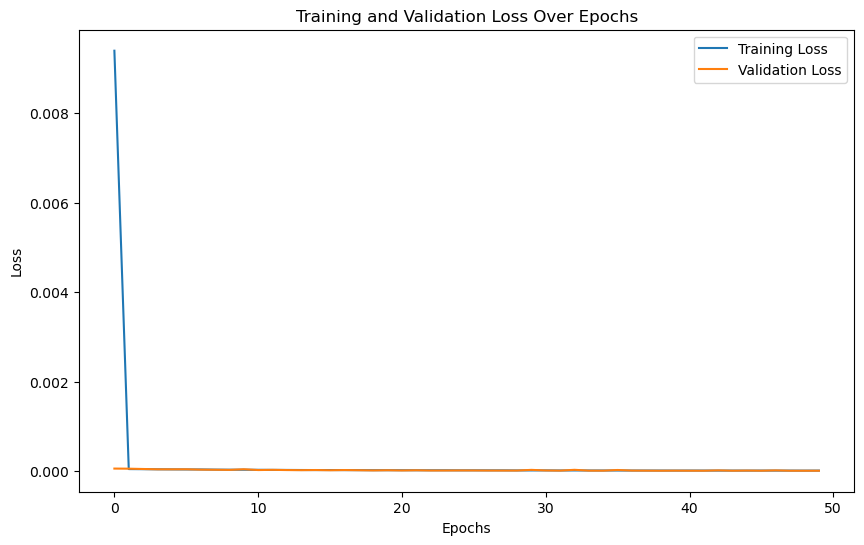

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65097.7921, Test MSE: 61047.1704, Train MAE: 140.5174, Test MAE: 139.4808
Train RMSE: 255.1427, Test RMSE: 247.0773, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4670, Test MAPE: 0.3064
Train Directional Accuracy: 0.4694, Test Directional Accuracy: 0.4696
Training Time: 140.8571 seconds, 

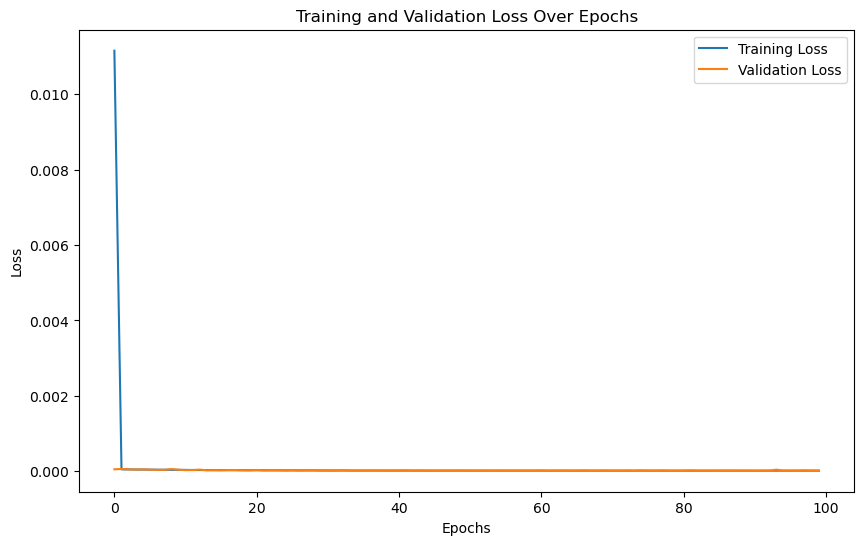

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65577.5608, Test MSE: 62949.5544, Train MAE: 144.8234, Test MAE: 143.0157
Train RMSE: 256.0812, Test RMSE: 250.8975, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5066, Test MAPE: 0.3132
Train Directional Accuracy: 0.4692, Test Directional Accuracy: 0.4699
Training Time: 134.4806 seconds, Evaluation Time: 0.4737 seconds



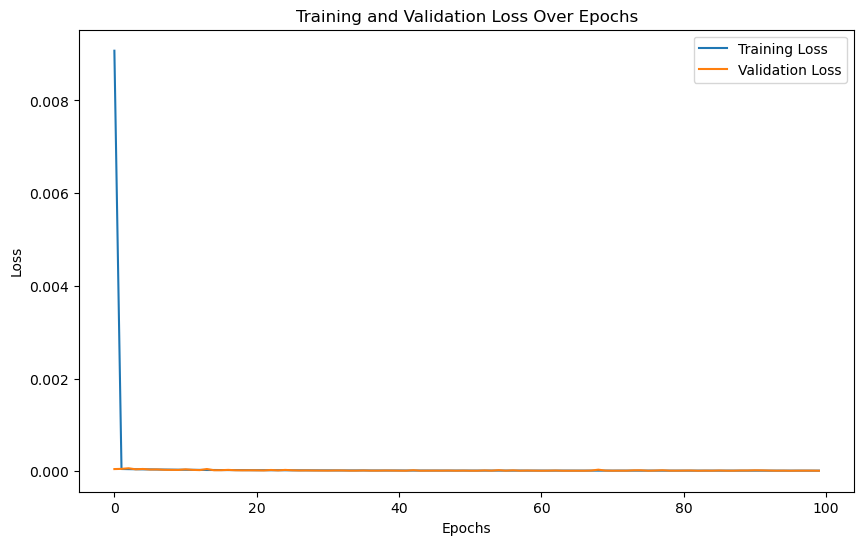

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65156.7425, Test MSE: 60832.2998, Train MAE: 143.6478, Test MAE: 139.4182
Train RMSE: 255.2582, Test RMSE: 246.6420, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4958, Test MAPE: 0.3061
Train Directional Accuracy: 0.4696, Test Directional Accuracy: 0.4701
Training Time: 184.3496 seconds, 

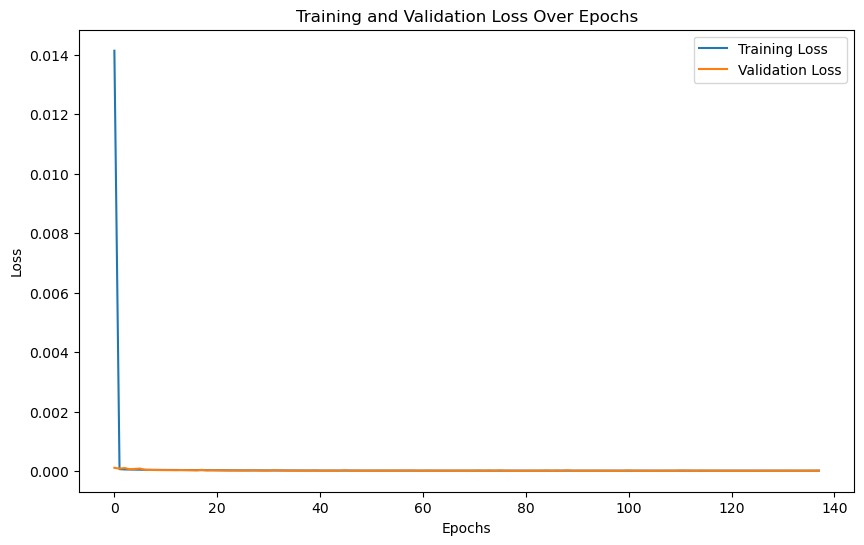

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66937.1385, Test MSE: 64947.7125, Train MAE: 155.9334, Test MAE: 158.6119
Train RMSE: 258.7221, Test RMSE: 254.8484, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5916, Test MAPE: 0.3673
Train Directional Accuracy: 0.4682, Test Directional Accuracy: 0.4695
Training Time: 194.9413 seconds, Evaluation Time: 0.4304 seconds



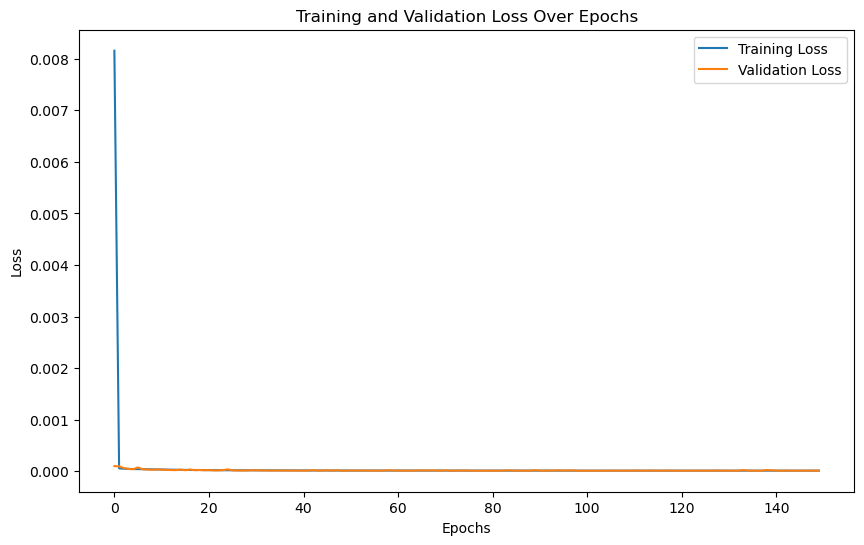

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64729.1840, Test MSE: 61321.0606, Train MAE: 141.4292, Test MAE: 140.2921
Train RMSE: 254.4193, Test RMSE: 247.6309, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4744, Test MAPE: 0.3071
Train Directional Accuracy: 0.4704, Test Directional Accuracy: 0.4672
Training Time: 63.0892 seconds, Evalu

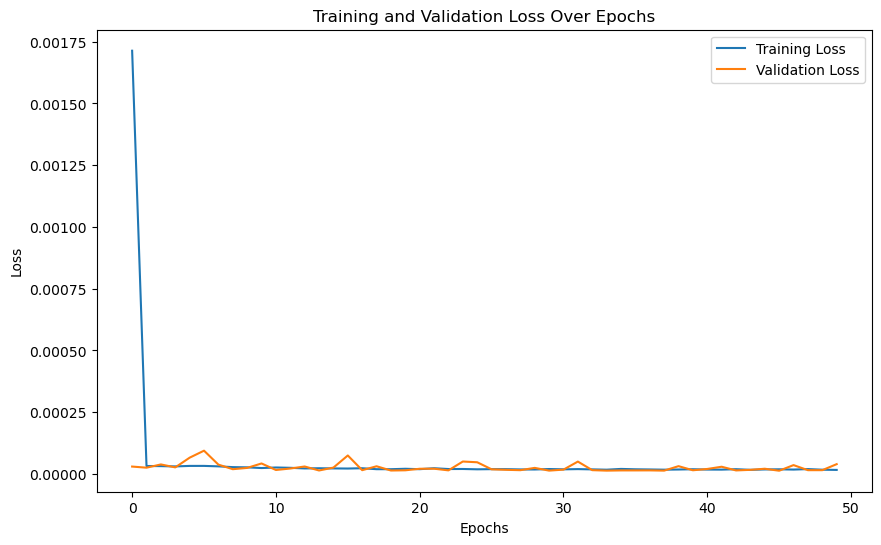

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72300.9638, Test MSE: 68872.7033, Train MAE: 157.7080, Test MAE: 170.0839
Train RMSE: 268.8884, Test RMSE: 262.4361, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5316, Test MAPE: 0.3968
Train Directional Accuracy: 0.4697, Test Directional Accuracy: 0.4692
Training Time: 63.4073 seconds, Evaluation Time: 0.4409 seconds



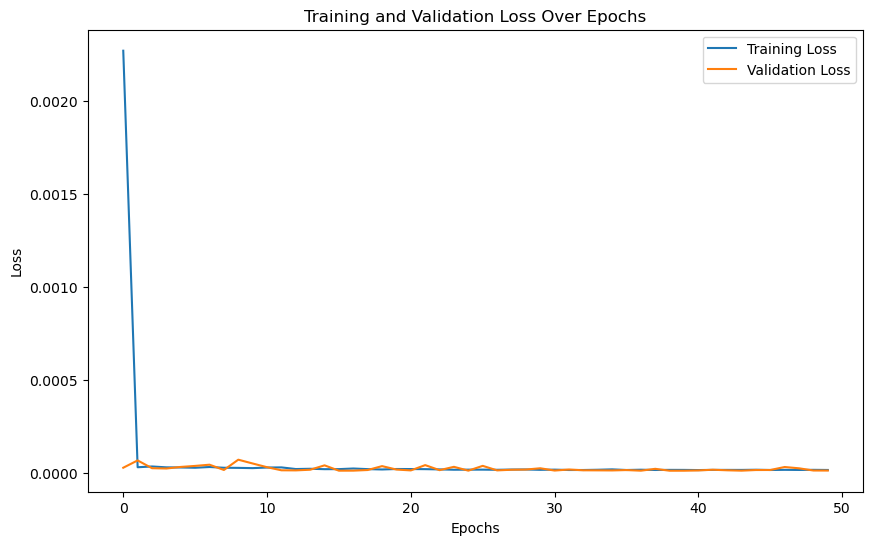

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67860.3775, Test MSE: 62158.5972, Train MAE: 152.5774, Test MAE: 142.3532
Train RMSE: 260.5002, Test RMSE: 249.3163, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5502, Test MAPE: 0.3146
Train Directional Accuracy: 0.4714, Test Directional Accuracy: 0.4696
Training Time: 64.3816 seconds, Eva

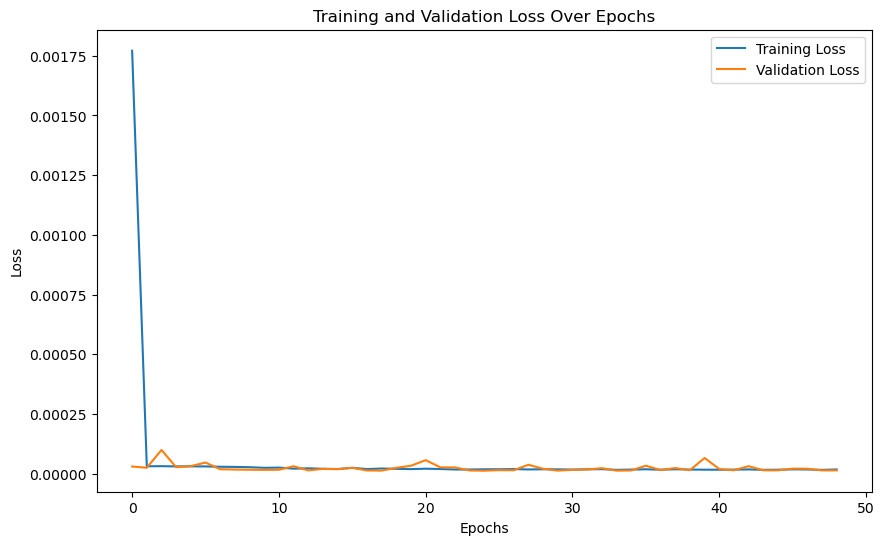

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 99795.5693, Test MSE: 148008.2809, Train MAE: 207.8830, Test MAE: 296.8426
Train RMSE: 315.9044, Test RMSE: 384.7184, Train R2: 0.9996, Test R2: 0.9993
Train MAPE: 0.6887, Test MAPE: 0.6918
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4695
Training Time: 136.6270 seconds, Evaluation Time: 0.4810 seconds



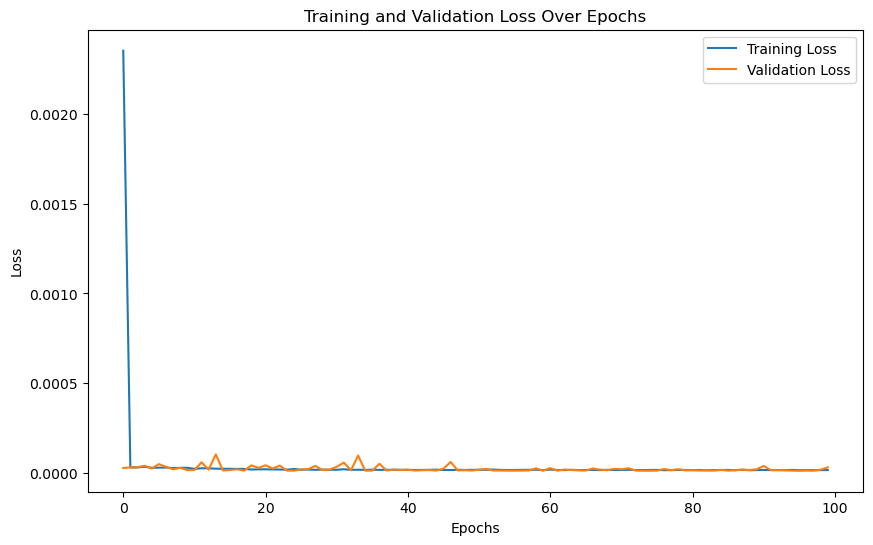

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65583.0824, Test MSE: 60408.0610, Train MAE: 147.8961, Test MAE: 139.9064
Train RMSE: 256.0919, Test RMSE: 245.7805, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5319, Test MAPE: 0.3092
Train Directional Accuracy: 0.4676, Test Directional Accuracy: 0.4697
Training Time: 135.7560 seconds, Ev

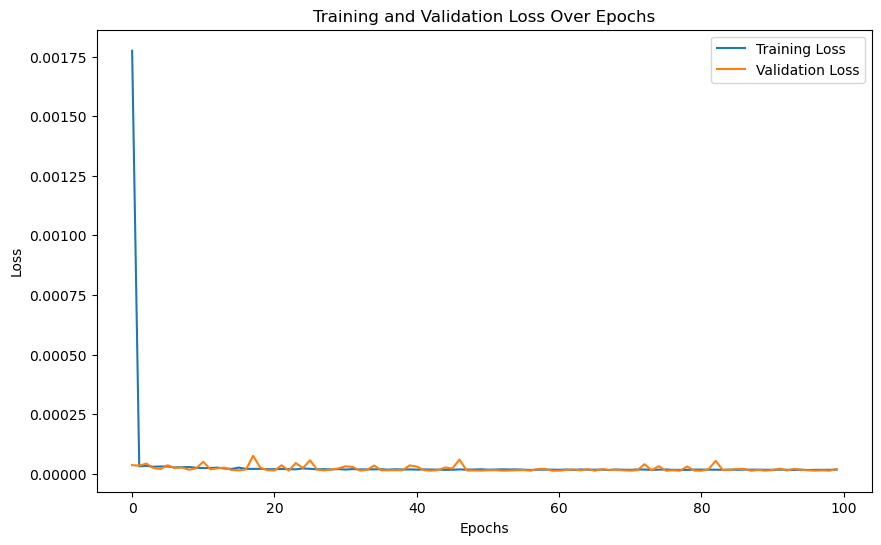

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 128, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66374.6287, Test MSE: 60901.3221, Train MAE: 151.9412, Test MAE: 139.6674
Train RMSE: 257.6327, Test RMSE: 246.7819, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5613, Test MAPE: 0.3075
Train Directional Accuracy: 0.4690, Test Directional Accuracy: 0.4687
Training Time: 193.7447 seconds, Evaluation Time: 0.4434 seconds



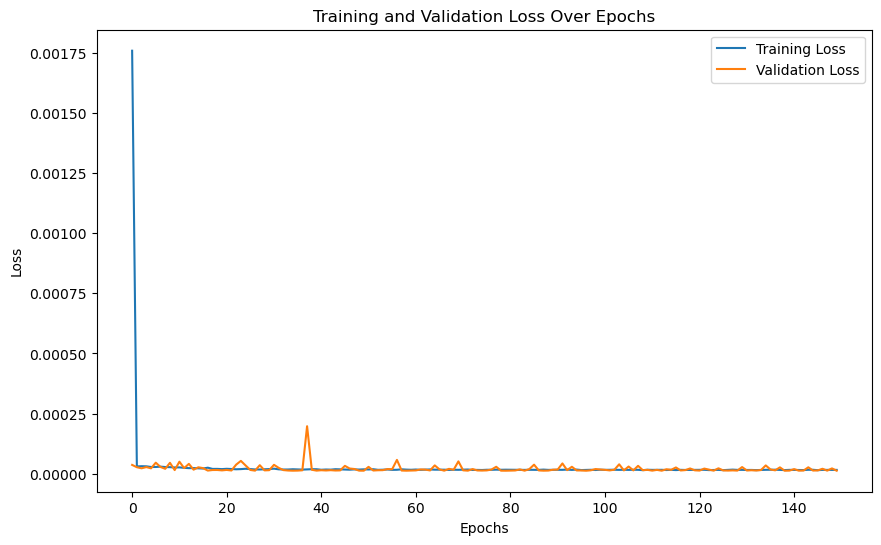

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72369.8609, Test MSE: 64845.2634, Train MAE: 150.3006, Test MAE: 142.6075
Train RMSE: 269.0165, Test RMSE: 254.6473, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5065, Test MAPE: 0.3154
Train Directional Accuracy: 0.4686, Test Directional Accuracy: 0.4726
Training Time: 64.5140 seconds, Evalu

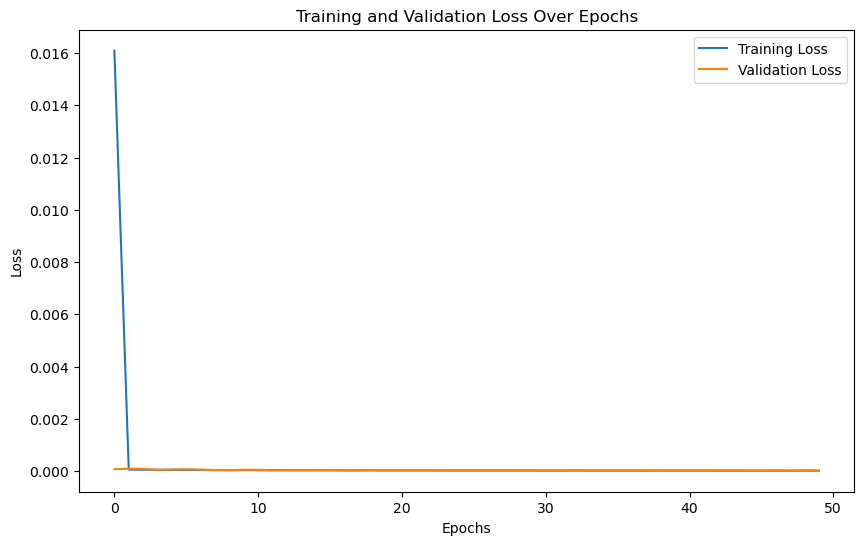

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 72382.5568, Test MSE: 68221.1369, Train MAE: 152.8340, Test MAE: 152.0117
Train RMSE: 269.0401, Test RMSE: 261.1918, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5200, Test MAPE: 0.3379
Train Directional Accuracy: 0.4714, Test Directional Accuracy: 0.4707
Training Time: 64.3331 seconds, Evaluation Time: 0.4404 seconds



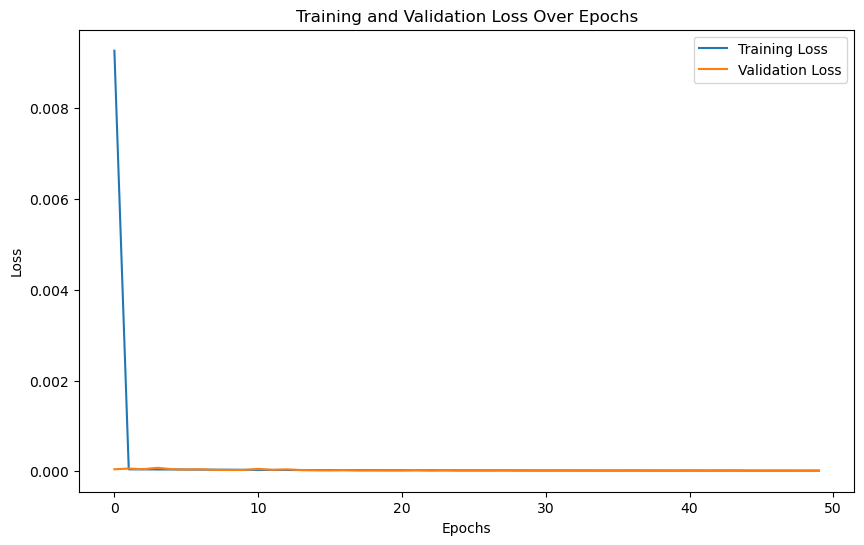

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66678.5246, Test MSE: 61673.2052, Train MAE: 145.3161, Test MAE: 140.4740
Train RMSE: 258.2219, Test RMSE: 248.3409, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4984, Test MAPE: 0.3090
Train Directional Accuracy: 0.4711, Test Directional Accuracy: 0.4709
Training Time: 129.2762 seconds, Ev

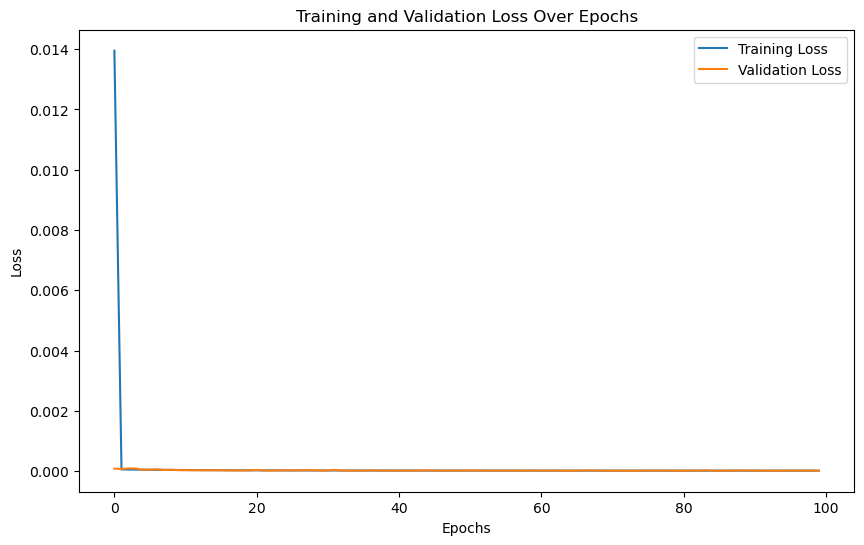

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67682.7917, Test MSE: 66531.6391, Train MAE: 155.0384, Test MAE: 155.7677
Train RMSE: 260.1592, Test RMSE: 257.9373, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5740, Test MAPE: 0.3504
Train Directional Accuracy: 0.4686, Test Directional Accuracy: 0.4713
Training Time: 130.1597 seconds, Evaluation Time: 0.4560 seconds



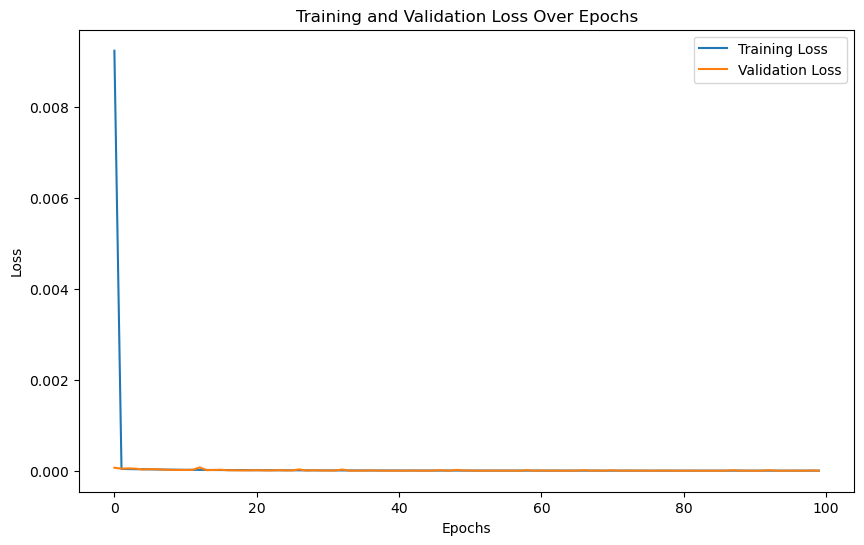

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65386.6807, Test MSE: 60620.4760, Train MAE: 144.5712, Test MAE: 140.1060
Train RMSE: 255.7082, Test RMSE: 246.2123, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4956, Test MAPE: 0.3095
Train Directional Accuracy: 0.4681, Test Directional Accuracy: 0.4691
Training Time: 195.9683 seconds, Ev

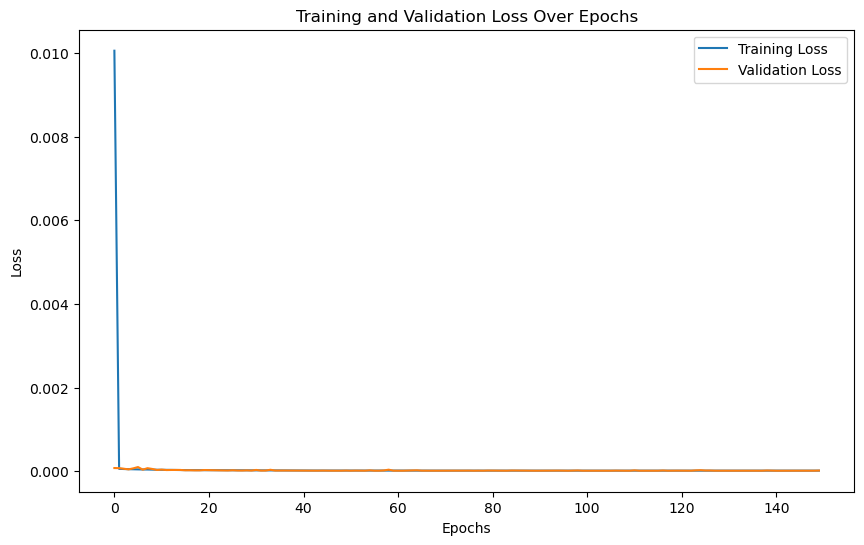

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 70150.2774, Test MSE: 66483.0149, Train MAE: 154.6692, Test MAE: 160.2907
Train RMSE: 264.8590, Test RMSE: 257.8430, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5344, Test MAPE: 0.3684
Train Directional Accuracy: 0.4680, Test Directional Accuracy: 0.4699
Training Time: 195.2884 seconds, Evaluation Time: 0.4524 seconds



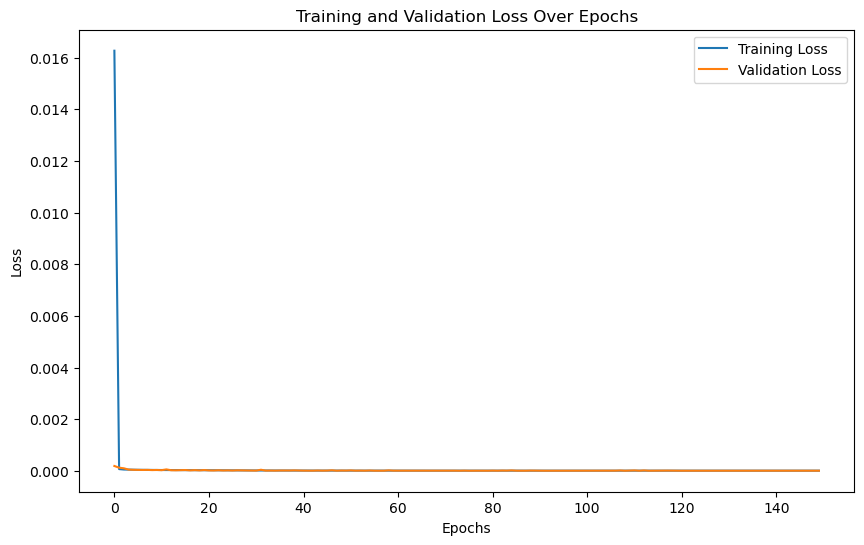

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65672.3202, Test MSE: 60619.5149, Train MAE: 143.7104, Test MAE: 139.2776
Train RMSE: 256.2661, Test RMSE: 246.2103, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4918, Test MAPE: 0.3063
Train Directional Accuracy: 0.4701, Test Directional Accuracy: 0.4668
Training Time: 64.3671 seconds, Evaluat

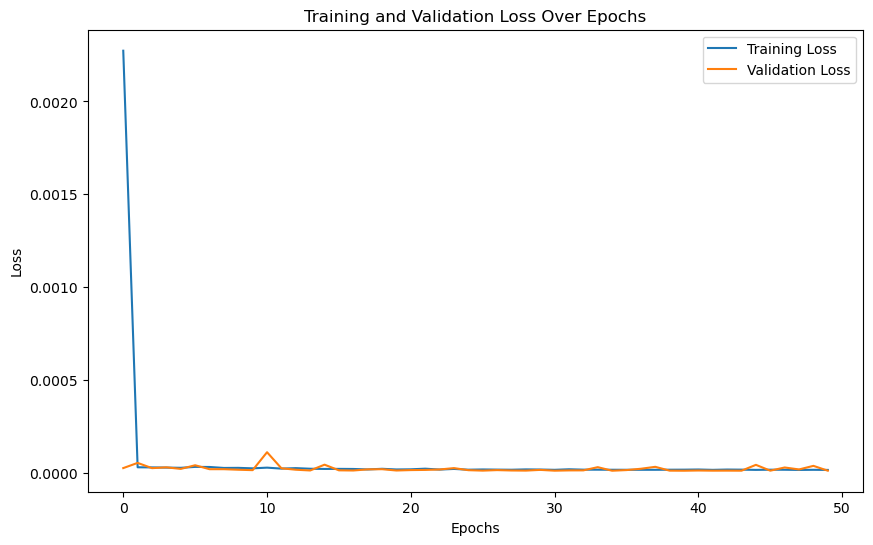

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 127857.7482, Test MSE: 137679.8362, Train MAE: 269.2306, Test MAE: 298.6052
Train RMSE: 357.5720, Test RMSE: 371.0523, Train R2: 0.9995, Test R2: 0.9993
Train MAPE: 1.0774, Test MAPE: 0.7334
Train Directional Accuracy: 0.4702, Test Directional Accuracy: 0.4687
Training Time: 64.0324 seconds, Evaluation Time: 0.4454 seconds



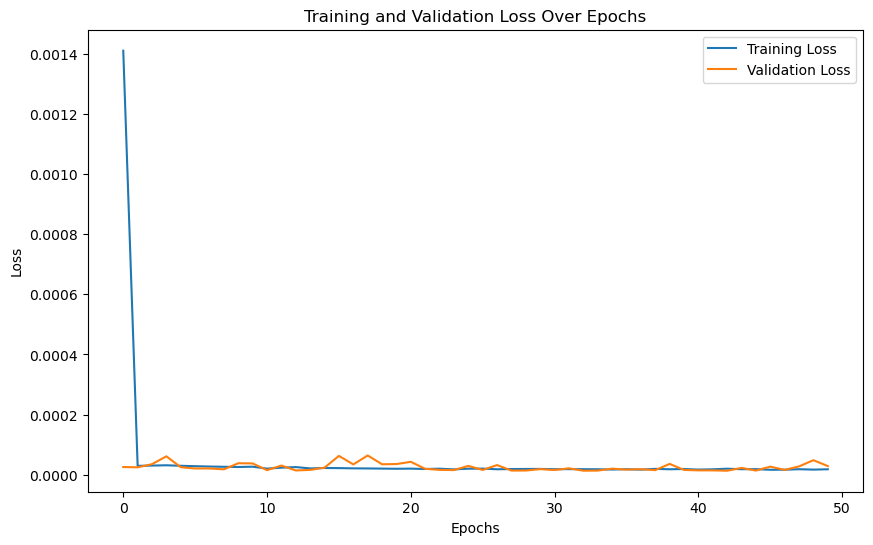

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66365.7794, Test MSE: 60653.4635, Train MAE: 149.8374, Test MAE: 139.1611
Train RMSE: 257.6156, Test RMSE: 246.2792, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5429, Test MAPE: 0.3060
Train Directional Accuracy: 0.4689, Test Directional Accuracy: 0.4679
Training Time: 109.6254 seconds, Eval

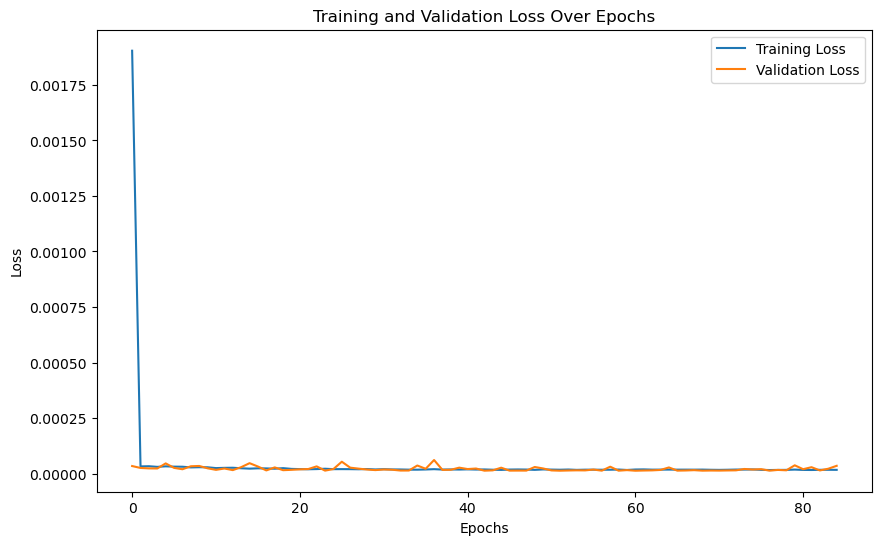

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 73384.9043, Test MSE: 72483.3092, Train MAE: 183.6660, Test MAE: 174.9366
Train RMSE: 270.8965, Test RMSE: 269.2272, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.8253, Test MAPE: 0.4096
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4672
Training Time: 116.6814 seconds, Evaluation Time: 0.4068 seconds



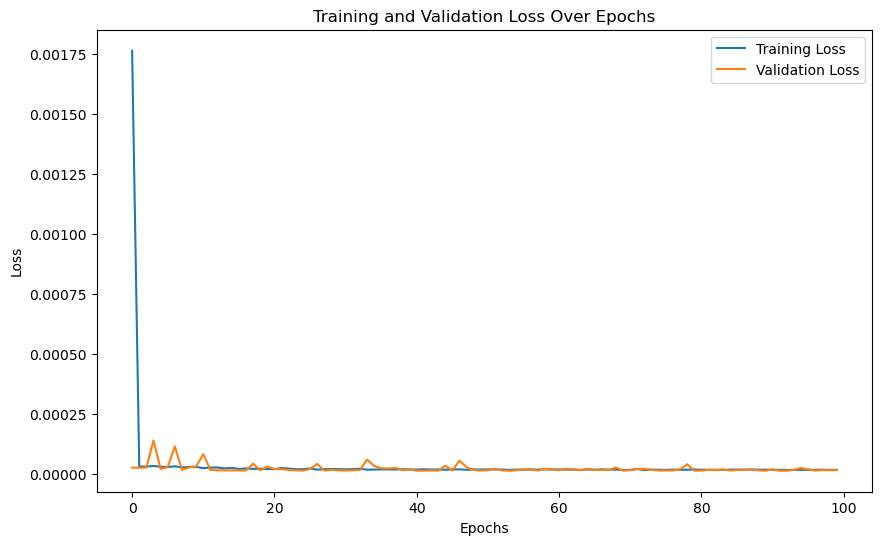

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 64966.9103, Test MSE: 59913.5163, Train MAE: 142.0886, Test MAE: 137.9368
Train RMSE: 254.8861, Test RMSE: 244.7724, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4773, Test MAPE: 0.3037
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4675
Training Time: 124.0791 seconds, Eval

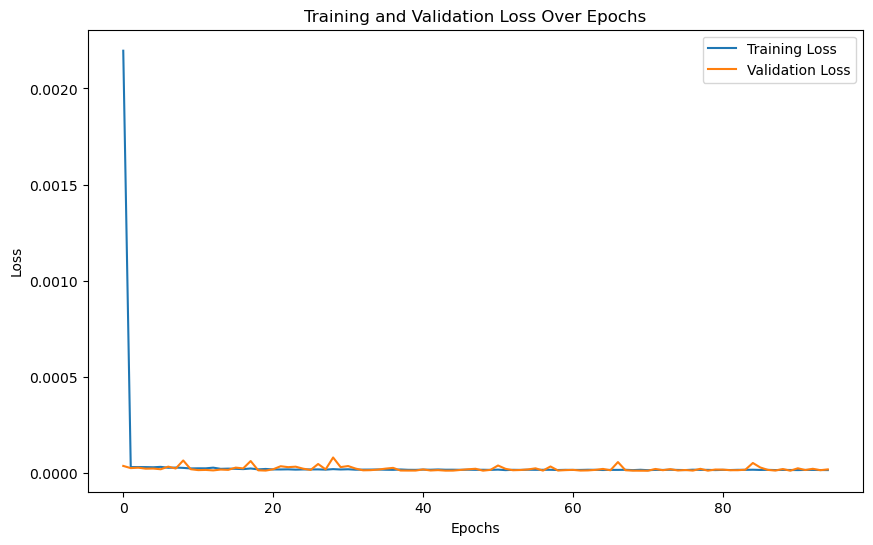

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65122.7201, Test MSE: 69211.4597, Train MAE: 143.0290, Test MAE: 155.2024
Train RMSE: 255.1915, Test RMSE: 263.0807, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4769, Test MAPE: 0.3417
Train Directional Accuracy: 0.4699, Test Directional Accuracy: 0.4666
Training Time: 216.2810 seconds, Evaluation Time: 0.4650 seconds



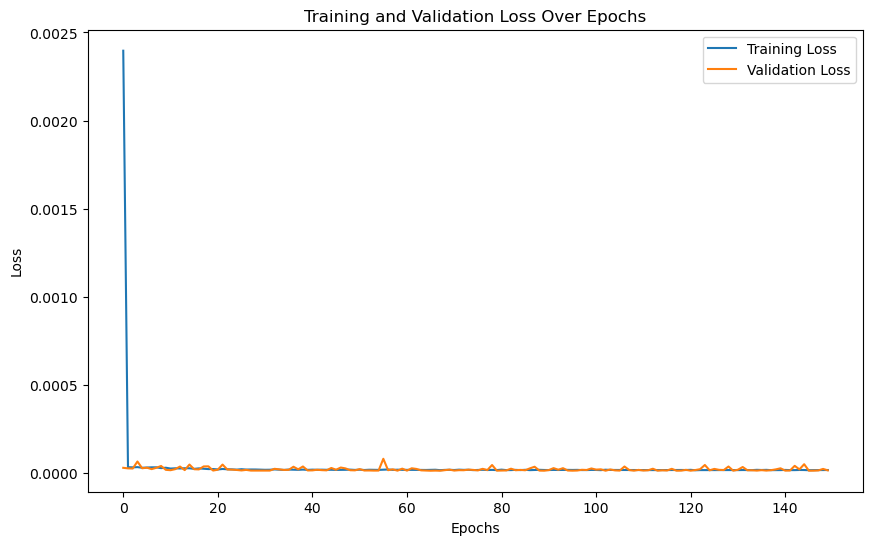

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 75276.1096, Test MSE: 65648.5807, Train MAE: 160.1976, Test MAE: 144.2845
Train RMSE: 274.3649, Test RMSE: 256.2198, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5811, Test MAPE: 0.3206
Train Directional Accuracy: 0.4692, Test Directional Accuracy: 0.4732
Training Time: 67.8964 seconds, Eva

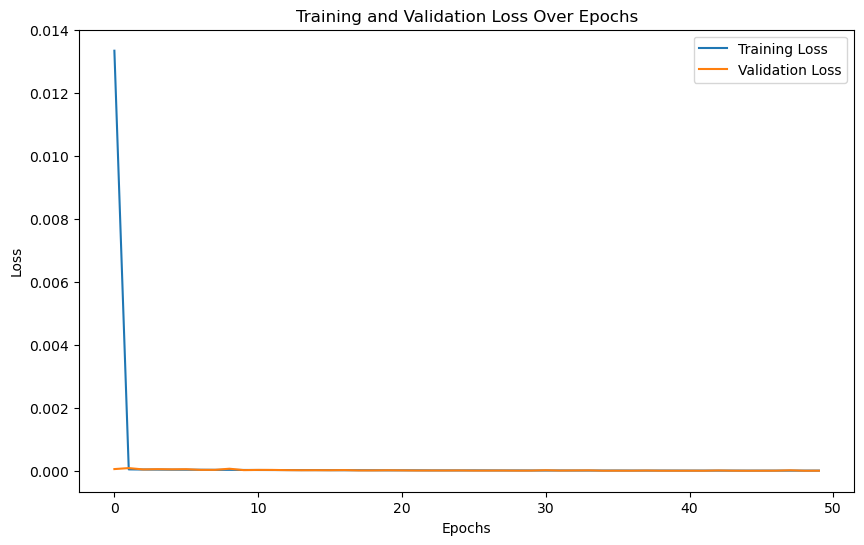

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 75201.0719, Test MSE: 67775.2804, Train MAE: 163.1510, Test MAE: 153.8476
Train RMSE: 274.2281, Test RMSE: 260.3369, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5942, Test MAPE: 0.3490
Train Directional Accuracy: 0.4713, Test Directional Accuracy: 0.4692
Training Time: 67.4201 seconds, Evaluation Time: 0.4934 seconds



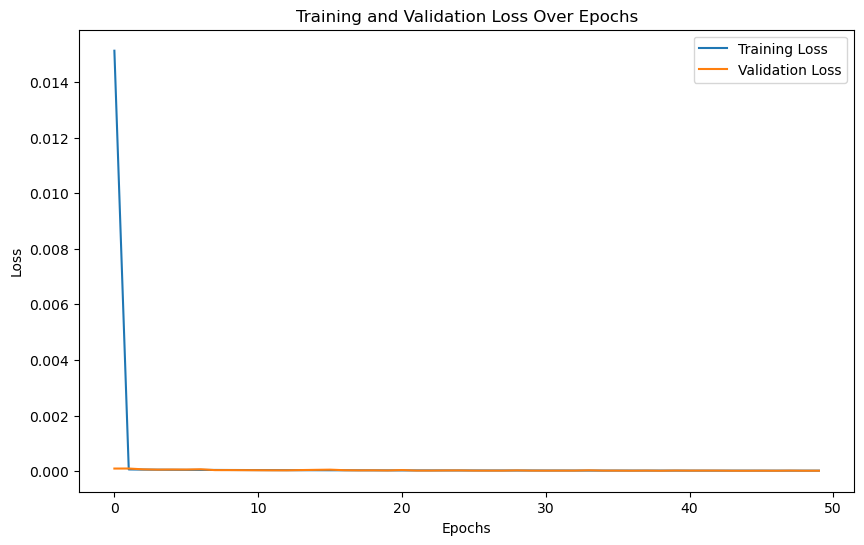

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66769.0653, Test MSE: 61746.1886, Train MAE: 144.0021, Test MAE: 140.3316
Train RMSE: 258.3971, Test RMSE: 248.4878, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4847, Test MAPE: 0.3093
Train Directional Accuracy: 0.4727, Test Directional Accuracy: 0.4708
Training Time: 133.2368 seconds, 

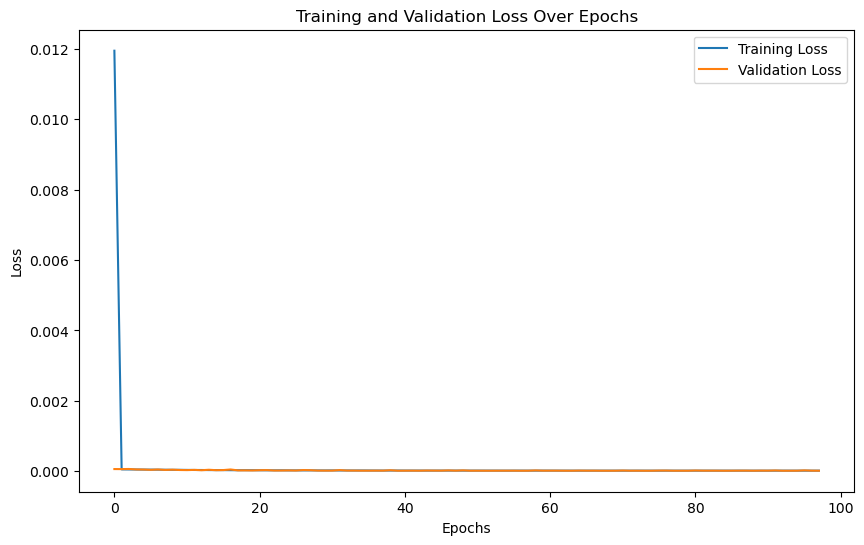

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 68956.7565, Test MSE: 68292.6320, Train MAE: 161.3529, Test MAE: 164.7986
Train RMSE: 262.5962, Test RMSE: 261.3286, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.6272, Test MAPE: 0.3809
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4692
Training Time: 134.7599 seconds, Evaluation Time: 0.4683 seconds



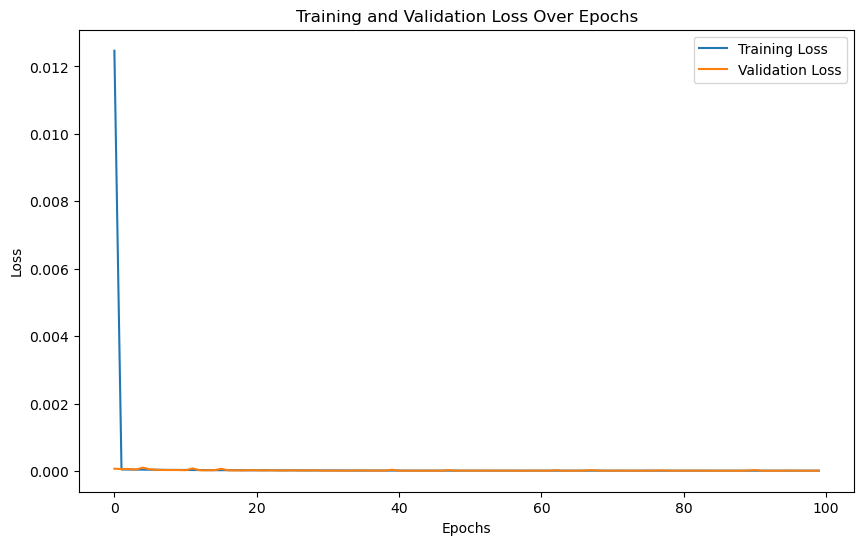

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65169.8477, Test MSE: 60491.9933, Train MAE: 142.7296, Test MAE: 138.7822
Train RMSE: 255.2839, Test RMSE: 245.9512, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4814, Test MAPE: 0.3048
Train Directional Accuracy: 0.4695, Test Directional Accuracy: 0.4666
Training Time: 194.0088 seconds, 

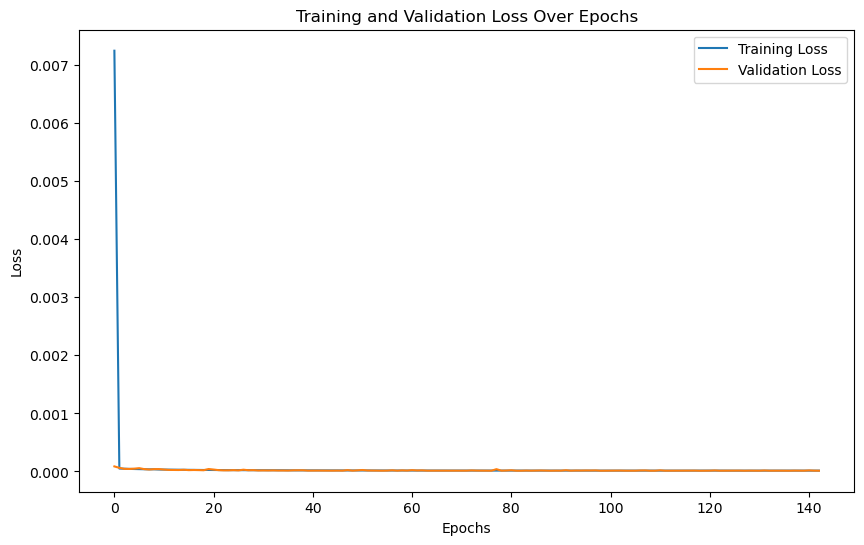

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.0001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 67032.4675, Test MSE: 68467.9054, Train MAE: 148.9362, Test MAE: 160.6434
Train RMSE: 258.9063, Test RMSE: 261.6637, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5077, Test MAPE: 0.3620
Train Directional Accuracy: 0.4692, Test Directional Accuracy: 0.4700
Training Time: 217.1419 seconds, Evaluation Time: 0.4807 seconds



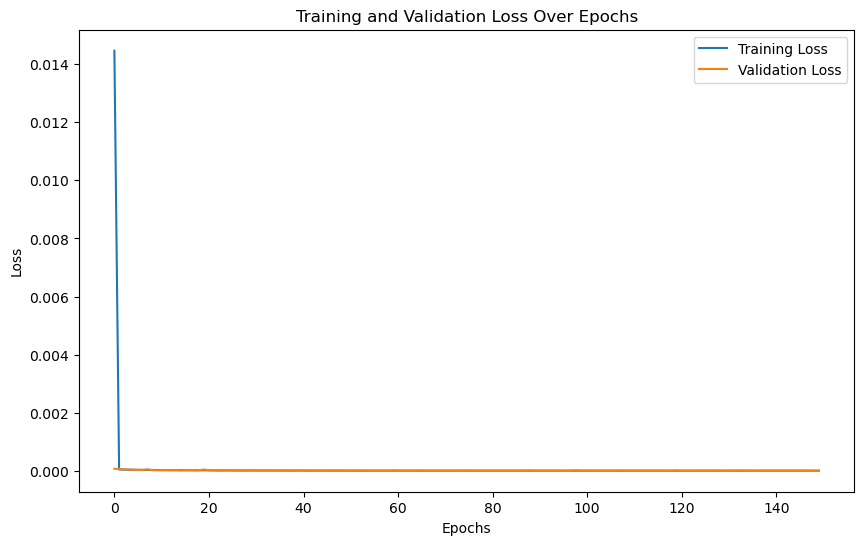

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 65032.4515, Test MSE: 60979.0811, Train MAE: 141.7569, Test MAE: 141.4596
Train RMSE: 255.0146, Test RMSE: 246.9394, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4728, Test MAPE: 0.3148
Train Directional Accuracy: 0.4686, Test Directional Accuracy: 0.4695
Training Time: 74.2822 seconds, Evalu

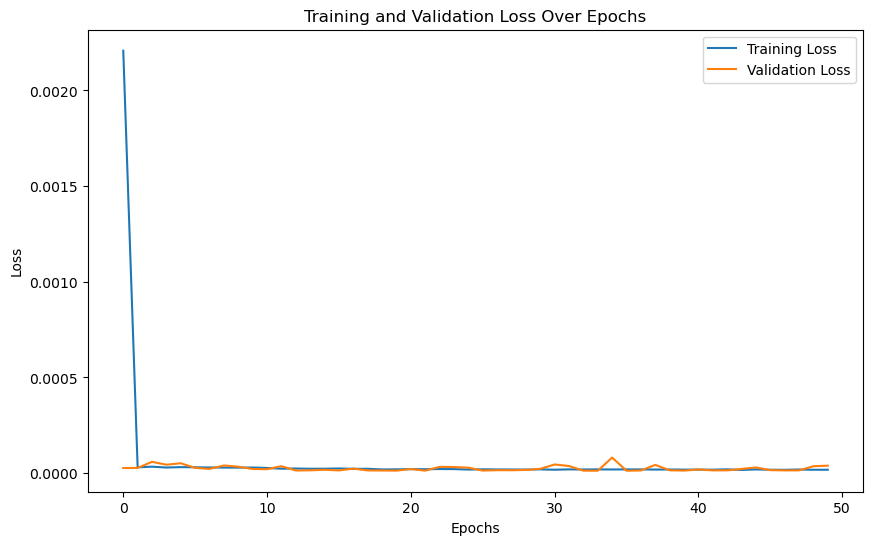

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 50, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 95113.2987, Test MSE: 132970.9166, Train MAE: 204.6263, Test MAE: 268.0933
Train RMSE: 308.4044, Test RMSE: 364.6518, Train R2: 0.9996, Test R2: 0.9994
Train MAPE: 0.7228, Test MAPE: 0.6131
Train Directional Accuracy: 0.4698, Test Directional Accuracy: 0.4692
Training Time: 67.7219 seconds, Evaluation Time: 0.5016 seconds



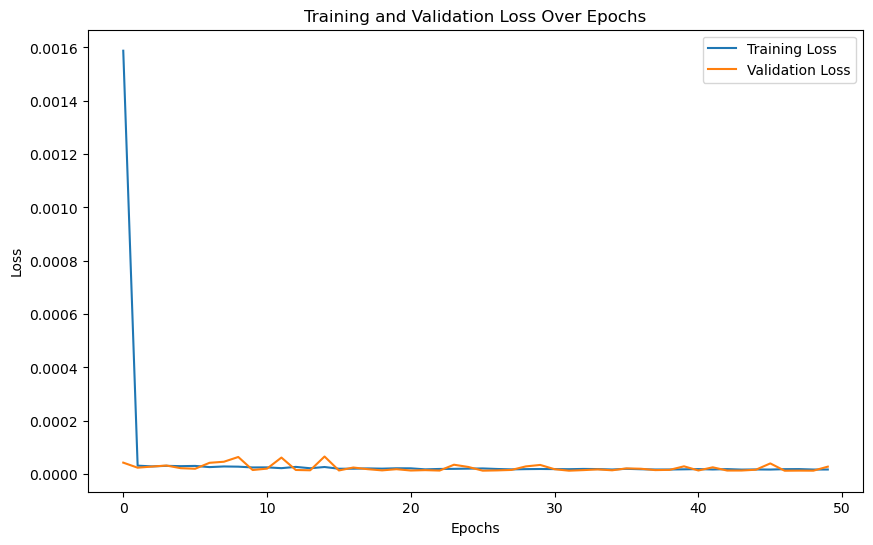

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66331.1587, Test MSE: 60998.4744, Train MAE: 144.4631, Test MAE: 141.5640
Train RMSE: 257.5484, Test RMSE: 246.9787, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.4857, Test MAPE: 0.3152
Train Directional Accuracy: 0.4691, Test Directional Accuracy: 0.4710
Training Time: 74.0051 seconds, Eva

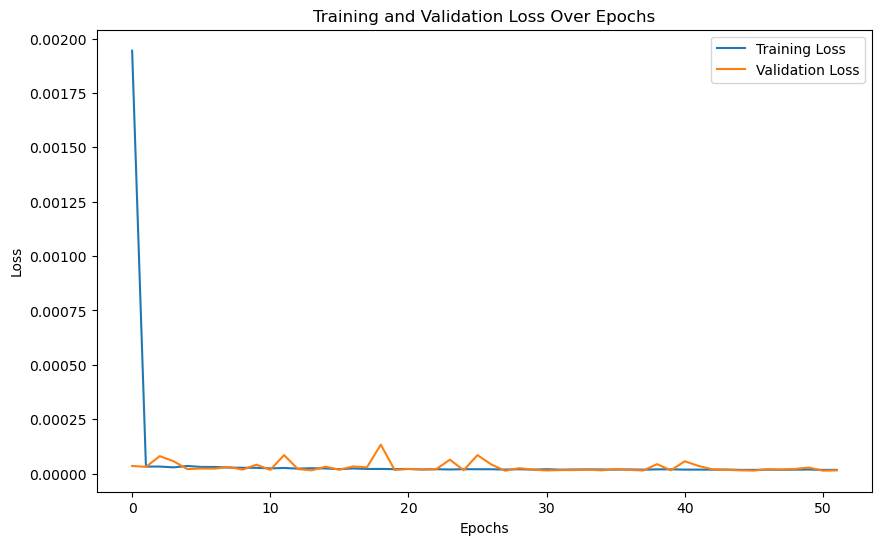

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 113667.5993, Test MSE: 136868.8880, Train MAE: 257.5456, Test MAE: 306.0615
Train RMSE: 337.1463, Test RMSE: 369.9580, Train R2: 0.9996, Test R2: 0.9993
Train MAPE: 1.0548, Test MAPE: 0.7765
Train Directional Accuracy: 0.4705, Test Directional Accuracy: 0.4667
Training Time: 141.3055 seconds, Evaluation Time: 0.4764 seconds



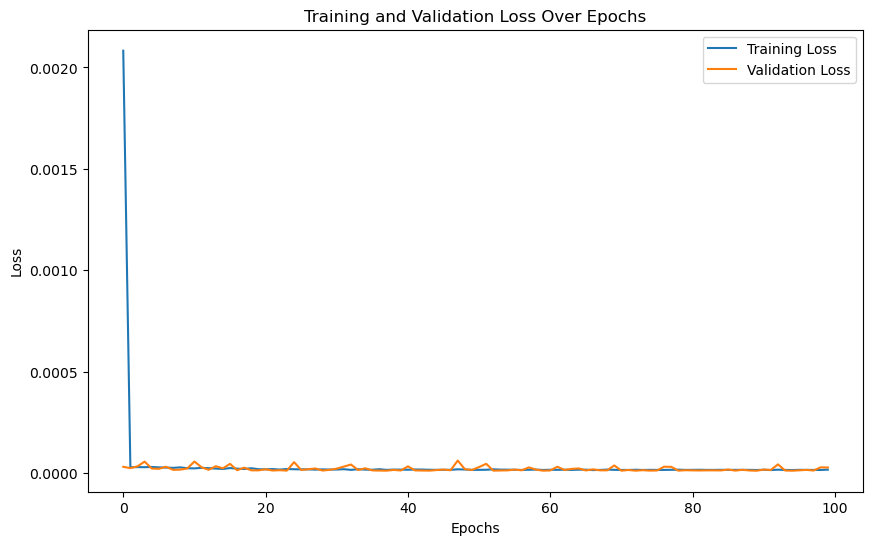

Running model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}, target column: close, features: ['open', 'high', 'low', 'close', 'volume', 'quote_vol', 'count', 'buy_base', 'buy_quote']
Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 66090.9134, Test MSE: 61203.1790, Train MAE: 148.2359, Test MAE: 140.5632
Train RMSE: 257.0815, Test RMSE: 247.3928, Train R2: 0.9997, Test R2: 0.9997
Train MAPE: 0.5381, Test MAPE: 0.3085
Train Directional Accuracy: 0.4705, Test Directional Accuracy: 0.4693
Training Time: 82.9740 seconds, Eva

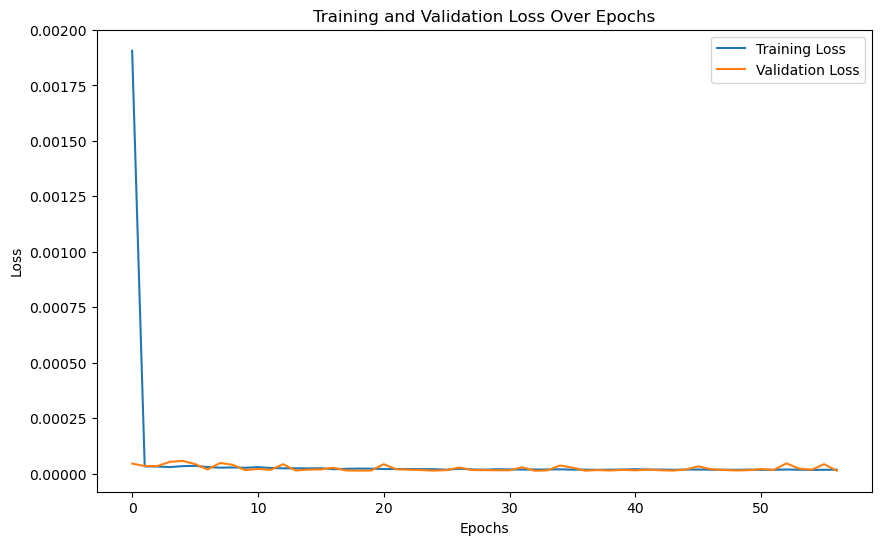

Finished model with parameters: {'window_size': 24, 'lstm_dim': 150, 'dense_dim': 150, 'num_layers': 1, 'dropout': 0.0001, 'lr': 0.001, 'num_epochs': 150, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}
Results: Train MSE: 104576.1710, Test MSE: 153717.6693, Train MAE: 225.2915, Test MAE: 300.4151
Train RMSE: 323.3824, Test RMSE: 392.0684, Train R2: 0.9996, Test R2: 0.9993
Train MAPE: 0.8341, Test MAPE: 0.6975
Train Directional Accuracy: 0.4679, Test Directional Accuracy: 0.4688
Training Time: 216.1122 seconds, Evaluation Time: 0.4755 seconds



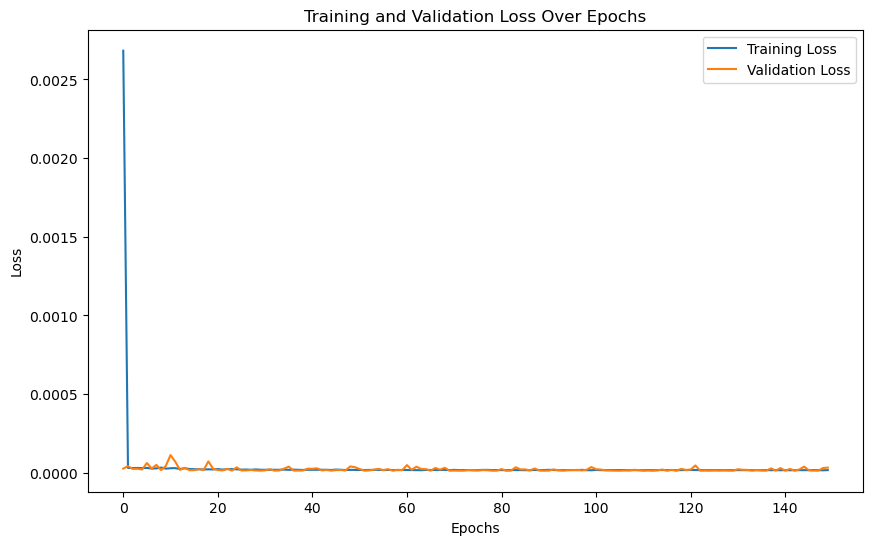

In [9]:
# Grid search
for params in itertools.product(*parameter_space.values()):
    param_dict = dict(zip(parameter_space.keys(), params))
    for target_column in target_columns:
        for features in feature_combinations:
            print(f"Running model with parameters: {param_dict}, target column: {target_column}, features: {features}")
            # Run with early stopping
            train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete', use_early_stopping=True, plot_loss=True)
            # Run with fixed epochs
            train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete_fixed_epochs', use_early_stopping=False, plot_loss=True)